# **MGE analysis**

## Functions and libraries

In [1]:
#Install necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import scipy.stats as stats
import scikit_posthocs as sp
import statannot
from adjustText import adjust_text
import statsmodels.api as sm
from statsmodels.formula.api import glm
import requests
import matplotlib.colors as mcolors

In [2]:
def plot_single_histogram(df, column, title, color, xlabel, ylabel):
    """Plot a single histogram for the specified column in the DataFrame. """
    # Set the figure size
    plt.figure(figsize=(12, 8))

    # Create the histogram with KDE
    sns.histplot(df[column], bins=100, kde=True, color=color)

    # Set titles and labels
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # Customize ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add gridlines for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Show the plot
    plt.show()


In [3]:
def plot_box_swarm_and_histogram(df, column, title_box, title_hist, color_box, color_hist, 
                                 ylabel_box, xlabel_box, xlabel_hist, ylabel_hist):
    """Plot a box plot with swarm plot and a histogram side by side for the specified column in the DataFrame"""
    
    # Create a figure with two subplots: one for the box plot + swarm plot, one for the histogram
    fig, (ax_box, ax_hist) = plt.subplots(1, 2, figsize=(18, 8))

    # Plot the box plot with swarm plot on the first subplot
    sns.boxplot(data=df[column], width=0.4, color=color_box, ax=ax_box, showfliers=False)
    sns.swarmplot(data=df[column], color='k', size=3, alpha=0.6, ax=ax_box)
    
    # Calculate and annotate median on the box plot
    median = df[column].median()
    max_value = df[column].max()
    if max_value > 100:
        median_formatted = f'{median:.0f}'
    elif max_value > 1:
        median_formatted = f'{median:.3f}'
    else:
        median_formatted = f'{median:.1e}'
    
    ax_box.text(-0.2, median, median_formatted, color='black', ha='center', va='center', 
                fontsize=18, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    #ax_box.set_title(title_box, fontsize=16)
    ax_box.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax_box.set_xlabel(xlabel_box, fontsize=16)
    ax_box.set_ylabel(ylabel_box, fontsize=16)
    ax_box.yaxis.set_tick_params(labelsize=13)
    
    ax_box.set_xticks([])  # Remove x-ticks as there's only one category
    
    # Plot the histogram on the second subplot
    sns.histplot(df[column], bins=50, kde=True, color=color_hist, ax=ax_hist)
    
    #ax_hist.set_title(title_hist, fontsize=16)
    ax_hist.set_xlabel(xlabel_hist, fontsize=16)
    ax_hist.set_ylabel(ylabel_hist, fontsize=16)
    ax_hist.xaxis.set_tick_params(labelsize=13)
    ax_hist.yaxis.set_tick_params(labelsize=13)
    ax_hist.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

In [4]:
def spearman_correlation_scatter(df, data1:str, data2:str, size:str="medium", title:str="", xlab:str="", ylab:str="",map="viridis"):
    '''This function calulcates the spearman correlation coefficient between two series of data and creates a scatter plot. It needs as input a dataframe,
    the name of the two columns and the desired size of the plot in the form of a string "big"/"medium"/"small". Addittionally, specify plot title and label'''
    
    # Extract the data to check for significance
    series1 = pd.Series(df[data1].tolist())
    series2 = pd.Series(df[data2].tolist())
    
    # Calculate Spearman correlation
    spearman_corr, p_value = stats.spearmanr(series1, series2)
    
    # Check if p-values is significant
    if p_value >= 0.05:
        print(f"The p-value is not significant (p = {p_value:.2f}), so the plot will not be created.")
        return
    else:
        # Choose dimensions
        size_dict = {"big": (16, 14, 12, 10, 8), "medium": (14, 12, 10, 8, 6), "small": (12, 10, 8, 6, 4)}
        dimensions = size_dict.get(size, size_dict["medium"]) 
        
        # Set size
        plt.figure(figsize=(dimensions[2], dimensions[4]))
        
        # Plot scatter plot
        scatter = plt.scatter(series2, series1, c=series1, cmap=map, alpha=0.9, zorder=2)
        
        # Title and labels
        #plt.title(title if title else f"Scatter plot of correlation between {data1} and {data2}", fontsize=dimensions[0])
        plt.xlabel(xlab if xlab else f"{data2}", fontsize=dimensions[1])
        plt.ylabel(ylab if ylab else f"{data1}", fontsize=dimensions[1])
        
        # Add a regression line
        slope, intercept, r_value, p_value_linreg, std_err = stats.linregress(series2, series1)
        line = slope * np.array(series2) + intercept
        plt.plot(series2, line, color='red', label='Regression Line', alpha=0.6)
        
        # Add correlation text
        plt.text(0.95, 0.05, f'Spearman coeff. : {spearman_corr:.3f}\np-value: {p_value:.2e}', 
                 ha='right', va='bottom', transform=plt.gca().transAxes, color="red", fontsize=dimensions[0],
                 bbox=dict(facecolor='white', alpha=1))
        
        # Set gridlines to horizontal only
        plt.grid(True, axis='both', linestyle='--', linewidth=0.5, zorder=1)
        # Show plot
        plt.show()


In [5]:
def multiple_spearman_correlation_scatter(df1, data1:str, data2:str, df2, data3:str, data4:str, size:str="medium", title1:str="", xlab1:str="", ylab1:str="", title2:str="", xlab2:str="", ylab2:str=""):
    '''This function calulcates the spearman correlation coefficient between four series of data and creates 2 scatter plots. It needs as input 2 dataframes,
    the name of the four columns and the desired size of the plot in the form of a string "big"/"medium"/"small". Addittionally, specify plots titles and labels'''
    
    # Extract the data to check for signifcance
    series1=pd.Series(df1[data1].tolist())
    series2=pd.Series(df1[data2].tolist())
    series3=pd.Series(df2[data3].tolist())
    series4=pd.Series(df2[data4].tolist())
        
    # Calculate Spearman correlation
    spearman_corr_1_2, p_value_1_2 =stats.spearmanr(series1, series2)
    spearman_corr_3_4, p_value_3_4 =stats.spearmanr(series3, series4)

        # Check if p-values are significant
    if p_value_1_2 >= 0.05 and p_value_3_4 >= 0.05:
        print(f"The p-values are not significant (p1 = {p_value_1_2:.3f}, p2 = {p_value_3_4:.3f}), so the plot will not be created.")
        return
    
    if p_value_1_2 >= 0.05:
        print(f"Spearman correlation is not significant between {data1} and {data2} (p = {p_value_1_2:.3f}), so only the second plot will be created.")
        spearman_correlation_scatter(df2, data3, data4, size, title2)
        return
    
    if p_value_3_4 >= 0.05:
        print(f"Spearman correlation is not significant between {data3} and {data4} (p = {p_value_3_4:.3f}), so only the first plot will be created.")
        spearman_correlation_scatter(df1, data1, data2, size, title1)
        return

    # Choose dimensions
    size_dict = {"big": (16, 14, 12, 10, 8), "medium": (14, 12, 10, 8, 6), "small": (12, 10, 8, 6, 4)}
    dimensions = size_dict.get(size, size_dict["medium"])
            
    # Set up the figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(dimensions[0], dimensions[4]))  # 1 row, 2 columns, adjusted figsize

    # Plot the first scatter plot
    scatter1 = axes[0].scatter(series2, series1, c=series1, cmap="viridis", alpha=0.8)
    cbar1 = fig.colorbar(scatter1, ax=axes[0])

    # Title and labels for the first plot
    axes[0].set_title(title1 if title1 else f"Scatter plot of correlation between {data1} and {data2}", fontsize=dimensions[0])
    axes[0].set_xlabel(xlab1 if xlab1 else f"{data2}", fontsize=dimensions[1])
    axes[0].set_ylabel(ylab1 if ylab1 else f"{data1}", fontsize=dimensions[1])
    
    # Add correlation text for the first plot
    axes[0].text(0.95, 0.05, f'p-value: {p_value_1_2:.2e}', 
                 ha='right', va='bottom', transform=axes[0].transAxes, color="red", fontsize=dimensions[3],
                 bbox=dict(facecolor='white', alpha=0.5))
    
    # Plot the second scatter plot
    scatter2 = axes[1].scatter(series4, series3, c=series3, cmap="viridis", alpha=0.8)
    cbar2 = fig.colorbar(scatter2, ax=axes[1])

    # Title and labels for the second plot
    axes[1].set_title(title2 if title2 else f"Scatter plot of correlation between {data3} and {data4}", fontsize=dimensions[0])
    axes[1].set_xlabel(xlab2 if xlab2 else f"{data4}", fontsize=dimensions[1])
    axes[1].set_ylabel(ylab2 if ylab2 else f"{data3}", fontsize=dimensions[1])
    
    # Add correlation text for the second plot
    axes[1].text(0.95, 0.05, f'p-value: {p_value_3_4:.2e}', 
                 ha='right', va='bottom', transform=axes[1].transAxes, color="red", fontsize=dimensions[3],
                 bbox=dict(facecolor='white', alpha=0.5))
    
    # Finalize
    for ax in axes:
        ax.grid(True)

    plt.tight_layout()
    plt.show()


In [6]:
def mannwhitney(data1,data2):
    '''This function calculates the Mann-Whitney U test between two series of data'''
    mannwhitneyu = stats.mannwhitneyu(data1, data2)
    return mannwhitneyu

In [7]:
def plot_violin_swarm_with_annotations(data, x, y, title='', x_label='', y_label='', custom_order=None, palette=None,pairs=""):
    """Plot a violin plot with swarm plot and add median lines and p-value annotations."""

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot violin and swarm plot
    sns.violinplot(ax=ax, x=x, y=y, data=data, palette=palette, inner='quartiles', linewidth=1, order=custom_order, zorder=2)
    sns.swarmplot(ax=ax, x=x, y=y, data=data, color='k', alpha=0.6, size=3, order=custom_order, zorder=3)

    # Add horizontal lines for median and median text    
    medians = data.groupby(x)[y].median().reindex(custom_order)
    
    for i, median in enumerate(medians):
        max_value = data[y].max()
        if max_value > 100:
            median_formatted = f'{median:.0f}'
        elif max_value > 1:
            median_formatted = f'{median:.3f}'
        else:
            median_formatted = f'{median:.1e}'
        
        ax.text(i-0.2, median, median_formatted, ha='center', va='center', color='black', fontsize=14, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
    
    # Add p-value annotations using statannot
    statannot.add_stat_annotation(ax=ax, data=data, x=x, y=y, hue=None, box_pairs=pairs,
                        test="Mann-Whitney", comparisons_correction=None,text_format="star", loc="inside", line_offset_to_box=0.15, verbose=2)

    # Add title and labels
    #ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    plt.xticks(fontsize=16) # Increase font size for x-ticks
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5, zorder=0)
    ax.set_axisbelow(True)
    
    # Show plot
    plt.tight_layout()
    plt.show()

In [8]:
def perform_kruskal_dunn(df_list,data,names, significance_level=0.05):
    """
    Perform the Kruskal-Wallis test, and if significant, perform the Dunn test.
    
    Parameters:
        groups (list of pd.Series): List of data series for each group.
        significance_level (float): Significance level for the Kruskal-Wallis test.
    
    Returns:
        None
    """
    groups=[]
    for e in df_list:
        groups.append(e[data])
        
    # Perform the Kruskal-Wallis test
    kruskal_result = stats.kruskal(*groups)
    
    # Print the Kruskal-Wallis test result
    print(f'Kruskal-Wallis test result: H-statistic = {kruskal_result.statistic}, p-value = {kruskal_result.pvalue}')
    
    # Check if the result is significant
    if kruskal_result.pvalue < significance_level:
        print("Kruskal-Wallis test is significant, performing Dunn test...")
        
        # Perform the Dunn test with Bonferroni correction
        dunn_result = sp.posthoc_dunn(groups, p_adjust='bonferroni')
        
        # Print significant results from the Dunn test
        print("Significant Dunn test results (Bonferroni corrected):")
        significant_results = dunn_result[dunn_result < significance_level]
        print(significant_results)
        for i in range(len(significant_results)):
            for j in range(len(significant_results)):
                if i < j:
                    if significant_results.iloc[i, j] < significance_level:
                        print(names[i],names[j],significant_results.iloc[i, j])
        return significant_results
    
    else:
        print("Kruskal-Wallis test is not significant, skipping Dunn test.")


In [9]:
def plot_violin_swarm_with_annotations_animals(data, x, y, significant_results=None, title='', x_label='', y_label='', custom_order=None, palette=None,names=""):
    """Plot a violin plot with swarm plot and add median lines and p-value annotations."""

    #custom_order = ["human", "dog",  "cow","goat", "sheep"]
     
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot violin and swarm plot
    sns.violinplot(ax=ax, x=x, y=y, data=data, palette=palette, inner='quartiles', linewidth=1, order=custom_order, zorder=2)
    sns.swarmplot(ax=ax, x=x, y=y, data=data, color='k', alpha=0.6, size=3, order=custom_order, zorder=3)

    # Add horizontal lines for median and median text    
    medians = data.groupby(x)[y].median().reindex(custom_order)
    
    for i, median in enumerate(medians):
        max_value = data[y].max()
        if max_value > 100:
            median_formatted = f'{median:.0f}'
        elif max_value > 1:
            median_formatted = f'{median:.3f}'
        else:
            median_formatted = f'{median:.1e}'
        
        ax.text(i-0.25, median, median_formatted, ha='center', va='center', color='black', fontsize=14, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
    
    significant_pairs = []
    significant_pvalues =[]
    
    if significant_results is not None:
        for i in range(len(significant_results)):
                for j in range(len(significant_results)):
                    if i < j:
                        if significant_results.iloc[i, j] < 0.05:
                            significant_pairs.append((names[j],names[i]))
                            significant_pvalues.append(significant_results.iloc[i, j])
        print(significant_pairs)  
        print(significant_pvalues)              
        # Add p-value annotations using statannot
        statannot.add_stat_annotation(ax=ax, data=data, x=x, y=y, box_pairs=significant_pairs, order=custom_order, line_height=0,text_offset=0.01,line_offset=0.01,
                        perform_stat_test=False, pvalues=significant_pvalues, line_offset_to_box=0.1,text_format="star", loc="inside", verbose=2)

    # Add title and labels
    #ax.set_title(title, fontsize=16)
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    plt.xticks(fontsize=16)
    
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5, zorder=0)
    ax.set_axisbelow(True)
    
    # Show plot
    plt.tight_layout()
    plt.show()    
    

In [10]:
def plot_box_swarm(data, x_col, y_col, title='', x_label='', y_label='',color="skyblue"):
    """
    Plot a combined box plot and swarm plot for HGT_richness.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing the data to plot.
        x_col (str): Column name for the x-axis.
        y_col (str): Column name for the y-axis.
        hue_col (str): Column name for the hue.
        title (str): Title of the plot.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
        palette (dict): Color palette for the hue.
    """
    hue_col=data["species"].apply(lambda x: 'human' if x == 'human' else 'animals')
    palette={'human': '#F77F00', 'animals': '#143642'}

    # Set up the figure and axes
    plt.figure(figsize=(14, 9))
    
    # Plot box plot
    sns.boxplot(x=x_col, y=y_col, data=data, color=color, width=0.7, showfliers=False)
    
    # Plot swarm plot
    sns.swarmplot(x=x_col, y=y_col, data=data, hue=hue_col, palette=palette, size=3)
    
    # Set title and labels
    plt.title(title, fontsize=16)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90, fontsize=8, ha='right')
    
    # Improve y-axis ticks formatting
    plt.ticklabel_format(style='plain', axis='y')
    
    # Show plot
    plt.tight_layout()
    plt.show()

In [11]:
def plot_donut_and_histogram_with_custom_order(df, level_col='level', count_col='count', custom_order=None, title_donut='Donut Chart', title_hist='Histogram', donut_explode=0, bar_margin=0.1, colors="blue"):
    if custom_order is not None:
        df_sorted = df.set_index(level_col).loc[custom_order].reset_index()
    else:
        df_sorted = df

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot Donut Chart
    donut_explode = [donut_explode] * len(df_sorted)

    wedges, texts, autotexts = axes[0].pie(
        df_sorted[count_col],
        startangle=140,
        labels=df_sorted[level_col],
        wedgeprops=dict(width=0.3),
        autopct='%1.1f%%',
        pctdistance=0.85,
        labeldistance=1.05,
        explode=donut_explode,
        colors=colors
    )

    # Draw a white circle at the center to make it a donut chart
    centre_circle = plt.Circle((0, 0), 0.65, color='white', fc='white', linewidth=0)
    axes[0].add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    axes[0].axis('equal')
    axes[0].set_title(title_donut)

    # Plot Histogram
    axes[1].bar(df[level_col], df[count_col], color=colors, width=0.8, edgecolor='black', linewidth=0.5)
    axes[1].set_title(title_hist)
    axes[1].set_xlabel(level_col)
    axes[1].set_ylabel(count_col)

    # Display counts on top of bars in histogram
    for i, v in enumerate(df[count_col]):
        axes[1].text(i, v + 0.5, str(v), ha='center', va='bottom')

    # Rotate x-axis labels for better readability
    axes[1].set_xticklabels(df[level_col], rotation=45, ha='right')

    # Display the plots
    plt.tight_layout()
    plt.show()


In [12]:
def make_df_top3_LCA(df, letter="s",n=3):
    clade=[]
    count=[]
    for i,row in df.iterrows():
        if f"{letter}__" in row[0]:
            clade.append(row[0])
            count.append(row[1])
    
    df_LCA_tax=pd.DataFrame(columns=["LCA","count"])
    df_LCA_tax["LCA"]=clade
    df_LCA_tax["count"]=count
    if letter!="k":
        df_LCA_tax_5=df_LCA_tax.head(n)
        
        df_LCA_last=pd.DataFrame(columns=["LCA","count"])
        sum=df_LCA_tax["count"][n:].sum()
        df_LCA_last["LCA"]=["others"]
        df_LCA_last["count"]=[sum]
    
        df_LCA_6=pd.concat([df_LCA_tax_5,df_LCA_last], ignore_index=True)
        return df_LCA_6
    else:
        return df_LCA_tax
    

In [13]:
def make_multiple_pies(df_list,x,labels,colors,names):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 3 plots per row, 2 rows
    fig.suptitle("Top 3 LCA per taxonomic level", fontsize=16)

    for i, ax in enumerate(axes.flatten()):
        df_LCA = df_list[i]
        wedges, texts, autotexts = ax.pie(df_LCA[x], labels=df_LCA[labels], startangle=140, 
                                        pctdistance=0.85, autopct='%1.0f%%', 
                                        wedgeprops=dict(width=0.3), colors=colors)
        center_circle = plt.Circle((0, 0), 0.65, color='white', fc='white', linewidth=0)
        ax.add_artist(center_circle)
        ax.set_title(f"Pie Chart {names[i]}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout to fit the suptitle
    plt.show()

In [14]:
def confounder_analysis(df, dependent_var, primary_independent_var, potential_confounder):
    # Ensure the primary independent variable is categorical if not already
    if df[primary_independent_var].dtype.name != 'category':
        df[primary_independent_var] = df[primary_independent_var].astype('category')
    
    # Null model: dependent_var ~ primary_independent_var
    null_model = glm(f'{dependent_var} ~ {primary_independent_var}', data=df, family=sm.families.Gaussian())
    null_result = null_model.fit()
    
    # Full model: dependent_var ~ primary_independent_var + potential_confounder
    full_model = glm(f'{dependent_var} ~ {primary_independent_var} + {potential_confounder}', data=df, family=sm.families.Gaussian())
    full_result = full_model.fit()
    
    # Print summary of the null model
    print("Null Model Summary:")
    print(null_result.summary())
    
    # Print summary of the full model
    print("Full Model Summary:")
    print(full_result.summary())
    
    # Print p-values of the full model
    print("P-values for the Full Model:")
    print(full_result.pvalues)
    
    # Calculate the likelihood ratio test manually
    lr_stat = 2 * (full_result.llf - null_result.llf)
    df_diff = full_result.df_model - null_result.df_model
    p_value = stats.chi2.sf(lr_stat, df_diff)
    
    print(f"Likelihood Ratio Test Statistic: {lr_stat}")
    print(f"Degrees of Freedom Difference: {df_diff}")
    print(f"P-value: {p_value}")

In [15]:
blues=["#227C9D", "#102542", "#1F7A8C", "#6A8EAE", "#19647E", "#28AFB0", "#7EBDC2", "#38726C", "#276FBF", "#183059"]
yellows= ["#FFCB77", "#FAA916", "#DCF763", "#EC9F05", "#F5BB00", "#19535F", "#8EA604", "#EAB464", "#F7F052", "#CFD11A"]
greens=["#48CFAE", "#84E296", "#C4F7A1", "#C8D96F", "#A5B452", "#A2AD59", "#A0EEC0", "#8AE9C1", "#86CD82", "#72A276", "#558B6E"]
reds=["#FE6D73", "#B76D68", "#C84630", "#EF959C", "#F87060"]
purples= ["#9F4A54", "#320E3B", "#9D5C63", "#442F38", "#3D0814", "#574B60", "#3B1F2B", "#885A89", "#503047", "#7261A3"]
others=["#0D1F2D","#C1292E", "#7B3E19","#4C2C69","#63595C", "#D9BBF9","#412234","#E2B6CF"]

overall_distribution_colors=["#227C9D","#48CFAE"]

states_color=["#FFCB77", "#FE6D73"]
#states_color=["#92B86C","#1496B6"]

sex_nation_colors=["#227C9D","#227C9D", "#48CFAE","#48CFAE","#FFCB77","#FFCB77"]
#sex_nation_colors=["#FF8552","#FF8552", "#297373","#297373","#E9D758","#E9D758"]

humans_animals_colors=["#227C9D","#9F4A54"]
#humans_animals_colors=["#FFE74C","#FF5964"]

species_colors=["#227C9D","#FFCB77","#48CFAE","#FE6D73","#9F4A54"]
#species_colors=["#43666C","#8E3333","#D3D9D7","#C26D29","#CFBF46"]

age_colors=["#227C9D","#FFCB77","#48CFAE","#FE6D73","#9F4A54"]
#age_colors=["#C9DBBA","#DCDBA8","#F5CDA7","#FAA381","#DB5A42"]

lca_colors=["#227C9D","#FFCB77","#48CFAE","#FE6D73","#9F4A54","#63595C","#E2B6CF","#D9BBF9"]
#lca_colors=["#62466B","#093A3E","#2D5D7B","#133C55","#457EAC","#62BEC1","#386FA4","#9191E9","#C2AFF0"]

top10_lca_colors=["#227C9D","#FFCB77","#48CFAE","#FE6D73","#9F4A54","#63595C","#E2B6CF","#D9BBF9","#4C2C69","#7B3E19"]

pie_chart_colors=["#227C9D","#FFCB77","#48CFAE","#FE6D73"]

dataset_colors=["#DA344D","#D91E36","#1E91D6","#0072BB","#DAFF7D","#8FC93A"]
family_colors=["#32CBFF","#00A5E0","#89A1EF","#725AC1","#8D86C9","#B9FFB7","#ABEDC6","#98D9C2"]

waafle_colors=["#FE6D73", "#FE6D73", "#FE6D73", "#FE6D73", "#FE6D73"]
waafle_colors_sex=["#F7B267","#F7B267","#F4845F","#F4845F","#F25C54","#F25C54"]

custom_palette = sns.color_palette(
    ["#1B6A8D",  # Intermediate dark blue
    "#227C9D",  # Dark Blue
    "#43B4A8",  # Transitioning color
    "#4CD3B3",  # Transitioning color
    "#67E5C1",  # Transitioning color
    "#78E9C6",  # Transitioning color
    "#8BE9CA",  # Transitioning color
    "#B0E1D5",  # Transitioning color
    "#D0E0A2",  # Transitioning color
    "#E3E68D",  # Transitioning color
    "#D9E79B",  # Transitioning color
    "#E9E285",  # Transitioning color (more yellowish)
    "#FFCB77",  # Yellow-Orange
    "#F8B05E",  # Transitioning color (more reddish)
    "#F7A04B",  # Transitioning color (more reddish)
    "#F69342",  # Transitioning color (more reddish)
    "#F57D38",  # Transitioning color (more reddish)
    "#FE6D73",  # Light Red-Pink
    "#F77D80",  # Transitioning color
])
custom_cmap = mcolors.ListedColormap(custom_palette)

# **Dataset preparation**

In [16]:
df=pd.read_csv("/home/giacomo/Thesis-Internship/waafle/waafle_metadata.tsv", sep="\t")

print(df.shape)
df.head(5)

(550, 28)


sampleID     subjectID   householdID family_role species      date  \
0  C16-20009-TZ  C16-20009-TZ  C16-10012-TZ      animal     cow  23/11/16   
1  C16-20010-TZ  C16-20010-TZ  C16-10012-TZ      animal     cow  23/11/16   
2  C16-20011-TZ  C16-20011-TZ  C16-10012-TZ      animal     cow  23/11/16   
3  C16-20012-TZ  C16-20012-TZ  C16-10012-TZ      animal     cow  23/11/16   
4  C16-20013-TZ  C16-20013-TZ  C16-10012-TZ      animal     cow  23/11/16   

   sex  age_days  age_months  age_years  ... viruses HGT_richness  \
0  NaN       NaN         NaN        NaN  ...    3967     2.968577   
1  NaN       NaN         NaN        NaN  ...    1867     1.372176   
2  NaN       NaN         NaN        NaN  ...    9620     2.680315   
3  NaN       NaN         NaN        NaN  ...    4758     1.904265   
4  NaN       NaN         NaN        NaN  ...     296     0.627451   

     HGT_depth plasmids_richness  plasmids_depth  viruses_richness  \
0  3825.833477          2.530499     3261.249085          7.332717   
1  4790.147000          0.425684     1486.024806          2.219976   
2  4694.724051          1.559055     2730.773684          7.574803   
3  5819.453484          0.731754     2236.245938          4.509953   
4   278.540606          6.705882     2976.902731          5.803922   

   viruses_depth  mge_total  mge_total_richness  mge_total_depth  
0    9450.237488       5336            9.863216     12711.486573  
1    7749.743890       2225            2.645660      9235.768696  
2   13267.698406      11600            9.133858     15998.472090  
3   13782.458774       5530            5.241706     16018.704712  
4    2576.500609        638           12.509804      5553.403340  

[5 rows x 28 columns]

In [17]:
#country distributions analysis
df_ghana=df[df["country"]=="Ghana"]
df_tanzania=df[df["country"]=="Tanzania"]

#Species distribution analysis
df_humans=df[df["species"]=="human"]
df_humans["species"]="Humans"
df_goats=df[df["species"]=="goat"]
df_goats["species"]="Goats"
df_cows=df[df["species"]=="cow"]
df_cows["species"]="Cows"
df_sheeps=df[df["species"]=="sheep"]
df_sheeps["species"]="Sheep"
df_dogs=df[df["species"]=="dog"]
df_dogs["species"]="Dogs"
df_animals=pd.concat([df_goats,df_sheeps,df_cows,df_dogs],ignore_index=True)
df_animals["species"]="Animals"
df_all_species=pd.concat([df_humans,df_goats,df_sheeps,df_cows,df_dogs],ignore_index=True)
df_binomial_species=pd.concat([df_humans,df_animals], ignore_index=True)

#Sex distribution analysis
df_males=df[df["sex"]=="male"]
df_females=df[df["sex"]=="female"]
df_GH_males=df_males[df_males["country"]=="Ghana"]
df_GH_females=df_females[df_females["country"]=="Ghana"]
df_TZ_males=df_males[df_males["country"]=="Tanzania"]
df_TZ_females=df_females[df_females["country"]=="Tanzania"]

df_GH_males_copy = df_GH_males.copy()
df_GH_females_copy = df_GH_females.copy()
df_TZ_males_copy = df_TZ_males.copy()
df_TZ_females_copy = df_TZ_females.copy()
df_males_copy = df_males.copy()
df_females_copy = df_females.copy()

df_GH_males_copy.loc[:, 'dataset'] = 'males_GH'
df_GH_females_copy.loc[:, 'dataset'] = 'females_GH'
df_TZ_males_copy.loc[:, 'dataset'] = 'males_TZ'
df_TZ_females_copy.loc[:, 'dataset'] = 'females_TZ'
df_males_copy.loc[:, 'dataset'] = 'males'
df_females_copy.loc[:, 'dataset'] = 'females'
df_sex_plot = pd.concat([df_GH_males_copy, df_GH_females_copy, df_TZ_males_copy, df_TZ_females_copy, df_males_copy, df_females_copy], ignore_index=True) 

#Family role distribution analysis
df_family_role=df[df["family_role"]!="animal"]
df_mother=df_family_role[df_family_role["family_role"]=="mother"]
df_father=df_family_role[df_family_role["family_role"]=="father"]
df_sibling=df_family_role[df_family_role["family_role"]=="sibling"]
df_grandmother=df_family_role[df_family_role["family_role"]=="grandmother"]
df_grandfather=df_family_role[df_family_role["family_role"]=="grandfather"]
df_aunt=df_family_role[df_family_role["family_role"]=="aunt"]
df_uncle=df_family_role[df_family_role["family_role"]=="uncle"]
df_cousin=df_family_role[df_family_role["family_role"]=="cousin"]

#Age distribution analysis
df_newborn = df[(df['age_years'] >= 0) & (df['age_years'] < 1)]
df_child = df[(df['age_years'] >= 1) & (df['age_years'] < 12)]
df_schoolage = df[(df['age_years'] >= 12) & (df['age_years'] < 19)]
df_adult = df[(df['age_years'] >= 19) & (df['age_years'] < 65)]
df_senior = df[(df['age_years'] >= 65) & (df['age_years'] <= 100)]

df_newborn_copy = df_newborn.copy()
df_child_copy = df_child.copy()
df_schoolage_copy = df_schoolage.copy()
df_adult_copy = df_adult.copy()
df_senior_copy = df_senior.copy()

df_newborn_copy['dataset'] = 'Newborn'
df_child_copy['dataset'] = 'Child'
df_schoolage_copy['dataset'] = "School-age"
df_adult_copy['dataset'] = 'Adult'
df_senior_copy['dataset'] = 'Senior'

df_age=pd.concat([df_newborn_copy, df_child_copy, df_schoolage_copy, df_adult_copy, df_senior_copy], ignore_index=True)


/tmp/ipykernel_674/4252122762.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_humans["species"]="Humans"
/tmp/ipykernel_674/4252122762.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_goats["species"]="Goats"
/tmp/ipykernel_674/4252122762.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [18]:
print(df["viruses"].sum())
print(df["plasmids"].sum())

1096552
335622


In [19]:
print(df_ghana["plasmids"].sum())
print(df_tanzania["plasmids"].sum())

184787
150835


In [20]:

# Extract the relevant columns
mannwhitneyu = stats.mannwhitneyu(df["viruses"], df["plasmids"])
mannwhitneyu
# Perform the Kruskal-Wallis test
# kruskal_result = kruskal(claudia_HGT, waafle_HGT, mchip_HGT)

# kruskal_result

# #dunn test
# # Perform the Dunn test
# dunn_results = sp.posthoc_dunn([ waafle_HGT,mchip_HGT, claudia_HGT], p_adjust='bonferroni')
# dunn_results

# claudia_HGT = df['claudia_HGT'].dropna()
# waafle_HGT = df['waafle_HGT'].dropna()
# mchip_HGT = df['mchip_HGT'].dropna()

# # Combine the data into a single dataframe for plotting
# combined_data = pd.DataFrame({
#     'HGT': pd.concat([claudia_HGT, waafle_HGT, mchip_HGT]),
#     'Group': ['claudia_HGT'] * len(claudia_HGT) + ['waafle_HGT'] * len(waafle_HGT) + ['mchip_HGT'] * len(mchip_HGT)
# })

# # Create a box plot
# plt.figure(figsize=(12, 6))
# sns.boxplot(x='Group', y='HGT', data=combined_data)
# plt.title('Box Plot of HGT Distributions')
# plt.show()

# # Create a violin plot
# plt.figure(figsize=(12, 6))
# sns.violinplot(x='Group', y='HGT', data=combined_data)
# plt.title('Violin Plot of HGT Distributions')
# plt.show()

MannwhitneyuResult(statistic=247544.0, pvalue=1.2360230446415738e-74)

# Correlation between richness/depth and plasmid/viruses

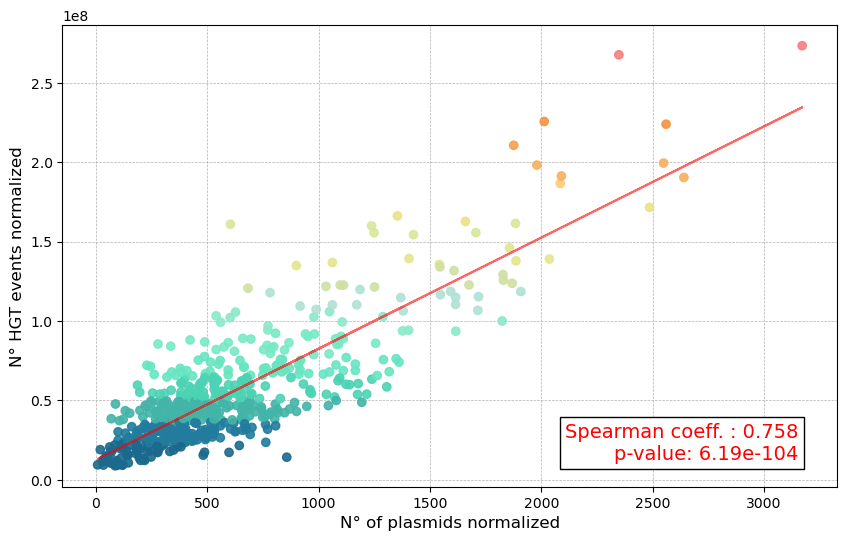

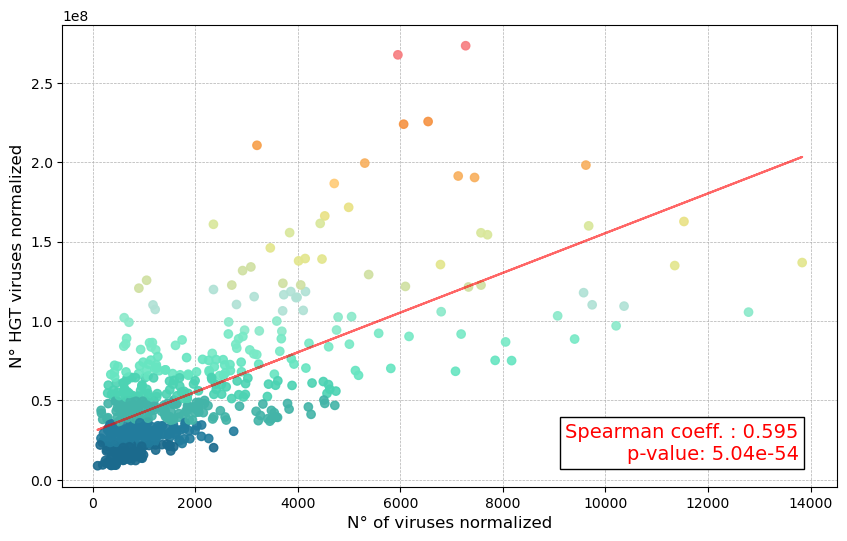

In [21]:
# correlation between richness and plasmids
#spearman_correlation_scatter(df, "richness", "plasmids", size="medium", title="Correlation between plasmids and richness")
spearman_correlation_scatter(df, "n_of_reads", "plasmids", size="medium", title="Correlation between plasmids and depth of sequencing", xlab="N° of plasmids normalized",ylab="N° HGT events normalized", map=custom_cmap)
#spearman_correlation_scatter(df, "richness", "viruses", size="medium", title="Correlation between viruses and richness")
spearman_correlation_scatter(df, "n_of_reads", "viruses", size="medium", title="Correlation between viruses and depth of sequencing", xlab="N° of viruses normalized",ylab="N° HGT viruses normalized", map=custom_cmap)
#spearman_correlation_scatter(df, "richness", "mge_total", size="medium", title="Correlation between mge and richness")
#spearman_correlation_scatter(df, "n_of_reads", "mge_total", size="medium", title="Correlation between mge and depth of sequencing")

The correlation study suggests that we need to normalize our data. We will normalize by sequencing depth

# Correlation number of MGE - number of HGT

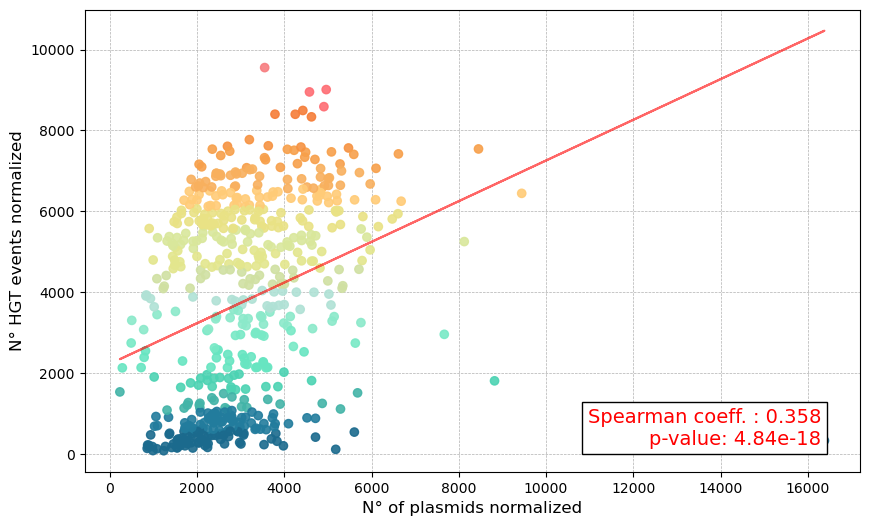

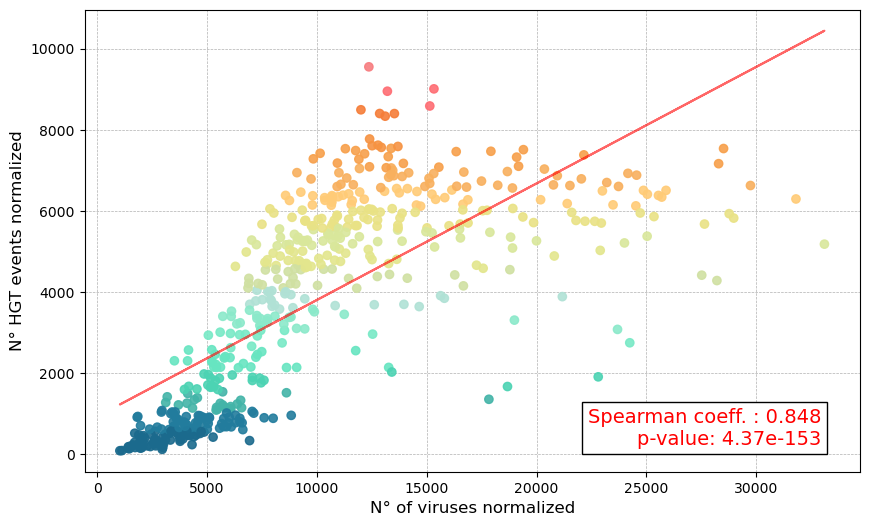

In [22]:
spearman_correlation_scatter(df, "HGT_depth", "plasmids_depth", size="medium", title="HGT events normalized by depth vs identified plasmids normalized by depth", xlab="N° of plasmids normalized",ylab="N° HGT events normalized", map=custom_cmap)
spearman_correlation_scatter(df, "HGT_depth", "viruses_depth", size="medium", title="HGT events normalized by depth vs identified viruses normalized by depth", xlab="N° of viruses normalized",ylab="N° HGT events normalized", map=custom_cmap)

The plot suggest that there is a correlation between number of plasmids/viruses and number of HGT events (milder for plasmids). This means that samples with more HGT events tend to have more mges.

# **Total MGEs analisys**

## Overall distribution

In [23]:
plot_box_swarm_and_histogram(df, 'mge_total', 'Box plot of mge per sample', 'Histogram of HGT events per sample',dataset_colors[0], dataset_colors[1], 'N° of MGE', 'N° of MGE','N° of samples')
plot_box_swarm_and_histogram(df, 'mge_total_depth', 'Box Plot of mge normalized by sequencing depth per sample', 'Histogram of HGT events normalized by sequencing depth per sample',dataset_colors[4], dataset_colors[5], 'N° of MGE normalized', 'N° of MGE normalized','N° of samples')

TypeError: plot_box_swarm_and_histogram() missing 1 required positional argument: 'ylabel_hist'

## Distribution by country

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Tanzania v.s. Ghana: Mann-Whitney-Wilcoxon test two-sided, P_val=1.337e-03 U_stat=3.049e+04


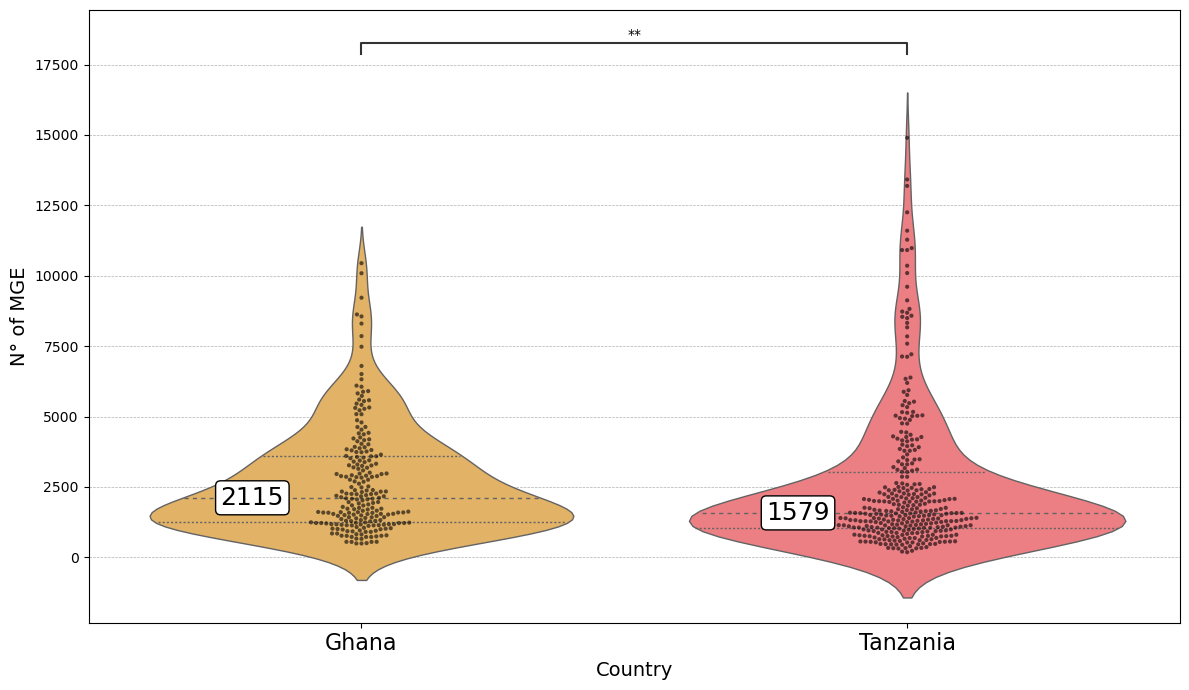

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Tanzania v.s. Ghana: Mann-Whitney-Wilcoxon test two-sided, P_val=2.831e-02 U_stat=4.036e+04


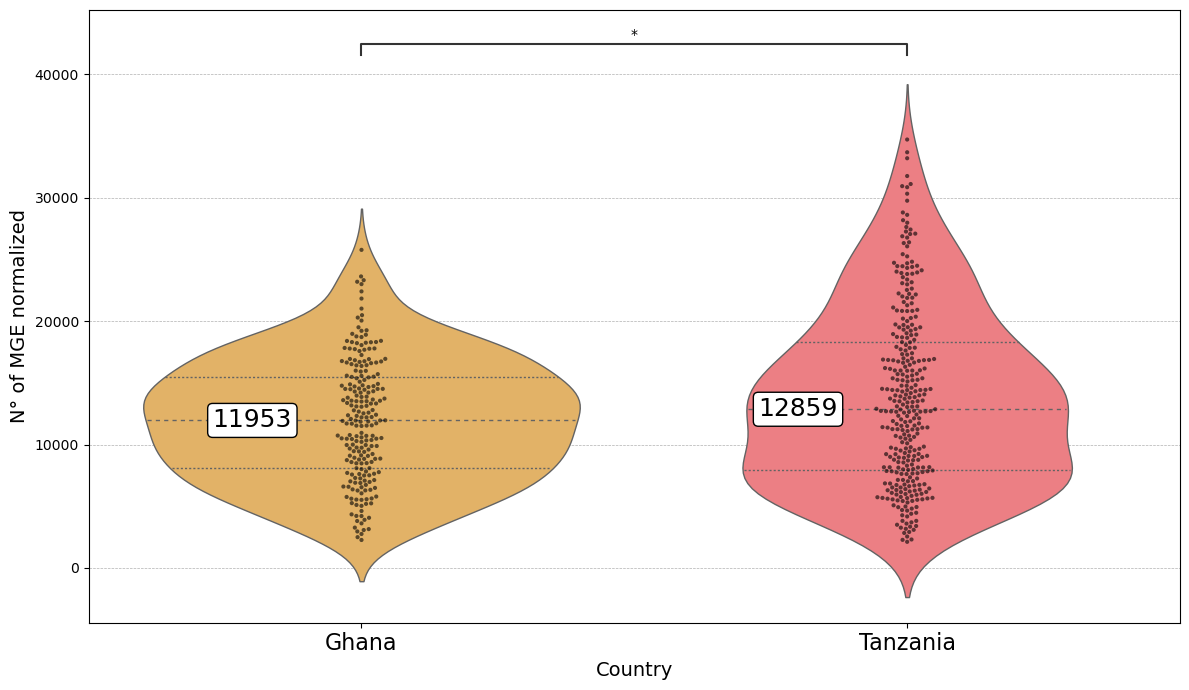

In [ ]:
plot_violin_swarm_with_annotations(df, 'country', 'mge_total', 'HGT events distribution per country', 'Country', 'N° of MGE', custom_order=["Ghana", "Tanzania"], palette=states_color, pairs=[('Ghana', 'Tanzania')])
plot_violin_swarm_with_annotations(df, 'country', 'mge_total_depth', 'HGT events distribution per country', 'Country', 'N° of MGE normalized', custom_order=["Ghana", "Tanzania"], palette=states_color, pairs=[('Ghana', 'Tanzania')])

In [ ]:
#Count the amount of mge_total per country
df_country_mge = df.groupby('country')['mge_total'].sum().reset_index()
df_country_mge_depth = df.groupby('country')['mge_total_depth'].sum().reset_index()

print(df_country_mge)
print(df_country_mge_depth)
print(df_ghana.shape)
print(df_tanzania.shape)

    country  mge_total
0     Ghana     593654
1  Tanzania     838520
    country  mge_total_depth
0     Ghana     2.650412e+06
1  Tanzania     4.536775e+06
(221, 28)
(329, 28)


The results suggest that there is a difference in the distribution of mge events between ghana and tanzania. This indicates that we may need to do separate plots for the two countries. Ask Mireia.

## Distribution of plamids per sex divided by country

## Confunder Analysis
Could richness be a confunder? A variable that has an effect both on the dipendent and the indipendent variables, being the indipendent the sex and the dependent HGT events. To analyse this we use general linear model. We compute a null GLM in which we study HGT + sex and an hypothetical GLM in which we asses HGT + sex + richness

First we need to asses if there's a signifcant difference between the richness distributions of our categories

### Richness plots

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

males_GH v.s. females_GH: Mann-Whitney-Wilcoxon test two-sided, P_val=8.163e-03 U_stat=3.050e+02
males_TZ v.s. females_TZ: Mann-Whitney-Wilcoxon test two-sided, P_val=9.222e-01 U_stat=1.930e+03
males v.s. females: Mann-Whitney-Wilcoxon test two-sided, P_val=1.182e-01 U_stat=4.002e+03


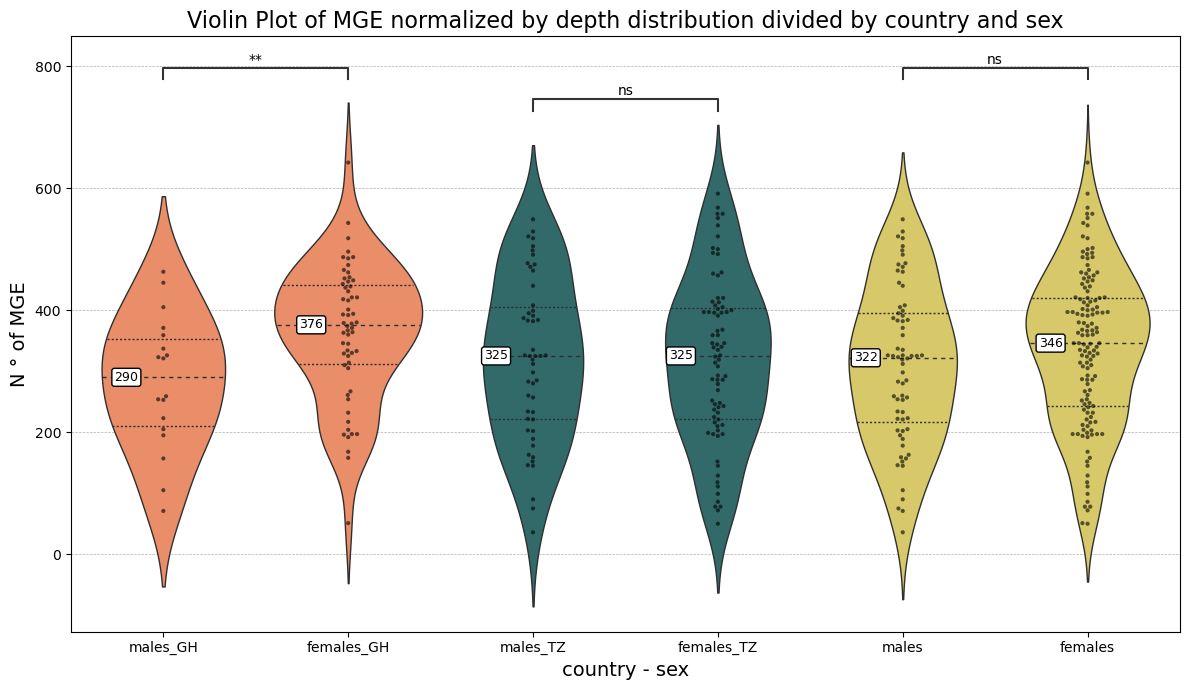

In [ ]:
plot_violin_swarm_with_annotations(df_sex_plot, x='dataset', y='richness', title='Violin Plot of MGE normalized by depth distribution divided by country and sex', x_label='country - sex', y_label='N ° of MGE', custom_order=['males_GH', 'females_GH', 'males_TZ', 'females_TZ', 'males', 'females'], palette=sex_nation_colors,pairs=[("males_GH", "females_GH"), ("males_TZ", "females_TZ"), ("males", "females")])

### Confunder analysis with GLM models (HGT~sex) (HGT~sex+richness)

In [ ]:
confounder_analysis(df_dogs, 'mge_total', 'sex', 'richness')

Null Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:              mge_total   No. Observations:                  204
Model:                            GLM   Df Residuals:                      202
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                      2.5293e+05
Method:                          IRLS   Log-Likelihood:                -1557.4
Date:                Mon, 02 Sep 2024   Deviance:                   5.1093e+07
Time:                        11:57:08   Pearson chi2:                 5.11e+07
No. Iterations:                     3   Pseudo R-squ. (CS):            0.01905
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1329.5294     43.

/tmp/ipykernel_637/1654002582.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[primary_independent_var] = df[primary_independent_var].astype('category')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

males_GH v.s. females_GH: Mann-Whitney-Wilcoxon test two-sided, P_val=9.297e-02 U_stat=3.840e+02
males_TZ v.s. females_TZ: Mann-Whitney-Wilcoxon test two-sided, P_val=3.585e-01 U_stat=1.762e+03
males v.s. females: Mann-Whitney-Wilcoxon test two-sided, P_val=1.127e-01 U_stat=3.993e+03


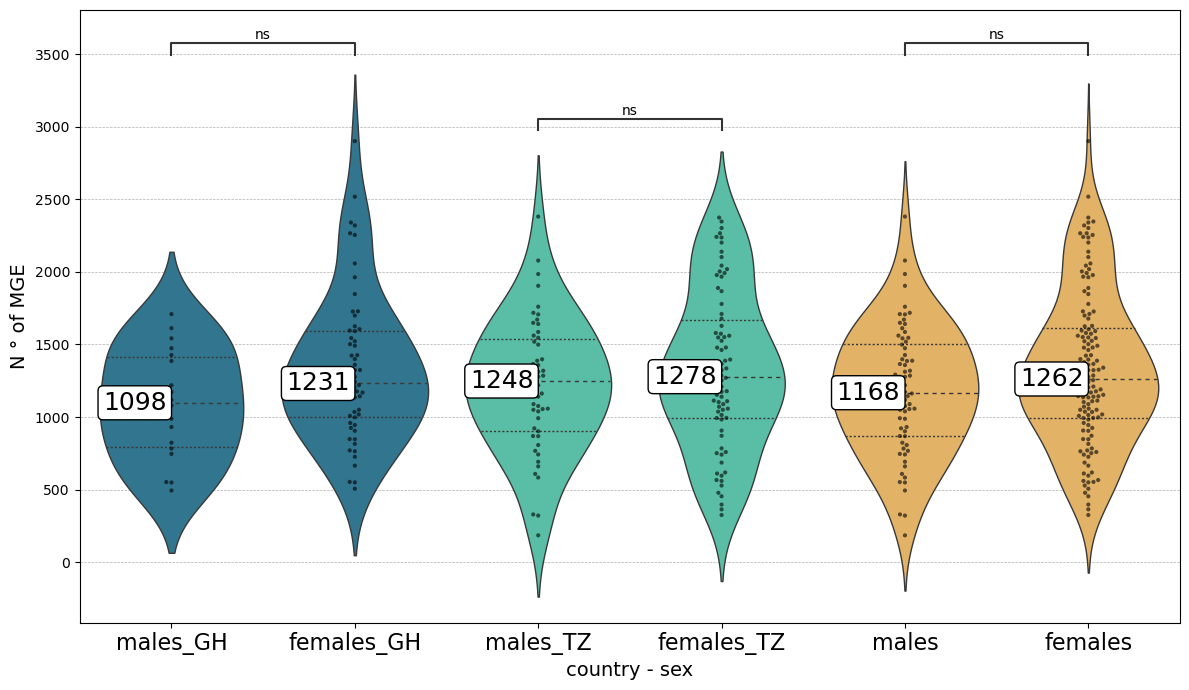

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

males_GH v.s. females_GH: Mann-Whitney-Wilcoxon test two-sided, P_val=3.823e-01 U_stat=4.500e+02
males_TZ v.s. females_TZ: Mann-Whitney-Wilcoxon test two-sided, P_val=4.050e-01 U_stat=1.779e+03
males v.s. females: Mann-Whitney-Wilcoxon test two-sided, P_val=2.200e-01 U_stat=4.136e+03


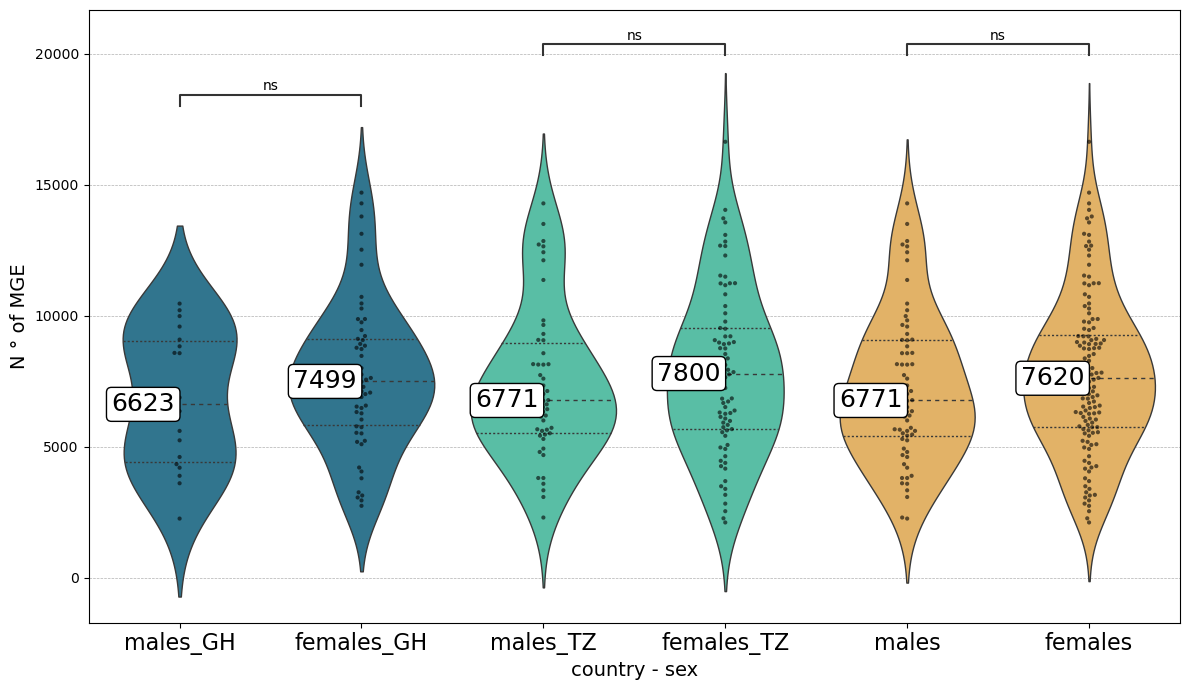

In [ ]:
plot_violin_swarm_with_annotations(df_sex_plot, x='dataset', y='mge_total', title='Violin Plot of MGE distribution divided by country and sex', x_label='country - sex', y_label='N ° of MGE', custom_order=['males_GH', 'females_GH', 'males_TZ', 'females_TZ', 'males', 'females'], palette=sex_nation_colors,pairs=[("males_GH", "females_GH"), ("males_TZ", "females_TZ"), ("males", "females")])
plot_violin_swarm_with_annotations(df_sex_plot, x='dataset', y='mge_total_depth', title='Violin Plot of MGE normalized by depth distribution divided by country and sex', x_label='country - sex', y_label='N ° of MGE', custom_order=['males_GH', 'females_GH', 'males_TZ', 'females_TZ', 'males', 'females'], palette=sex_nation_colors,pairs=[("males_GH", "females_GH"), ("males_TZ", "females_TZ"), ("males", "females")])

## Distribution of MGE per species

In [ ]:
groups = [df_humans,df_dogs,df_cows,df_goats,df_sheeps]
names_list=["humans","dogs","cows","goats","sheeps"]

dunn_species=perform_kruskal_dunn(groups,"mge_total",names_list)
dunn_species_depth=perform_kruskal_dunn(groups,"mge_total_depth",names_list)

Kruskal-Wallis test result: H-statistic = 144.94287438515678, p-value = 2.4670233891494466e-30
Kruskal-Wallis test is significant, performing Dunn test...
Significant Dunn test results (Bonferroni corrected):
              1   2             3             4             5
1           NaN NaN  1.416160e-23  3.548671e-21  1.711044e-07
2           NaN NaN           NaN           NaN           NaN
3  1.416160e-23 NaN           NaN           NaN           NaN
4  3.548671e-21 NaN           NaN           NaN           NaN
5  1.711044e-07 NaN           NaN           NaN           NaN
humans cows 1.4161602325838618e-23
humans goats 3.548670727192368e-21
humans sheeps 1.7110442711266865e-07
Kruskal-Wallis test result: H-statistic = 313.4657266345994, p-value = 1.348045389858062e-66
Kruskal-Wallis test is significant, performing Dunn test...
Significant Dunn test results (Bonferroni corrected):
              1   2             3             4             5
1           NaN NaN  7.224801e-61  4.949687

## Confunder Analysis
Could richness be a confunder? We will perform the same steps as before

### Richness plot

Kruskal-Wallis test result: H-statistic = 246.74984950301192, p-value = 3.2635014214400796e-52
Kruskal-Wallis test is significant, performing Dunn test...
Significant Dunn test results (Bonferroni corrected):
              1         2             3             4             5
1           NaN       NaN  3.194751e-45  1.547828e-23  6.574153e-12
2           NaN       NaN  1.532076e-06  4.527743e-04  1.294167e-04
3  3.194751e-45  0.000002           NaN  2.945644e-05           NaN
4  1.547828e-23  0.000453  2.945644e-05           NaN           NaN
5  6.574153e-12  0.000129           NaN           NaN           NaN
humans cows 3.1947507849944286e-45
humans goats 1.5478280806714753e-23
humans sheeps 6.574153269307059e-12
dogs cows 1.5320763146672112e-06
dogs goats 0.00045277427909069486
dogs sheeps 0.00012941674966082984
cows goats 2.9456438554749435e-05
[('cow', 'human'), ('goat', 'human'), ('sheep', 'human'), ('cow', 'dog'), ('goat', 'dog'), ('sheep', 'dog'), ('goat', 'cow')]
[3.19475078499

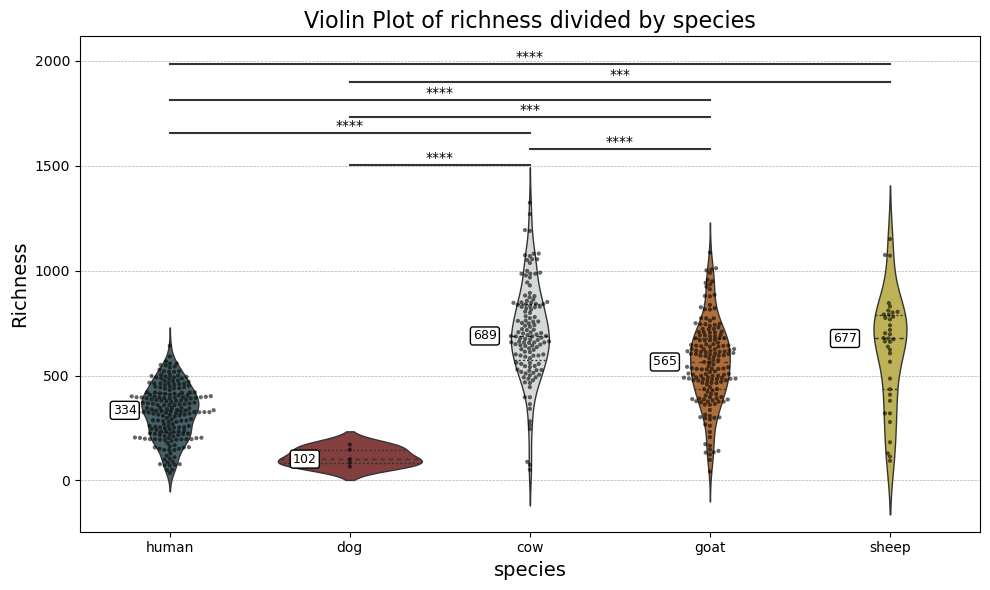

In [ ]:
groups = [df_humans,df_dogs,df_cows,df_goats,df_sheeps]
names_list=["humans","dogs","cows","goats","sheeps"]

dunn_richness_species=perform_kruskal_dunn(groups,"richness",names_list)
plot_violin_swarm_with_annotations_animals(df_all_species, x='species', y='richness', significant_results=dunn_richness_species, title='Violin Plot of richness divided by species', x_label='species', y_label='Richness', custom_order = ["human", "dog",  "cow","goat", "sheep"], palette=species_colors,names=["human","dog","cow","goat","sheep"])

There is a difference in the richness distributions between humans/dogs vs all the other animals; there s also a difference in richness between cows and goats

### Confunder analysis with GLM models (HGT~species) (HGT~species+richness)

In [ ]:
confounder_analysis(df_all_species, 'mge_total', 'country', 'species')

Null Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:              mge_total   No. Observations:                  550
Model:                            GLM   Df Residuals:                      548
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                      5.3948e+06
Method:                          IRLS   Log-Likelihood:                -5042.2
Date:                Mon, 02 Sep 2024   Deviance:                   2.9563e+09
Time:                        11:57:11   Pearson chi2:                 2.96e+09
No. Iterations:                     3   Pseudo R-squ. (CS):          0.0008489
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept     

In [ ]:
confounder_analysis(df_all_species, 'mge_total', 'species', 'richness')

Null Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:              mge_total   No. Observations:                  550
Model:                            GLM   Df Residuals:                      545
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                      4.1681e+06
Method:                          IRLS   Log-Likelihood:                -4969.7
Date:                Mon, 02 Sep 2024   Deviance:                   2.2716e+09
Time:                        11:57:11   Pearson chi2:                 2.27e+09
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2590
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         41

## Plots

[('cows', 'humans'), ('goats', 'humans'), ('sheep', 'humans'), ('cows', 'dogs'), ('goats', 'cows'), ('sheep', 'cows')]
[0.0003183223693454043, 6.862021744231814e-18, 4.399277876616133e-05, 0.002837521671924151, 7.039437050054714e-32, 4.8925973051580354e-11]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

dogs v.s. cows: Custom statistical test, P_val:2.838e-03
cows v.s. goats: Custom statistical test, P_val:7.039e-32
humans v.s. cows: Custom statistical test, P_val:3.183e-04
cows v.s. sheep: Custom statistical test, P_val:4.893e-11
humans v.s. goats: Custom statistical test, P_val:6.862e-18
humans v.s. sheep: Custom statistical test, P_val:4.399e-05


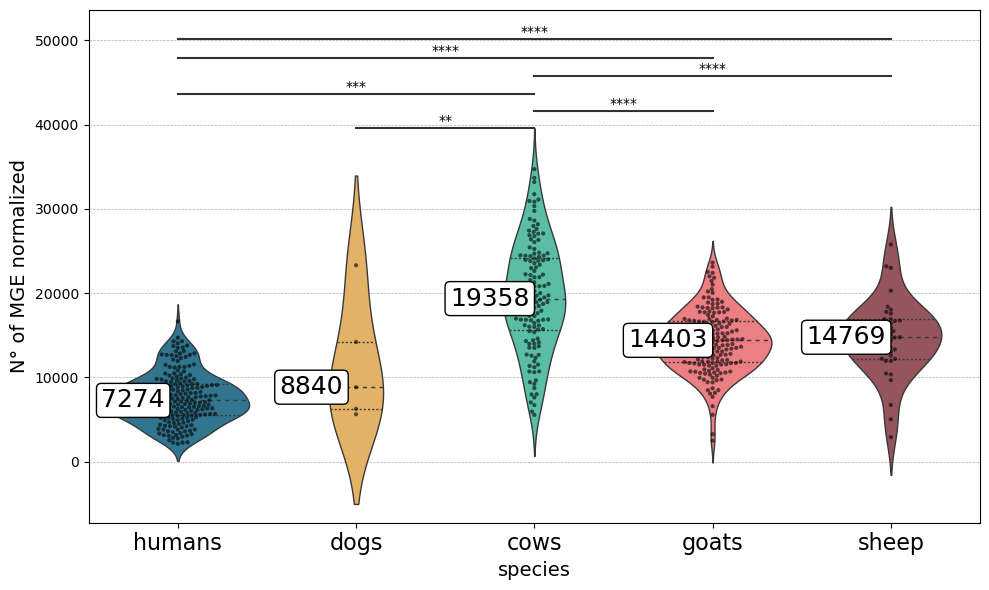

In [ ]:
#plot_violin_swarm_with_annotations_animals(df_all_species, x='species', y='mge_total', significant_results=dunn_species, title='Violin Plot of MGE divided by species', x_label='species', y_label='N° of MGE', custom_order = ["humans", "dogs",  "cows","goats", "sheep"], palette=species_colors,names=["human","dog","cow","goat","sheep"])
plot_violin_swarm_with_annotations_animals(df_all_species, x='species', y='mge_total_depth', significant_results=dunn_species_depth, title='Violin Plot of MGE normalized by depth distribution divided by species', x_label='species', y_label='N° of MGE normalized', custom_order = ["humans", "dogs",  "cows","goats", "sheep"], palette=species_colors,names=["humans","dogs","cows","goats","sheep"])

## Distribution of HGT events humans vs animals

## Confunder analysis

### Richness plot

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

human v.s. animal: Mann-Whitney-Wilcoxon test two-sided, P_val=3.581e-46 U_stat=9.610e+03


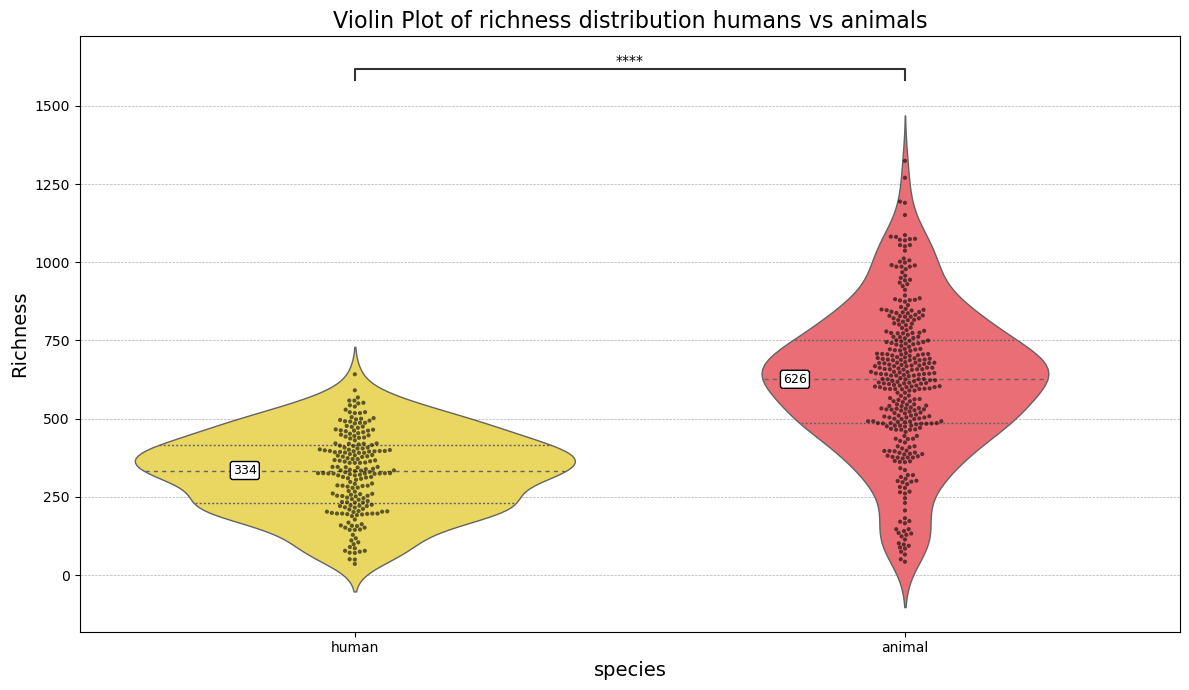

In [ ]:
plot_violin_swarm_with_annotations(df_binomial_species, x='species', y='richness', title='Violin Plot of richness distribution humans vs animals', x_label='species', y_label='Richness', custom_order=["human","animal"],  palette=humans_animals_colors, pairs=[("human", "animal")])

### Confunder analysis with GLM models (HGT(depth)~species) (HGT(depth)~species+richness)

In [ ]:
confounder_analysis(df_binomial_species, 'mge_total', 'species', 'richness')

Null Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:              mge_total   No. Observations:                  550
Model:                            GLM   Df Residuals:                      548
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                      4.3625e+06
Method:                          IRLS   Log-Likelihood:                -4983.8
Date:                Mon, 02 Sep 2024   Deviance:                   2.3907e+09
Time:                        11:57:15   Pearson chi2:                 2.39e+09
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2109
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         33

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

humans v.s. animals: Mann-Whitney-Wilcoxon test two-sided, P_val=3.721e-63 U_stat=5.092e+03


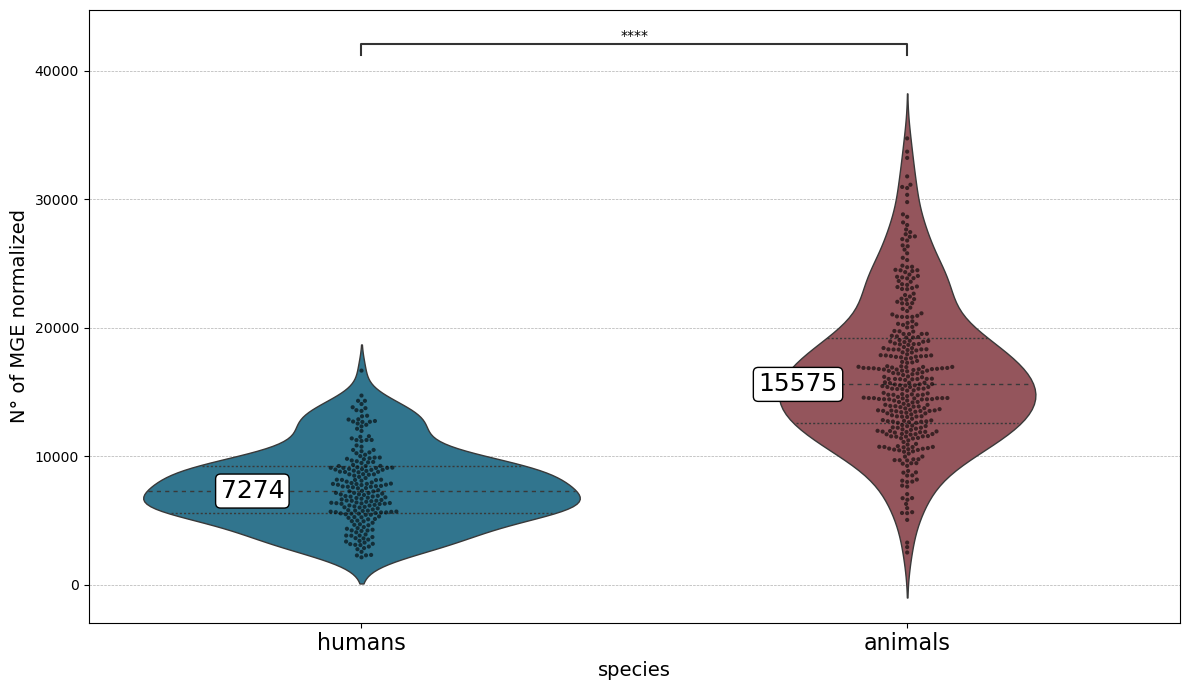

In [ ]:
#plot_violin_swarm_with_annotations(df_binomial_species, x='species', y='mge_total', title='Violin Plot of MGE distribution humans vs animals', x_label='species', y_label='N° of MGE', custom_order=["human","animal"],  palette=humans_animals_colors, pairs=[("human", "animal")])
plot_violin_swarm_with_annotations(df_binomial_species, x='species', y='mge_total_depth', title='Violin Plot of MGE normalized by depth humans vs animals', x_label='species', y_label='N° of MGE normalized', custom_order=["humans","animals"],  palette=humans_animals_colors, pairs=[("humans", "animals")])


## Distribution of HGT events per family role

In [ ]:
groups = [df_mother,df_father,df_sibling,df_grandmother,df_grandfather, df_aunt, df_uncle, df_cousin]
names_list=["mothers","fathers","siblings","grandmothers","grandfathers","aunts","uncles","cousins"]
dunn_family=perform_kruskal_dunn(groups,"mge_total",names_list)
dunn_family_depth=perform_kruskal_dunn(groups,"mge_total_depth",names_list)

Kruskal-Wallis test result: H-statistic = 17.404304211104947, p-value = 0.01496716216450936
Kruskal-Wallis test is significant, performing Dunn test...
Significant Dunn test results (Bonferroni corrected):
    1   2         3         4   5   6   7   8
1 NaN NaN       NaN       NaN NaN NaN NaN NaN
2 NaN NaN       NaN       NaN NaN NaN NaN NaN
3 NaN NaN       NaN  0.010351 NaN NaN NaN NaN
4 NaN NaN  0.010351       NaN NaN NaN NaN NaN
5 NaN NaN       NaN       NaN NaN NaN NaN NaN
6 NaN NaN       NaN       NaN NaN NaN NaN NaN
7 NaN NaN       NaN       NaN NaN NaN NaN NaN
8 NaN NaN       NaN       NaN NaN NaN NaN NaN
siblings grandmothers 0.010350756953299088
Kruskal-Wallis test result: H-statistic = 19.178963428189036, p-value = 0.007644821776979876
Kruskal-Wallis test is significant, performing Dunn test...
Significant Dunn test results (Bonferroni corrected):
    1   2         3         4   5   6   7   8
1 NaN NaN       NaN       NaN NaN NaN NaN NaN
2 NaN NaN       NaN       NaN NaN NaN 

[('grandmother', 'sibling')]
[0.010350756953299088]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

sibling v.s. grandmother: Custom statistical test, P_val:1.035e-02


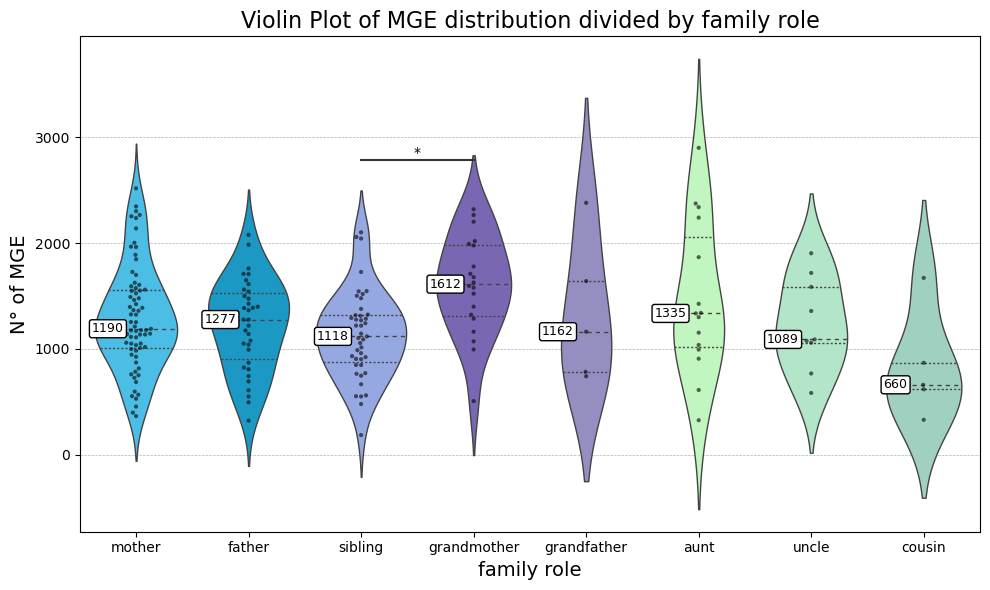

[('grandmother', 'sibling')]
[0.00551082663459756]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

sibling v.s. grandmother: Custom statistical test, P_val:5.511e-03


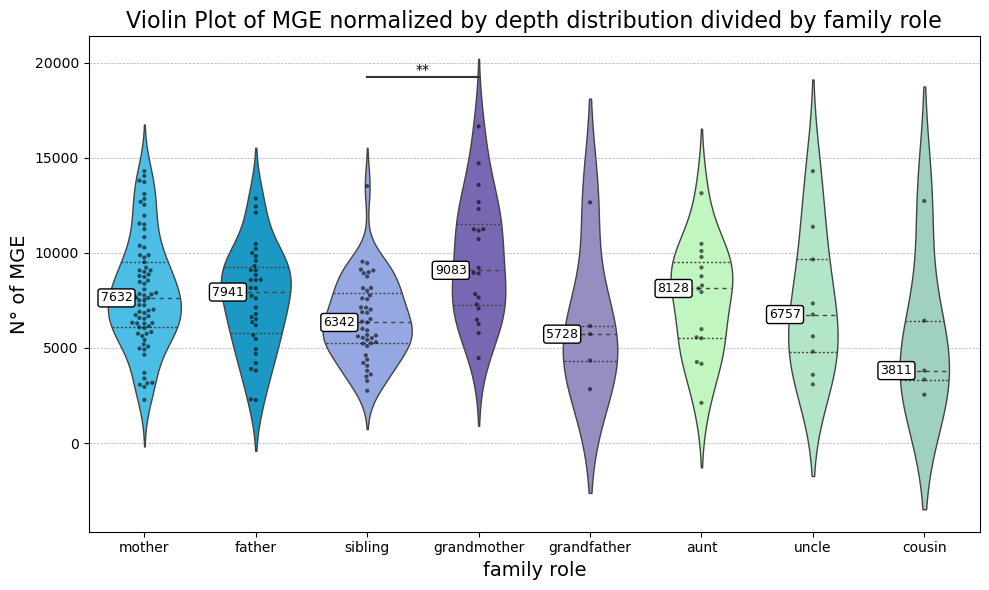

In [ ]:
plot_violin_swarm_with_annotations_animals(df_family_role, x='family_role', y='mge_total', significant_results=dunn_family, title='Violin Plot of MGE distribution divided by family role', x_label='family role', y_label='N° of MGE', custom_order = ["mother", "father",  "sibling","grandmother", "grandfather","aunt","uncle","cousin"], palette=family_colors, names = ["mother", "father",  "sibling","grandmother", "grandfather","aunt","uncle","cousin"])
plot_violin_swarm_with_annotations_animals(df_family_role, x='family_role', y='mge_total_depth', significant_results=dunn_family_depth, title='Violin Plot of MGE normalized by depth distribution divided by family role', x_label='family role', y_label='N° of MGE', custom_order = ["mother", "father",  "sibling","grandmother", "grandfather","aunt","uncle","cousin"], palette=family_colors, names = ["mother", "father",  "sibling","grandmother", "grandfather","aunt","uncle","cousin"])

## Distribution of HGT events by age

In [ ]:
groups = [df_newborn, df_child, df_schoolage, df_adult, df_senior]
names_list=["newborns","children","schoolage","adults","seniors"]
dunn_age=perform_kruskal_dunn(groups,"mge_total",names_list)
dunn_age_depth=perform_kruskal_dunn(groups,"mge_total_depth",names_list)

Kruskal-Wallis test result: H-statistic = 14.189052989513563, p-value = 0.006715490522640372
Kruskal-Wallis test is significant, performing Dunn test...
Significant Dunn test results (Bonferroni corrected):
    1         2   3         4   5
1 NaN       NaN NaN       NaN NaN
2 NaN       NaN NaN  0.008029 NaN
3 NaN       NaN NaN       NaN NaN
4 NaN  0.008029 NaN       NaN NaN
5 NaN       NaN NaN       NaN NaN
children adults 0.008028530075574523
Kruskal-Wallis test result: H-statistic = 22.902033169238166, p-value = 0.00013246205755009993
Kruskal-Wallis test is significant, performing Dunn test...
Significant Dunn test results (Bonferroni corrected):
    1         2   3         4   5
1 NaN       NaN NaN       NaN NaN
2 NaN       NaN NaN  0.000305 NaN
3 NaN       NaN NaN       NaN NaN
4 NaN  0.000305 NaN       NaN NaN
5 NaN       NaN NaN       NaN NaN
children adults 0.000305368260789215


## Confunder analysis

### Richness plot

In [ ]:
confounder_analysis(df_all_species, 'mge_total', 'country', 'age_years')

Null Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:              mge_total   No. Observations:                  550
Model:                            GLM   Df Residuals:                      548
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                      5.3948e+06
Method:                          IRLS   Log-Likelihood:                -5042.2
Date:                Mon, 02 Sep 2024   Deviance:                   2.9563e+09
Time:                        11:57:19   Pearson chi2:                 2.96e+09
No. Iterations:                     3   Pseudo R-squ. (CS):          0.0008489
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept     

In [ ]:
groups = [df_newborn, df_child, df_schoolage, df_adult, df_senior]
names_list=["newborns","children","school-age","adults","seniors"]
dunn_age_richness=perform_kruskal_dunn(groups,"richness",names_list)

Kruskal-Wallis test result: H-statistic = 12.552088542538604, p-value = 0.013684972772611567
Kruskal-Wallis test is significant, performing Dunn test...
Significant Dunn test results (Bonferroni corrected):
    1   2   3   4   5
1 NaN NaN NaN NaN NaN
2 NaN NaN NaN NaN NaN
3 NaN NaN NaN NaN NaN
4 NaN NaN NaN NaN NaN
5 NaN NaN NaN NaN NaN


[('adult', 'child')]
[0.01775679008400737]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

child v.s. adult: Custom statistical test, P_val:1.776e-02


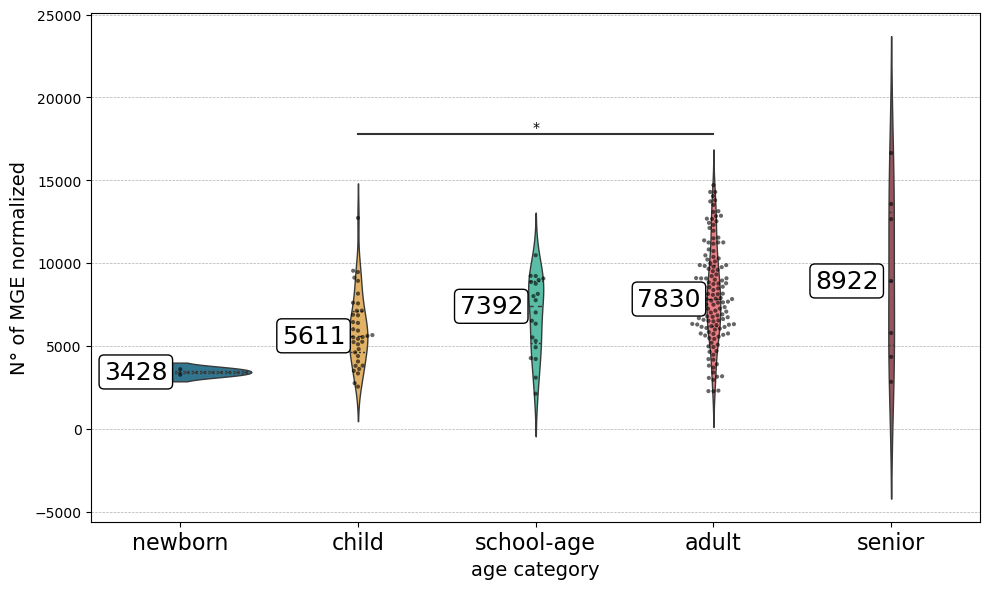

In [ ]:
#plot_violin_swarm_with_annotations_animals(df_age, x='dataset', y='mge_total', significant_results=dunn_age, title='Violin Plot of MGE distribution divided by age', x_label='age category', y_label='N° of MGE', custom_order = ["newborn","child","schoolage","adult","senior"], palette=age_colors, names = ["newborn","child","schoolage","adult","senior"])
plot_violin_swarm_with_annotations_animals(df_age, x='dataset', y='mge_total_depth', significant_results=dunn_age_depth, title='Violin Plot of MGE normalized by depth distribution divided by age', x_label='age category', y_label='N° of MGE normalized', custom_order = ["newborn","child","school-age","adult","senior"], palette=age_colors, names = ["newborn","child","schoolage","adult","senior"])

### Age as a continuum

In [ ]:
df_humans_copy2=df_humans.copy()

#from df_humans_cop2 remove rows that have Nan values in column age_years
df_humans_copy2.dropna(subset = ["age_years"], inplace=True)

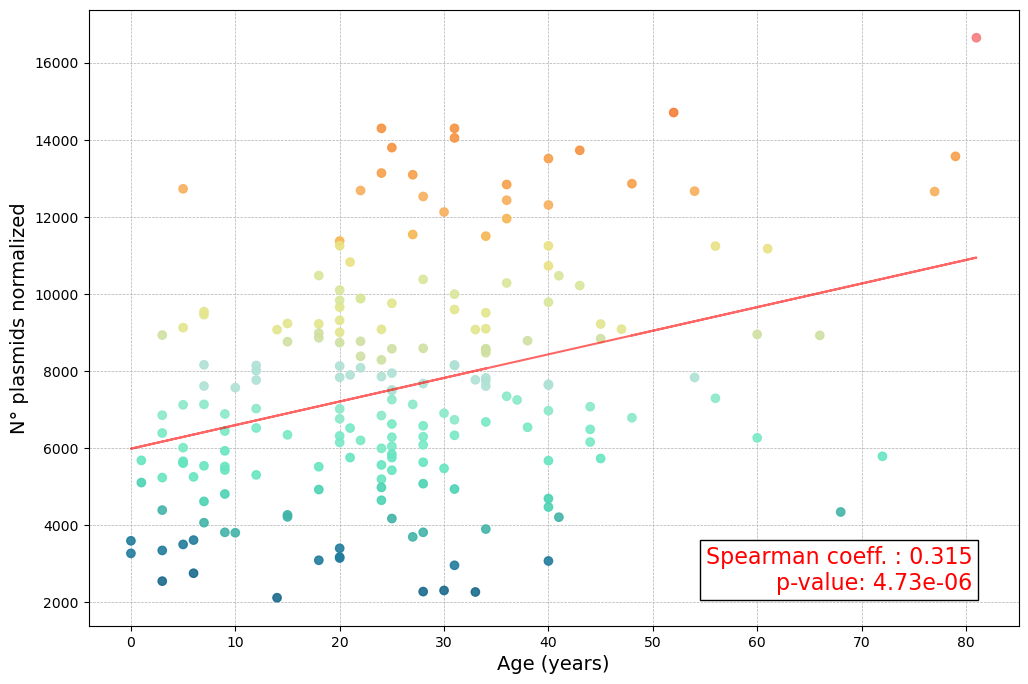

In [ ]:
spearman_correlation_scatter(df_humans_copy2, "mge_total_depth", "age_years", "big","", xlab="Age (years)",ylab="N° plasmids normalized", map=custom_cmap)

# **Plasmids analysis**

## 0) Overall distribution

In [24]:
plot_box_swarm_and_histogram(df, 'plasmids_depth', 'Box Plot of plasmids normalized by sequencing depth per sample', 'Histogram of plasmids normalized by sequencing depth per sample',dataset_colors[4], dataset_colors[5], 'N° of plasmids normalized', 'N° of plasmids normalized','N° of samples')

TypeError: plot_box_swarm_and_histogram() missing 1 required positional argument: 'ylabel_hist'

## 1) Distribution of plasmids by country

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Tanzania v.s. Ghana: Mann-Whitney-Wilcoxon test two-sided, P_val=3.747e-22 U_stat=1.867e+04


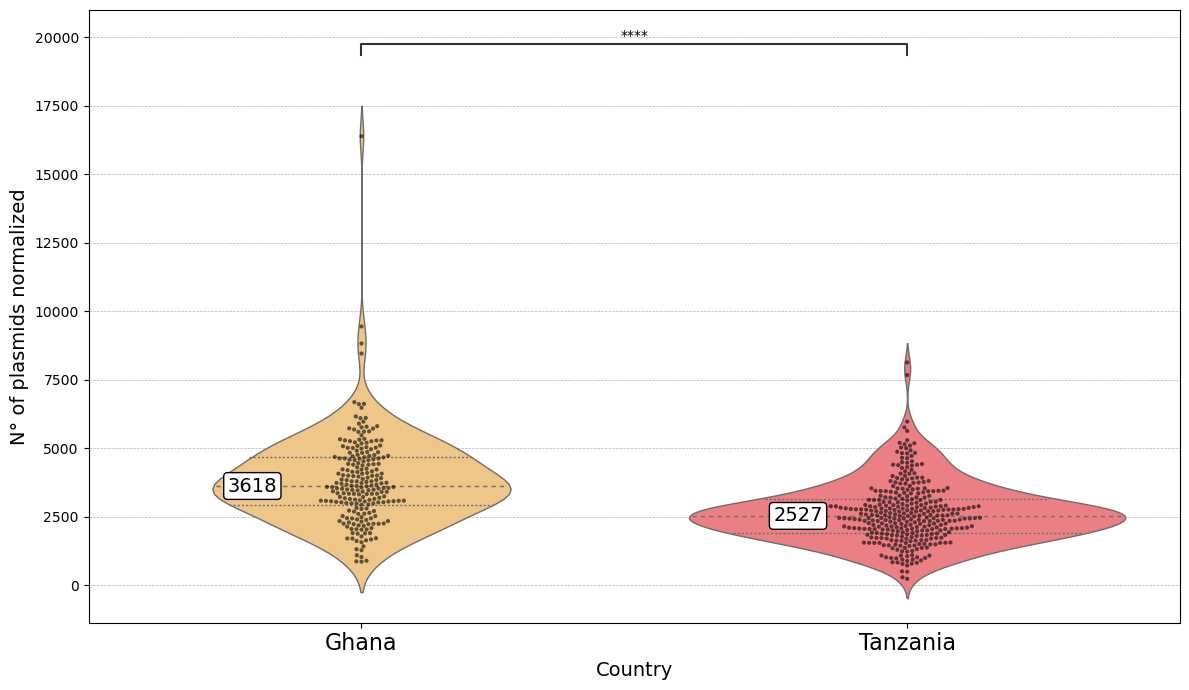

In [25]:
plot_violin_swarm_with_annotations(df, 'country', 'plasmids_depth', 'Plasmids distribution per country', 'Country', 'N° of plasmids normalized', custom_order=["Ghana", "Tanzania"], palette=states_color, pairs=[('Ghana', 'Tanzania')])

In [ ]:
# Count the amount of plasmids per country
df_country_plasmids = df.groupby('country')['plasmids'].sum().reset_index()
df_country_plasmids_depth = df.groupby('country')['plasmids_depth'].sum().reset_index()

print(df_country_plasmids)
print(df_country_plasmids_depth)
print(df_ghana.shape)
print(df_tanzania.shape)

    country  plasmids
0     Ghana    184787
1  Tanzania    150835
    country  plasmids_depth
0     Ghana   839483.193591
1  Tanzania   868497.783312
(221, 28)
(329, 28)


## 2) Distribution of plamids per sex divided by country

### - Confunder analysis with GLM models (HGT~country) (HGT~country+sex)
Skipped because no sex difference

### - Confunder analysis with GLM models (HGT~sex) (HGT~sex+richness)

In [ ]:
confounder_analysis(df_humans, 'plasmids', 'sex', 'richness')

Null Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:               plasmids   No. Observations:                  204
Model:                            GLM   Df Residuals:                      202
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          30538.
Method:                          IRLS   Log-Likelihood:                -1341.8
Date:                Mon, 02 Sep 2024   Deviance:                   6.1686e+06
Time:                        11:57:25   Pearson chi2:                 6.17e+06
No. Iterations:                     3   Pseudo R-squ. (CS):            0.01309
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     476.5368     14.

### - Plot

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

males_GH v.s. females_GH: Mann-Whitney-Wilcoxon test two-sided, P_val=9.367e-01 U_stat=5.290e+02
males_TZ v.s. females_TZ: Mann-Whitney-Wilcoxon test two-sided, P_val=1.435e-01 U_stat=1.650e+03
males v.s. females: Mann-Whitney-Wilcoxon test two-sided, P_val=2.326e-01 U_stat=4.149e+03


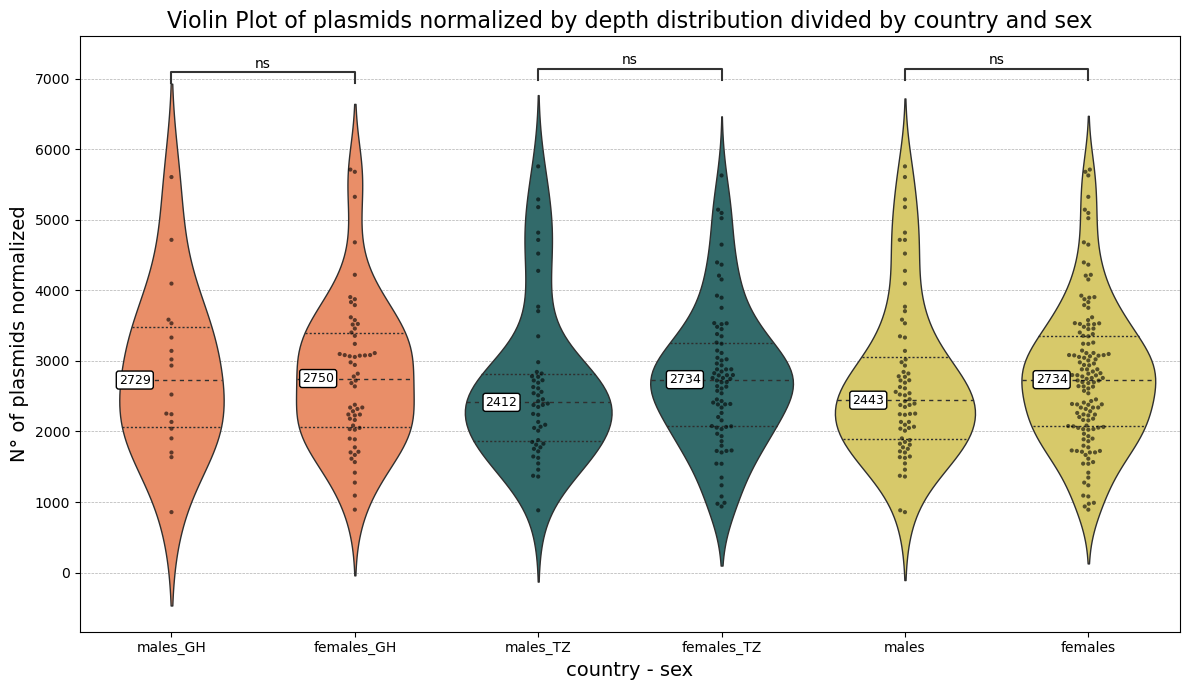

In [ ]:
plot_violin_swarm_with_annotations(df_sex_plot, x='dataset', y='plasmids_depth', title='Violin Plot of plasmids normalized by depth distribution divided by country and sex', x_label='country - sex', y_label='N° of plasmids normalized', custom_order=['males_GH', 'females_GH', 'males_TZ', 'females_TZ', 'males', 'females'], palette=sex_nation_colors,pairs=[("males_GH", "females_GH"), ("males_TZ", "females_TZ"), ("males", "females")])

## 3) Distribution of HGT events humans vs animals

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

humans v.s. animals: Mann-Whitney-Wilcoxon test two-sided, P_val=1.147e-05 U_stat=2.739e+04


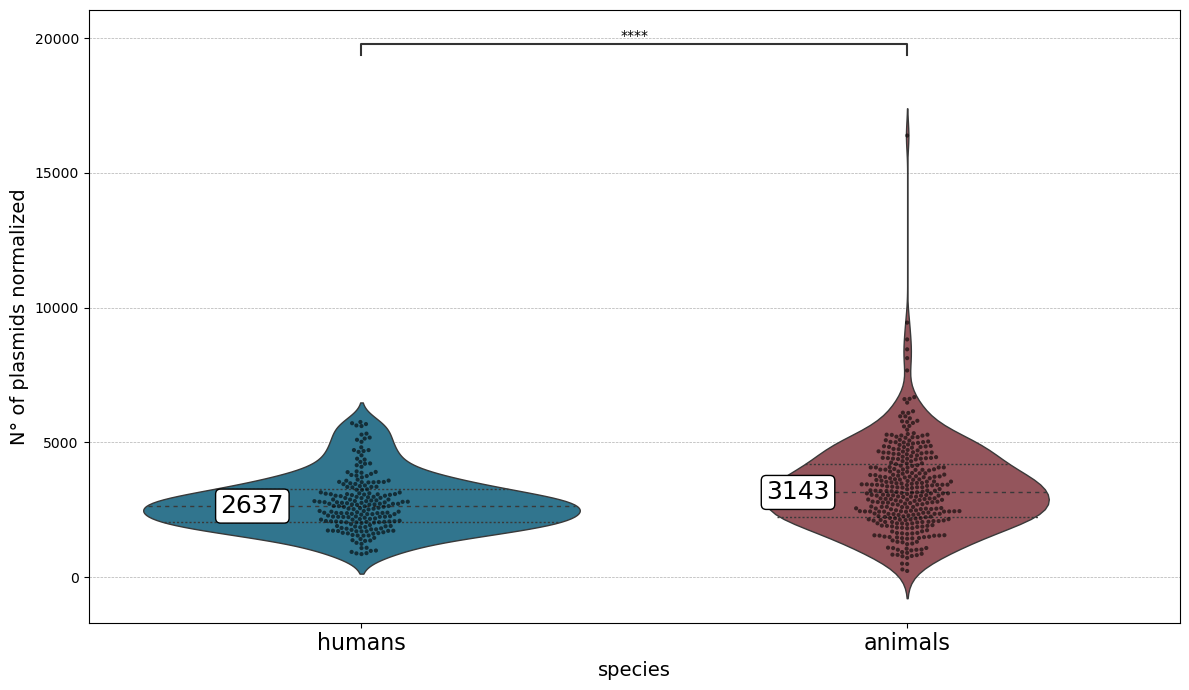

In [ ]:
plot_violin_swarm_with_annotations(df_binomial_species, x='species', y='plasmids_depth', title='Violin Plot of plasmids normalized by depth humans vs animals', x_label='species', y_label='N° of plasmids normalized', custom_order=["humans","animals"],  palette=humans_animals_colors, pairs=[("humans", "animals")])

## 4) Distribution of plasmids per species

### - Confunder analysis with GLM models (HGT~country) (HGT~country+species)

In [ ]:
confounder_analysis(df_all_species, 'plasmids', 'species', 'country')

Null Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:               plasmids   No. Observations:                  550
Model:                            GLM   Df Residuals:                      545
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                      1.8109e+05
Method:                          IRLS   Log-Likelihood:                -4107.3
Date:                Mon, 02 Sep 2024   Deviance:                   9.8691e+07
Time:                        11:57:27   Pearson chi2:                 9.87e+07
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1692
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          4

### - Confunder analysis with GLM models (HGT~species) (HGT~species+richness)

In [ ]:
confounder_analysis(df_all_species, 'plasmids', 'species', 'richness')

Null Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:               plasmids   No. Observations:                  550
Model:                            GLM   Df Residuals:                      545
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                      1.8109e+05
Method:                          IRLS   Log-Likelihood:                -4107.3
Date:                Mon, 02 Sep 2024   Deviance:                   9.8691e+07
Time:                        11:57:27   Pearson chi2:                 9.87e+07
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1692
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          4

### - Plot

In [26]:
groups = [df_humans,df_dogs,df_cows,df_goats,df_sheeps]
names_list=["humans","dogs","cows","goats","sheeps"]
dunn_species_depth=perform_kruskal_dunn(groups,"plasmids_depth",names_list)

Kruskal-Wallis test result: H-statistic = 173.3618281064912, p-value = 1.9854657920627305e-36
Kruskal-Wallis test is significant, performing Dunn test...
Significant Dunn test results (Bonferroni corrected):
              1         2             3             4             5
1           NaN       NaN  3.183224e-04  6.862022e-18  4.399278e-05
2           NaN       NaN  2.837522e-03           NaN           NaN
3  3.183224e-04  0.002838           NaN  7.039437e-32  4.892597e-11
4  6.862022e-18       NaN  7.039437e-32           NaN           NaN
5  4.399278e-05       NaN  4.892597e-11           NaN           NaN
humans cows 0.0003183223693454043
humans goats 6.862021744231814e-18
humans sheeps 4.399277876616133e-05
dogs cows 0.002837521671924151
cows goats 7.039437050054714e-32
cows sheeps 4.8925973051580354e-11


[('Cows', 'Humans'), ('Goats', 'Humans'), ('Sheep', 'Humans'), ('Cows', 'Dogs'), ('Goats', 'Cows'), ('Sheep', 'Cows')]
[0.0003183223693454043, 6.862021744231814e-18, 4.399277876616133e-05, 0.002837521671924151, 7.039437050054714e-32, 4.8925973051580354e-11]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Dogs v.s. Cows: Custom statistical test, P_val:2.838e-03
Cows v.s. Goats: Custom statistical test, P_val:7.039e-32
Humans v.s. Cows: Custom statistical test, P_val:3.183e-04
Cows v.s. Sheep: Custom statistical test, P_val:4.893e-11
Humans v.s. Goats: Custom statistical test, P_val:6.862e-18
Humans v.s. Sheep: Custom statistical test, P_val:4.399e-05


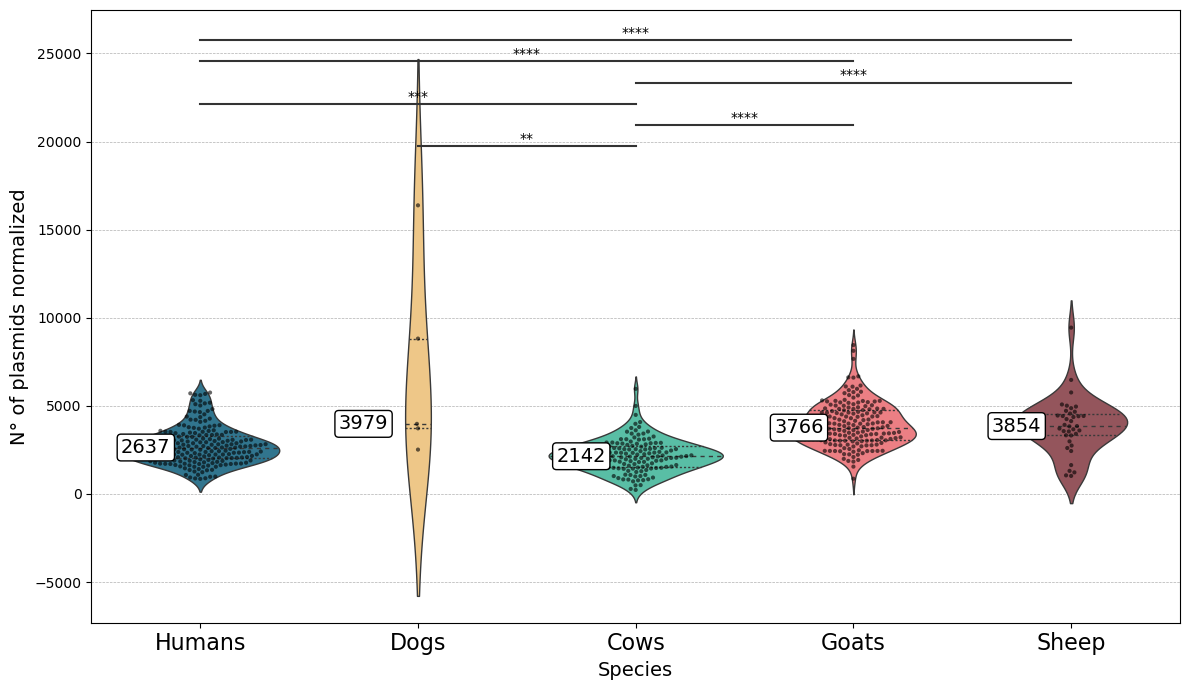

In [27]:
plot_violin_swarm_with_annotations_animals(df_all_species, x='species', y='plasmids_depth', significant_results=dunn_species_depth, title='Violin Plot of plasmids normalized by depth distribution divided by species', x_label='Species', y_label='N° of plasmids normalized', custom_order = ["Humans", "Dogs",  "Cows","Goats", "Sheep"], palette=species_colors,names=["Humans","Dogs","Cows","Goats","Sheep"])

## 5) Distribution of plasmids per family role

In [ ]:
groups = [df_mother,df_father,df_sibling,df_grandmother,df_grandfather, df_aunt, df_uncle, df_cousin]
names_list=["mothers","fathers","siblings","grandmothers","grandfathers","aunts","uncles","cousins"]
dunn_family_depth=perform_kruskal_dunn(groups,"plasmids_depth",names_list)

Kruskal-Wallis test result: H-statistic = 13.63602900364208, p-value = 0.05804679681291421
Kruskal-Wallis test is not significant, skipping Dunn test.


In [ ]:
#plot_violin_swarm_with_annotations_animals(df_family_role, x='family_role', y='plasmids_depth', significant_results=dunn_family_depth, title='Violin Plot of plasmids normalized by depth distribution divided by family role', x_label='family role', y_label='N° of plasmids', custom_order = ["mother", "father",  "sibling","grandmother", "grandfather","aunt","uncle","cousin"], palette=family_colors, names = ["mother", "father",  "sibling","grandmother", "grandfather","aunt","uncle","cousin"])

## 6) Distribution of HGT events by age

### - Confunder analysis with GLM models (HGT~country) (HGT~country+species)

In [ ]:
confounder_analysis(df_all_species, 'plasmids', 'country', 'age_years')

Null Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:               plasmids   No. Observations:                  550
Model:                            GLM   Df Residuals:                      548
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                      1.7937e+05
Method:                          IRLS   Log-Likelihood:                -4106.2
Date:                Mon, 02 Sep 2024   Deviance:                   9.8297e+07
Time:                        11:57:33   Pearson chi2:                 9.83e+07
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1740
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept     

### - Confunder analysis with GLM models (HGT~species) (HGT~species+richness)
Skipped cause no difference in richness

### - Plot

In [28]:
groups = [df_newborn, df_child, df_schoolage, df_adult, df_senior]
names_list=["newborns","children","schoolage","adults","seniors"]
dunn_age_depth=perform_kruskal_dunn(groups,"plasmids_depth",names_list)

Kruskal-Wallis test result: H-statistic = 15.722414469696105, p-value = 0.003415182923230592
Kruskal-Wallis test is significant, performing Dunn test...
Significant Dunn test results (Bonferroni corrected):
    1         2   3         4   5
1 NaN       NaN NaN       NaN NaN
2 NaN       NaN NaN  0.017757 NaN
3 NaN       NaN NaN       NaN NaN
4 NaN  0.017757 NaN       NaN NaN
5 NaN       NaN NaN       NaN NaN
children adults 0.01775679008400737


[('Adult', 'Child')]
[0.01775679008400737]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Child v.s. Adult: Custom statistical test, P_val:1.776e-02


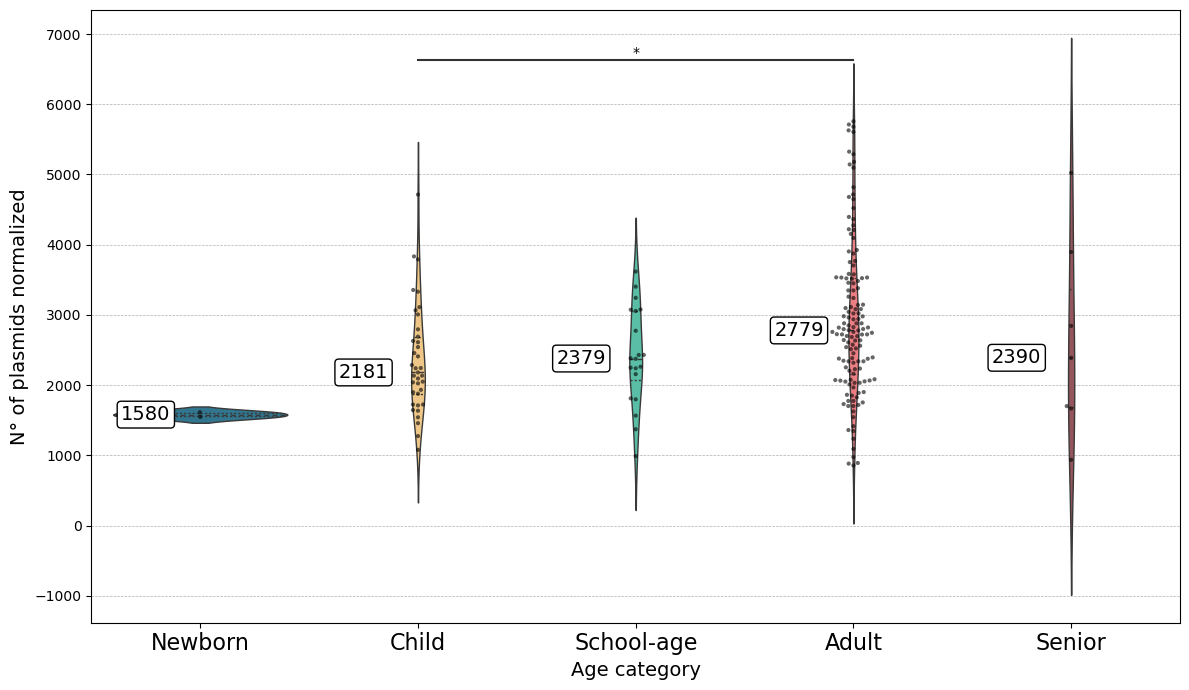

In [29]:
plot_violin_swarm_with_annotations_animals(df_age, x='dataset', y='plasmids_depth', significant_results=dunn_age_depth, title='Violin Plot of plasmids normalized by depth distribution divided by age', x_label='Age category', y_label='N° of plasmids normalized', custom_order = ["Newborn","Child","School-age","Adult","Senior"], palette=age_colors, names = ["Newborn","Child","Schoolage","Adult","Senior"])

### - Age as a continuum

In [ ]:
df_humans_copy2=df_humans.copy()

#from df_humans_cop2 remove rows that have Nan values in column age_years
df_humans_copy2.dropna(subset = ["age_years"], inplace=True)

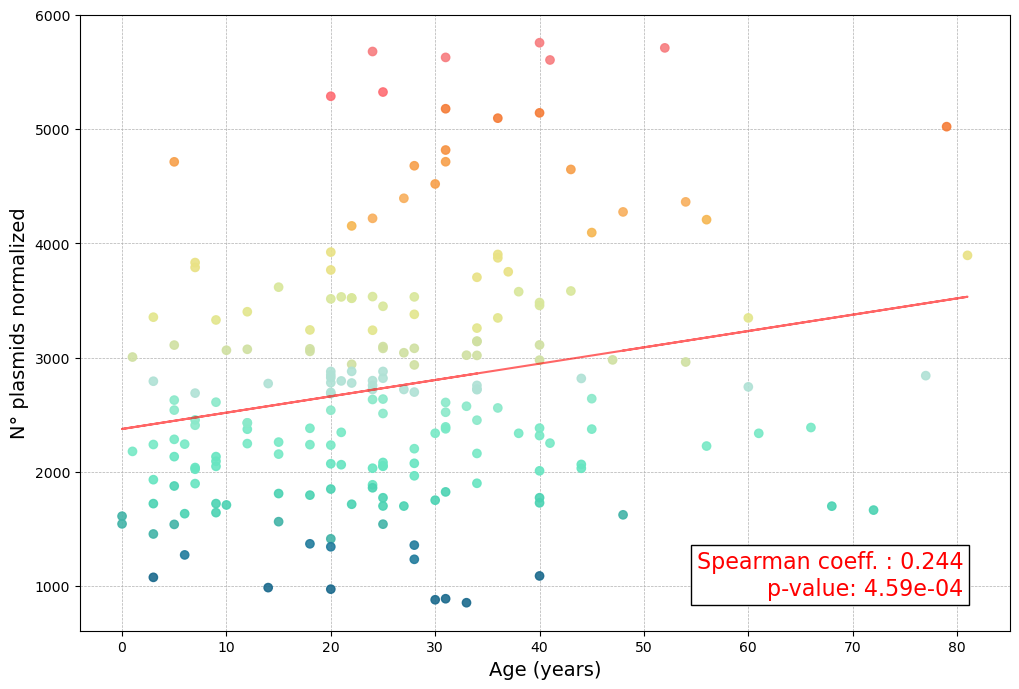

In [ ]:
spearman_correlation_scatter(df_humans_copy2, "plasmids_depth", "age_years", "big","", xlab="Age (years)",ylab="N° plasmids normalized", map=custom_cmap)

## 7) Plasmids ARG genes analysis

### - ARG distribution

#### 0) convert the ARM finder code in the right format

In [30]:
# %%bash
# sed -E 's/^([^\t]+)\.[0-9]+/\1/' /home/giacomo/Thesis-Internship/NCBIfam-AMRFinder.tsv > /home/giacomo/Thesis-Internship/NCBIfam-AMRFinder_cleaned.tsv

In [37]:
#### 2) Extract gene functions and names from gene codes
#open the file NCBIfam-AMRFinder_cleaned.tsv as a pandas df and merge it with the df_plasmids
df_ARG=pd.read_csv("/home/giacomo/Thesis-Internship/NCBIfam-AMRFinder_cleaned.tsv",sep="\t")
df_ARG=df_ARG.rename(columns={"#Family":"ARG"})
df_ARG=df_ARG[["#hmm_accession","hmm_description","gene_symbol","scope"]]
df_ARG.rename(columns={"#hmm_accession":"ARG"},inplace=True)
df_ARG=df_ARG.merge(df_plasmids,on="ARG",how="inner")
df_ARG=df_ARG.sort_values(by="count",ascending=False, ignore_index=True)
df_ARG.head(10)

ARG                                    hmm_description gene_symbol  \
0  NF000402  vancomycin resistance response regulator trans...      vanR-B   
1  NF040806  OXA-198 family carbapenem-hydrolyzing class D ...      blaOXA   
2  NF012174  Tet(A)/Tet(B)/Tet(C) family tetracycline efflu...         tet   
3  NF033693  AAC(6')-Ie family aminoglycoside N-acetyltrans...  aac(6')-Ie   
4  NF000496      fosfomycin resistance glutathione transferase         fos   
5  NF000261        NimABCDEF family 5-nitroimidazole reductase         nim   
6  NF033135  Cmx/CmrA family chloramphenicol efflux MFS tra...         cml   
7  NF033105                 subclass B3 metallo-beta-lactamase         bla   
8  NF000051            macrolide efflux MFS transporter Mef(B)      mef(B)   
9  NF000272  multidrug efflux RND transporter periplasmic a...        oqxA   

  scope  count  
0  core   2029  
1  core    574  
2  core    479  
3  core    439  
4  core    343  
5  core    274  
6  core    239  
7  core    204  
8  core    188  
9  core    187

#### 1) ARG in humans

In [38]:
#extract all the samples that are "human" from df
df_humans=df[df["species"]=="human"]
#extract column sampleID and turn it into a list
humans_samples=df_humans["sampleID"].tolist()


In [39]:
# for all files in folder /home/giacomo/Thesis-Internship/waafle/mge_data/plasmids go trough each row and extract last column
ARG=[]
for samples in humans_samples:
    for file in os.listdir('/home/giacomo/Thesis-Internship/waafle/mge_data/plasmids/'):
        if samples in file:
            with open('/home/giacomo/Thesis-Internship/waafle/mge_data/plasmids/' + file) as fn:
                #skip first row
                next(fn)
                for line in fn:
                    line=line.rstrip()
                    arg=line.split("\t")[-1]
                    if arg=="NA":
                        ARG.append("unclassified")
                    else:
                        if ";" in arg:
                            arg=arg.split(";")
                            for a in arg:
                                ARG.append(a)
                        else:
                            ARG.append(arg)
print(len(ARG))
#create a dataframe with the extracted data
df_plasmids_humans=pd.DataFrame(ARG,columns=["ARG"])
df_plasmids_humans=df_plasmids_humans.value_counts().reset_index(name='count')
#df_plasmids_humans

94550


In [42]:
#### 2) Extract gene functions and names from gene codes
#open the file NCBIfam-AMRFinder_cleaned.tsv as a pandas df and merge it with the df_plasmids
df_ARG_humans=pd.read_csv("/home/giacomo/Thesis-Internship/NCBIfam-AMRFinder_cleaned.tsv",sep="\t")
df_ARG_humans=df_ARG_humans.rename(columns={"#Family":"ARG"})
df_ARG_humans=df_ARG_humans[["#hmm_accession","hmm_description","gene_symbol","scope"]]
df_ARG_humans.rename(columns={"#hmm_accession":"ARG"},inplace=True)
df_ARG_humans=df_ARG_humans.merge(df_plasmids_humans,on="ARG",how="inner")
df_ARG_humans=df_ARG_humans.sort_values(by="count",ascending=False, ignore_index=True)
df_ARG_humans.head(10)

ARG                                    hmm_description gene_symbol  \
0  NF000402  vancomycin resistance response regulator trans...      vanR-B   
1  NF040806  OXA-198 family carbapenem-hydrolyzing class D ...      blaOXA   
2  NF012174  Tet(A)/Tet(B)/Tet(C) family tetracycline efflu...         tet   
3  NF000261        NimABCDEF family 5-nitroimidazole reductase         nim   
4  NF000496      fosfomycin resistance glutathione transferase         fos   
5  NF033135  Cmx/CmrA family chloramphenicol efflux MFS tra...         cml   
6  NF000237  PBP2a family beta-lactam-resistant peptidoglyc...         mec   
7  NF000272  multidrug efflux RND transporter periplasmic a...        oqxA   
8  NF033693  AAC(6')-Ie family aminoglycoside N-acetyltrans...  aac(6')-Ie   
9  NF012171  APH(6)-I family aminoglycoside O-phosphotransf...    aph(6)-I   

  scope  count  
0  core    985  
1  core    279  
2  core    258  
3  core    188  
4  core    134  
5  core    117  
6  core    113  
7  core     97  
8  core     92  
9  core     73

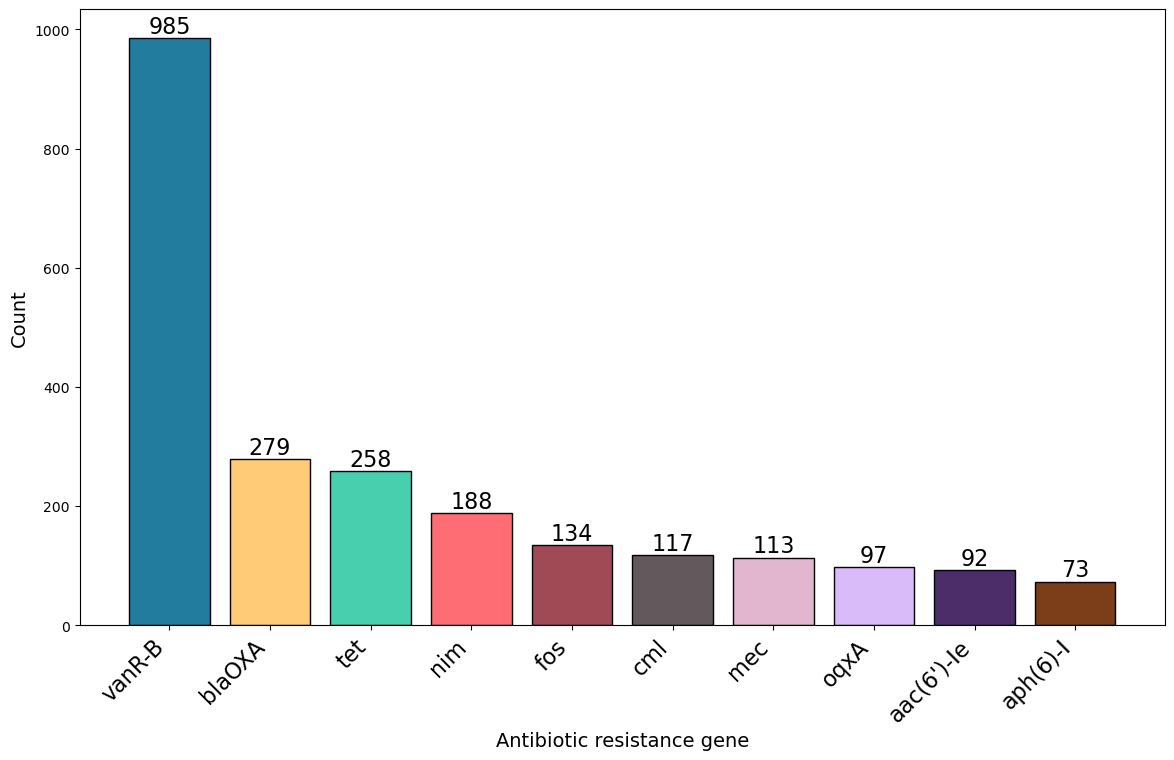

In [44]:
#plot the distribution of ARGs
df_ARG_top10_humans=df_ARG_humans.head(10)
plt.figure(figsize=(14, 8))
plt.bar(df_ARG_top10_humans["gene_symbol"],df_ARG_top10_humans["count"], color=top10_lca_colors, edgecolor='black', linewidth=1)
plt.xlabel('Antibiotic resistance gene', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=16)
#plt.title('Top 10 ARG distribution')
for i, v in enumerate(df_ARG_top10_humans["count"]):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom',fontsize=16)

#### 1) ARG in dogs

In [48]:
#extract all the samples that are "human" from df
df_dogs=df[df["species"]=="dog"]
#extract column sampleID and turn it into a list
dogs_samples=df_dogs["sampleID"].tolist()


In [49]:
# for all files in folder /home/giacomo/Thesis-Internship/waafle/mge_data/plasmids go trough each row and extract last column
ARG=[]
for samples in dogs_samples:
    for file in os.listdir('/home/giacomo/Thesis-Internship/waafle/mge_data/plasmids/'):
        if samples in file:
            with open('/home/giacomo/Thesis-Internship/waafle/mge_data/plasmids/' + file) as fn:
                #skip first row
                next(fn)
                for line in fn:
                    line=line.rstrip()
                    arg=line.split("\t")[-1]
                    if arg=="NA":
                        ARG.append("unclassified")
                    else:
                        if ";" in arg:
                            arg=arg.split(";")
                            for a in arg:
                                ARG.append(a)
                        else:
                            ARG.append(arg)
print(len(ARG))
#create a dataframe with the extracted data
df_plasmids_dogs=pd.DataFrame(ARG,columns=["ARG"])
df_plasmids_dogs=df_plasmids_dogs.value_counts().reset_index(name='count')
#df_plasmids_humans

4762


In [50]:
#### 2) Extract gene functions and names from gene codes
#open the file NCBIfam-AMRFinder_cleaned.tsv as a pandas df and merge it with the df_plasmids
df_ARG_dogs=pd.read_csv("/home/giacomo/Thesis-Internship/NCBIfam-AMRFinder_cleaned.tsv",sep="\t")
df_ARG_dogs=df_ARG_dogs.rename(columns={"#Family":"ARG"})
df_ARG_dogs=df_ARG_dogs[["#hmm_accession","hmm_description","gene_symbol","scope"]]
df_ARG_dogs.rename(columns={"#hmm_accession":"ARG"},inplace=True)
df_ARG_dogs=df_ARG_dogs.merge(df_plasmids_dogs,on="ARG",how="inner")
df_ARG_dogs=df_ARG_dogs.sort_values(by="count",ascending=False, ignore_index=True)
df_ARG_dogs.head(10)

ARG                                    hmm_description gene_symbol  \
0  NF000402  vancomycin resistance response regulator trans...      vanR-B   
1  NF012174  Tet(A)/Tet(B)/Tet(C) family tetracycline efflu...         tet   
2  NF033135  Cmx/CmrA family chloramphenicol efflux MFS tra...         cml   
3  NF000272  multidrug efflux RND transporter periplasmic a...        oqxA   
4  NF040806  OXA-198 family carbapenem-hydrolyzing class D ...      blaOXA   
5  NF033105                 subclass B3 metallo-beta-lactamase         bla   
6  NF000025            tetracenomycin C efflux MFS transporter        tcmA   
7  NF000237  PBP2a family beta-lactam-resistant peptidoglyc...         mec   
8  NF000496      fosfomycin resistance glutathione transferase         fos   
9  NF000095  oxytetracycline resistance efflux MFS transpor...      otr(B)   

  scope  count  
0  core     36  
1  core     32  
2  core     24  
3  core     10  
4  core      8  
5  core      7  
6  core      6  
7  core      6  
8  core      6  
9  core      6

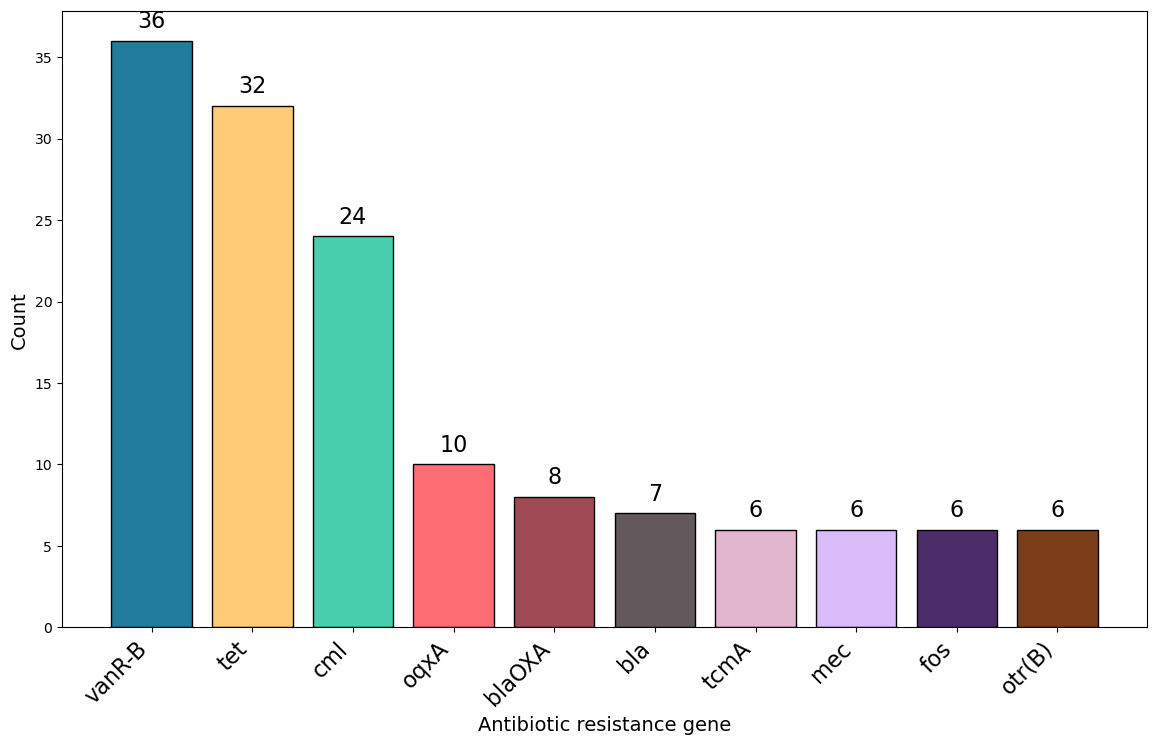

In [51]:
#plot the distribution of ARGs
df_ARG_top10_dogs=df_ARG_dogs.head(10)
plt.figure(figsize=(14, 8))
plt.bar(df_ARG_top10_dogs["gene_symbol"],df_ARG_top10_dogs["count"], color=top10_lca_colors, edgecolor='black', linewidth=1)
plt.xlabel('Antibiotic resistance gene', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=16)
#plt.title('Top 10 ARG distribution')
for i, v in enumerate(df_ARG_top10_dogs["count"]):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom',fontsize=16)

### 3) ARG in cows

In [52]:
#extract all the samples that are "human" from df
df_cows=df[df["species"]=="cow"]
#extract column sampleID and turn it into a list
cows_samples=df_cows["sampleID"].tolist()


In [53]:
# for all files in folder /home/giacomo/Thesis-Internship/waafle/mge_data/plasmids go trough each row and extract last column
ARG=[]
for samples in cows_samples:
    for file in os.listdir('/home/giacomo/Thesis-Internship/waafle/mge_data/plasmids/'):
        if samples in file:
            with open('/home/giacomo/Thesis-Internship/waafle/mge_data/plasmids/' + file) as fn:
                #skip first row
                next(fn)
                for line in fn:
                    line=line.rstrip()
                    arg=line.split("\t")[-1]
                    if arg=="NA":
                        ARG.append("unclassified")
                    else:
                        if ";" in arg:
                            arg=arg.split(";")
                            for a in arg:
                                ARG.append(a)
                        else:
                            ARG.append(arg)
print(len(ARG))
#create a dataframe with the extracted data
df_plasmids_cows=pd.DataFrame(ARG,columns=["ARG"])
df_plasmids_cows=df_plasmids_cows.value_counts().reset_index(name='count')
#df_plasmids_humans

61400


In [54]:
#### 2) Extract gene functions and names from gene codes
#open the file NCBIfam-AMRFinder_cleaned.tsv as a pandas df and merge it with the df_plasmids
df_ARG_cows=pd.read_csv("/home/giacomo/Thesis-Internship/NCBIfam-AMRFinder_cleaned.tsv",sep="\t")
df_ARG_cows=df_ARG_cows.rename(columns={"#Family":"ARG"})
df_ARG_cows=df_ARG_cows[["#hmm_accession","hmm_description","gene_symbol","scope"]]
df_ARG_cows.rename(columns={"#hmm_accession":"ARG"},inplace=True)
df_ARG_cows=df_ARG_cows.merge(df_plasmids_cows,on="ARG",how="inner")
df_ARG_cows=df_ARG_cows.sort_values(by="count",ascending=False, ignore_index=True)
df_ARG_cows.head(10)

ARG                                    hmm_description gene_symbol  \
0  NF000402  vancomycin resistance response regulator trans...      vanR-B   
1  NF033693  AAC(6')-Ie family aminoglycoside N-acetyltrans...  aac(6')-Ie   
2  NF012174  Tet(A)/Tet(B)/Tet(C) family tetracycline efflu...         tet   
3  NF033085                             class C beta-lactamase        ampC   
4  NF000051            macrolide efflux MFS transporter Mef(B)      mef(B)   
5  NF033068  APH(3') family aminoglycoside O-phosphotransfe...     aph(3')   
6  NF000138      aminoglycoside N-acetyltransferase AAC(6')-Iz  aac(6')-Iz   
7  NF033115                       D-Ala-D-Ala dipeptidase VanX        vanX   
8  NF040806  OXA-198 family carbapenem-hydrolyzing class D ...      blaOXA   
9  NF000153        lincosamide nucleotidyltransferase Lnu(AN2)    lnu(AN2)   

  scope  count  
0  core    162  
1  core     71  
2  core     34  
3  core     31  
4  core     30  
5  core     29  
6  core     26  
7  core     23  
8  core     23  
9  core     22

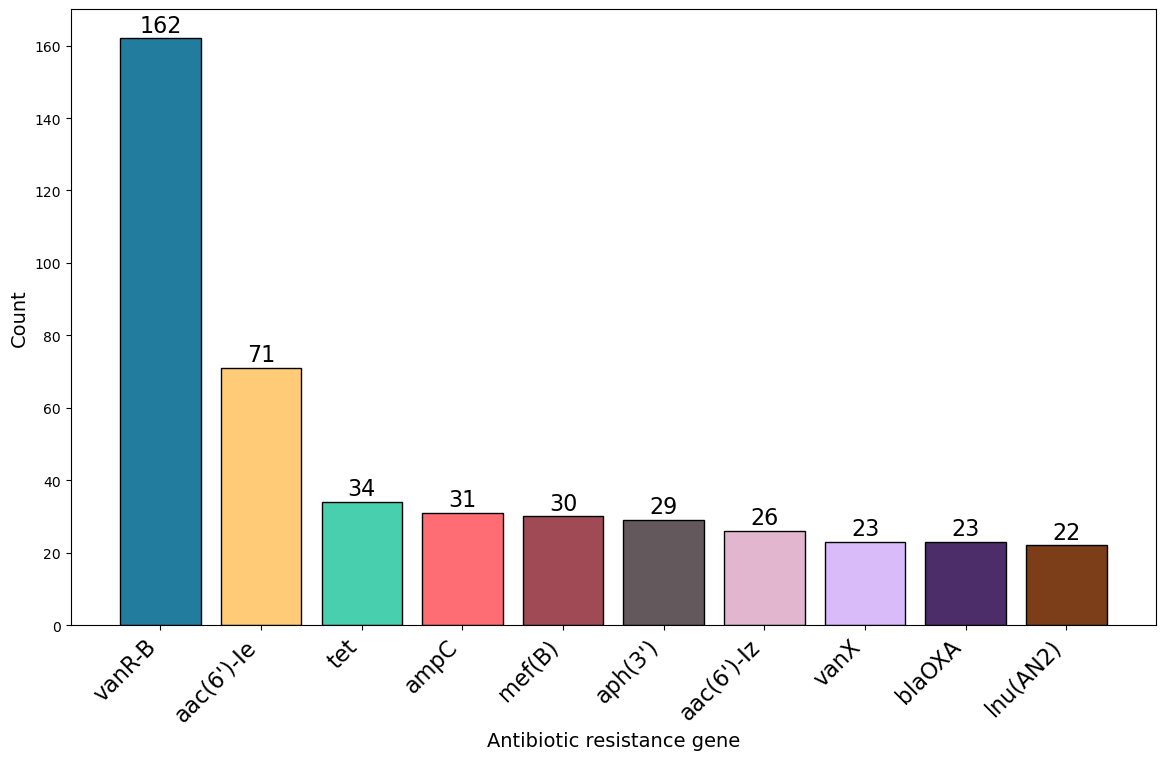

In [55]:
#plot the distribution of ARGs
df_ARG_top10_cows=df_ARG_cows.head(10)
plt.figure(figsize=(14, 8))
plt.bar(df_ARG_top10_cows["gene_symbol"],df_ARG_top10_cows["count"], color=top10_lca_colors, edgecolor='black', linewidth=1)
plt.xlabel('Antibiotic resistance gene', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=16)
#plt.title('Top 10 ARG distribution')
for i, v in enumerate(df_ARG_top10_cows["count"]):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom',fontsize=16)

### 4) ARG in animals

In [56]:
#extract all the samples that are "dog", "cow", "goat" and "sheep" from df
df_goats=df[df["species"]=="goat"]
df_cows=df[df["species"]=="cow"]
df_sheeps=df[df["species"]=="sheep"]
df_dogs=df[df["species"]=="dog"]
# merge the dataframes
df_animals=pd.concat([df_goats,df_sheeps,df_cows,df_dogs],ignore_index=True)
#extract column sampleID and turn it into a list
animals_samples=df_animals["sampleID"].tolist()

In [57]:
# for all files in folder /home/giacomo/Thesis-Internship/waafle/mge_data/plasmids go trough each row and extract last column
ARG=[]
for samples in animals_samples:
    for file in os.listdir('/home/giacomo/Thesis-Internship/waafle/mge_data/plasmids/'):
        if samples in file:
            with open('/home/giacomo/Thesis-Internship/waafle/mge_data/plasmids/' + file) as fn:
                #skip first row
                next(fn)
                for line in fn:
                    line=line.rstrip()
                    arg=line.split("\t")[-1]
                    if arg=="NA":
                        ARG.append("unclassified")
                    else:
                        if ";" in arg:
                            arg=arg.split(";")
                            for a in arg:
                                ARG.append(a)
                        else:
                            ARG.append(arg)
print(len(ARG))
#create a dataframe with the extracted data
df_plasmids_animals=pd.DataFrame(ARG,columns=["ARG"])
df_plasmids_animals=df_plasmids_animals.value_counts().reset_index(name='count')
#df_plasmids_humans

241483


In [58]:
#### 2) Extract gene functions and names from gene codes
#open the file NCBIfam-AMRFinder_cleaned.tsv as a pandas df and merge it with the df_plasmids
df_ARG_animals=pd.read_csv("/home/giacomo/Thesis-Internship/NCBIfam-AMRFinder_cleaned.tsv",sep="\t")
df_ARG_animals=df_ARG_animals.rename(columns={"#Family":"ARG"})
df_ARG_animals=df_ARG_animals[["#hmm_accession","hmm_description","gene_symbol","scope"]]
df_ARG_animals.rename(columns={"#hmm_accession":"ARG"},inplace=True)
df_ARG_animals=df_ARG_animals.merge(df_plasmids_animals,on="ARG",how="inner")
df_ARG_animals=df_ARG_animals.sort_values(by="count",ascending=False, ignore_index=True)
df_ARG_animals.head(10)

ARG                                    hmm_description gene_symbol  \
0  NF000402  vancomycin resistance response regulator trans...      vanR-B   
1  NF033693  AAC(6')-Ie family aminoglycoside N-acetyltrans...  aac(6')-Ie   
2  NF040806  OXA-198 family carbapenem-hydrolyzing class D ...      blaOXA   
3  NF012174  Tet(A)/Tet(B)/Tet(C) family tetracycline efflu...         tet   
4  NF000496      fosfomycin resistance glutathione transferase         fos   
5  NF000145             glycopeptide resistance protein VanZ-F      vanZ-F   
6  NF000051            macrolide efflux MFS transporter Mef(B)      mef(B)   
7  NF033105                 subclass B3 metallo-beta-lactamase         bla   
8  NF000138      aminoglycoside N-acetyltransferase AAC(6')-Iz  aac(6')-Iz   
9  NF033135  Cmx/CmrA family chloramphenicol efflux MFS tra...         cml   

  scope  count  
0  core   1044  
1  core    347  
2  core    295  
3  core    221  
4  core    209  
5  core    161  
6  core    149  
7  core    143  
8  core    125  
9  core    122

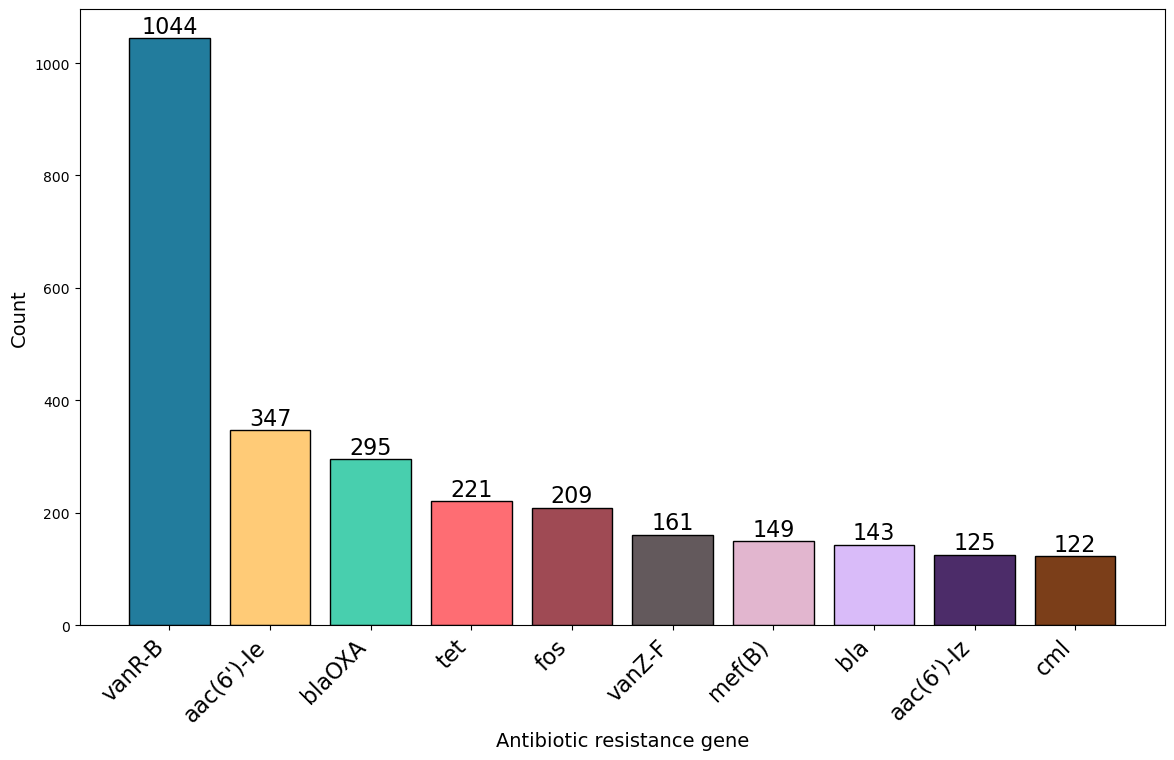

In [59]:
#plot the distribution of ARGs
df_ARG_top10_animals=df_ARG_animals.head(10)
plt.figure(figsize=(14, 8))
plt.bar(df_ARG_top10_animals["gene_symbol"],df_ARG_top10_animals["count"], color=top10_lca_colors, edgecolor='black', linewidth=1)
plt.xlabel('Antibiotic resistance gene', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=16)
#plt.title('Top 10 ARG distribution')
for i, v in enumerate(df_ARG_top10_animals["count"]):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom',fontsize=16)

In [26]:
# for all files in folder /home/giacomo/Thesis-Internship/waafle/mge_data/plasmids go trough each row and extract last column
ARG=[]
sample=[]
for file in os.listdir('/home/giacomo/Thesis-Internship/waafle/mge_data/plasmids'):
    with open('/home/giacomo/Thesis-Internship/waafle/mge_data/plasmids/' + file) as fn:
        sample_name=file.split(".")[0].split("_")[0]
        #skip first row
        next(fn)
        for line in fn:
            line=line.rstrip()
            arg=line.split("\t")[-1]
            if arg=="NA":
                ARG.append("unclassified")
            else:
                sample.append(sample_name)
                if ";" in arg:
                    arg=arg.split(";")
                    for a in arg:
                        ARG.append(a)
                else:
                    ARG.append(arg)

print(len(ARG))
#create a dataframe with the extracted data
df_plasmids=pd.DataFrame(ARG,columns=["ARG"])
df_plasmids=df_plasmids.value_counts().reset_index(name='count')
df_plasmids

336037


ARG   count
0   unclassified  328535
1       NF000402    2029
2       NF040806     574
3       NF012174     479
4       NF033693     439
..           ...     ...
69      NF012167       1
70      NF000225       1
71      NF033061       1
72      NF000262       1
73      NF000129       1

[74 rows x 2 columns]

In [32]:
print(df["plasmids"].sum())
print(df_plasmids[1:]["count"].sum())

335622
7502


#### 3) Plot top 10 entries

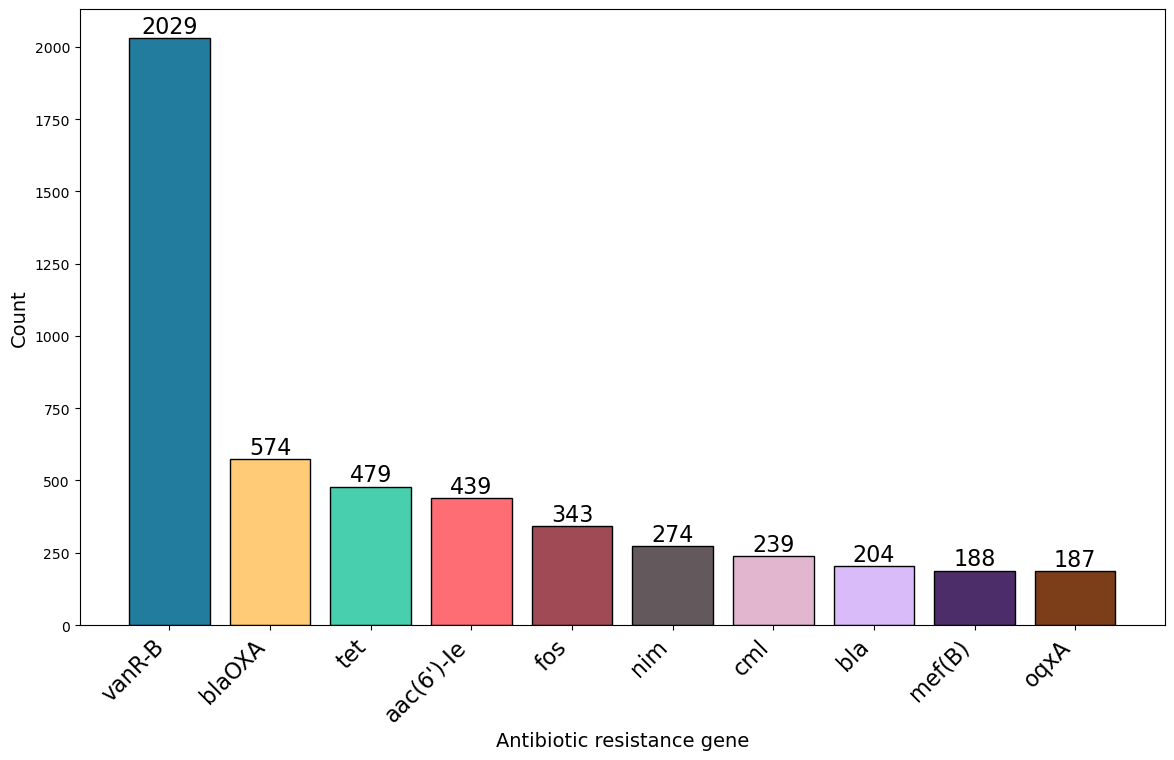

In [29]:
#plot the distribution of ARGs
df_ARG_top10=df_ARG.head(10)
plt.figure(figsize=(14, 8))
plt.bar(df_ARG_top10["gene_symbol"],df_ARG_top10["count"], color=top10_lca_colors, edgecolor='black', linewidth=1)
plt.xlabel('Antibiotic resistance gene', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=16)
#plt.title('Top 10 ARG distribution')
for i, v in enumerate(df_ARG_top10["count"]):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom',fontsize=16)


### - ARG genes per sample

#### 1) Extract gene symbols

In [36]:
# #from ncbi armfinder extract all gene symbols
# with open("/home/giacomo/Thesis-Internship/NCBIfam-AMRFinder_cleaned.tsv") as fn:
#     next(fn)
#     names=[]
#     for line in fn:
#         line=line.rstrip()
#         symbol=line.split("\t")[3]
#         names.append(symbol)
# print(names)

#### 2) Extract gene names from each sample and create a presence Matrix

In [37]:
# df_all_ARG=pd.DataFrame(columns=['vanR-B', 'blaOXA', 'tet', "aac(6')-Ie", 'fos', 'nim', 'cml', 'bla',
#     'mef(B)', 'oqxA', 'vanZ-F', 'ant(9)', 'mec', "aac(6')-Iz", 'lnu(AN2)',
#     'aph(6)-I', "aph(3')", 'ampC', 'fosB', "aac(6')-I", 'vanX', 'blaMSI',
#     'tcmA', 'aph(9)-Ia', 'tet(V)', 'blaCAR', 'tet(35)', 'sta', 'tet(38)',
#     'gar', 'aph(4)-Ia', 'vph', 'fusD', 'blaI', 'blaPOM', "aac(6')-Ib",
#     'mgt', 'vanG', 'vanR', "aac(6')", 'mecB', 'otr(B)', 'rox', 'ble',
#     'mecI', 'cpt', 'arr', 'lnu(F)', 'aac(3)-I', 'vanT', 'fosM',
#     "aac(2')-Ia", 'aac(3)-XI', 'rmt', 'bleO', 'mph', 'blaIMP', 'vanA-Sc',
#     'blaPJM', 'nimIJ', "ant(4')-I"])

# # for all files in folder /home/giacomo/Thesis-Internship/waafle/mge_data/plasmids go trough each row and extract last column
# for file in os.listdir('/home/giacomo/Thesis-Internship/waafle/mge_data/plasmids'):
#     #open the file NCBIfam-AMRFinder_cleaned.tsv as a pandas df and merge it with the df_plasmids
#     df_ARG=pd.read_csv("/home/giacomo/Thesis-Internship/NCBIfam-AMRFinder_cleaned.tsv",sep="\t")
#     df_ARG=df_ARG[["#hmm_accession","hmm_description","gene_symbol"]]
#     df_ARG.rename(columns={"#hmm_accession":"ARG"},inplace=True)
#     ARG=[]
#     with open('/home/giacomo/Thesis-Internship/waafle/mge_data/plasmids/' + file) as fn:
        
#         #Extract sample name
#         sample_name=file.split(".")[0].split("_")[0]
#         #skip first row
#         next(fn)
#         for line in fn:
#             line=line.rstrip()
#             arg=line.split("\t")[-1]
#             if arg=="NA":
#                 ARG.append("unclassified")
#             else:
#                 if ";" in arg:
#                     arg=arg.split(";")
#                     for a in arg:
#                         ARG.append(a)
#                 else:
#                     ARG.append(arg)
#         df_plasmids=pd.DataFrame(ARG,columns=["ARG"])
#         df_plasmids=df_plasmids.value_counts().reset_index(name='count')            
#         df_ARG_sample=df_ARG.merge(df_plasmids,on="ARG",how="inner")

#         #add a row for the sample name in the all df and fill it with zeros
#         df_all_ARG.loc[sample_name]=0
        
#         #for each gene_symbol in df_arg_copy for the current sample retrieve the corresponding column in df_all_ARG and add a 1 
#         for gene_symbol in df_ARG_sample["gene_symbol"]:
#             if gene_symbol in df_all_ARG.columns:
#                 df_all_ARG.at[sample_name,gene_symbol]=1

# df_all_ARG.columns = map(str.lower, df_all_ARG.columns)                
# df_all_ARG.to_csv("/home/giacomo/Thesis-Internship/waafle/ARG_matrix.tsv", sep="\t")
df_all_ARG=pd.read_csv("/home/giacomo/Thesis-Internship/waafle/ARG_matrix.tsv", sep="\t", index_col=0)
df_all_ARG

vanr-b  blaoxa  tet  aac(6')-ie  fos  nim  cml  bla  mef(b)  \
C16-20409-GH       1       0    1           0    1    0    1    1       0   
C16-20563-TZ       0       0    1           0    1    0    1    0       0   
C16-20625-TZ       1       1    1           1    0    1    1    0       0   
C16-20228-GH       1       0    1           0    1    0    1    0       0   
C16-20039-GH       1       0    1           0    0    1    0    0       0   
...              ...     ...  ...         ...  ...  ...  ...  ...     ...   
C16-20152-TZ       1       1    0           0    1    1    1    0       0   
C16-20491-TZ       1       1    1           1    1    0    1    0       0   
C16-20583-TZ       1       0    0           0    0    0    0    0       0   
C16-20269-GH       1       1    1           1    1    1    1    1       1   
C16-20284-TZ       1       0    0           1    1    1    0    0       0   

              oqxa  ...  aac(2')-ia  aac(3)-xi  rmt  bleo  mph  blaimp  \
C16-20409-GH     1  ...           0          0    0     0    0       0   
C16-20563-TZ     0  ...           0          0    0     0    0       0   
C16-20625-TZ     0  ...           0          0    0     0    0       0   
C16-20228-GH     0  ...           0          0    0     0    0       0   
C16-20039-GH     0  ...           0          0    0     0    0       0   
...            ...  ...         ...        ...  ...   ...  ...     ...   
C16-20152-TZ     1  ...           0          0    0     0    0       0   
C16-20491-TZ     0  ...           0          0    0     0    0       0   
C16-20583-TZ     0  ...           0          0    0     0    0       0   
C16-20269-GH     0  ...           0          0    0     0    0       0   
C16-20284-TZ     0  ...           0          0    0     0    0       0   

              vana-sc  blapjm  nimij  ant(4')-i  
C16-20409-GH        0       0      0          0  
C16-20563-TZ        0       0      0          0  
C16-20625-TZ        0       0      0          0  
C16-20228-GH        0       0      0          0  
C16-20039-GH        0       0      0          0  
...               ...     ...    ...        ...  
C16-20152-TZ        0       0      0          0  
C16-20491-TZ        0       0      0          0  
C16-20583-TZ        0       0      0          0  
C16-20269-GH        0       0      0          0  
C16-20284-TZ        0       0      0          0  

[555 rows x 61 columns]

### - Sample with more ARG 

#### 1) extract samples with nmore ARG

In [38]:
df_all_ARG_copy=df_all_ARG.copy()
#Extract samples that have more 1 value in the ARG matrix
df_all_ARG_copy["total"]=df_all_ARG_copy.sum(axis=1)
#plot_box_swarm_and_histogram(df_all_ARG_copy, 'total', 'Box plot of ARGs per sample', 'Histogram of ARGs per sample',dataset_colors[0], dataset_colors[1], 'N° of ARGs', 'N° of ARGs','N° of samples')

#order the samples by the total number of ARGs
df_all_ARG_copy=df_all_ARG_copy.sort_values(by="total",ascending=False)
df_all_ARG_copy["total"].head(10)

C16-20051-GH    31
C16-20077-GH    23
C16-20158-GH    21
C16-20557-TZ    20
C16-20235-GH    20
C16-20055-TZ    19
C16-20269-GH    19
C16-20107-GH    19
C16-20025-GH    19
C16-20048-GH    18
Name: total, dtype: int64

#### 2) Correlation between samples with most ARG and sequencing depth

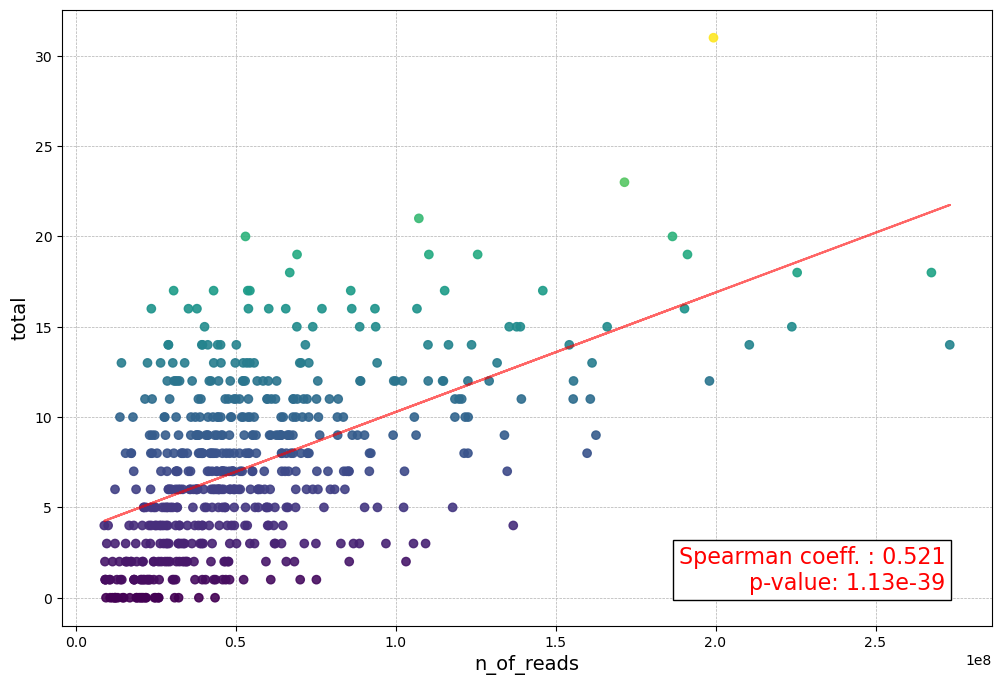

In [39]:
#create a dataframe with sample name and n_of_reads from initial df
df_reads=df[["sampleID","n_of_reads","species"]]

#add the ranking of the samples by the total number of ARGs to the df_reads as a new column 
df_reads=df_reads.merge(df_all_ARG_copy["total"],left_on="sampleID",right_index=True,how="inner")
df_reads=df_reads.sort_values(by="total",ascending=False)

spearman_correlation_scatter(df_reads, "total", "n_of_reads", "big")

#### 3) Normalize ARG count with depth

In [40]:
#Normalize amoun t of ARg genes by the number of reads
max_depth=df_reads["n_of_reads"].max()
df_reads["ARGs_normalized"]=df_reads["total"]*(max_depth/df_reads["n_of_reads"])
df_reads=df_reads.sort_values(by="ARGs_normalized",ascending=False)
df_reads.head(10)

sampleID  n_of_reads species  total  ARGs_normalized
133  C16-20132-GH    14292504     dog     13       248.498780
297  C16-20611-TZ    13824503    goat     10       197.624009
135  C16-20225-GH    23635887     dog     16       184.942749
131  C16-20022-GH    22438155     dog     13       158.287070
166  C16-20121-GH    17891689    goat     10       152.699597
347  C16-20288-GH    30607824   human     17       151.741963
149  C16-20044-GH    15580380    goat      8       140.281749
285  C16-20525-TZ    21653990    goat     11       138.785465
469  C16-20205-TZ    26530069   human     13       133.873373
548  C16-20598-TZ    12286396   sheep      6       133.418475

### - Comparison with Vittoria results

#### 1) Create a dataframe with the list of ARG per sample (Giacomo)

In [41]:
# for each sample in the ARG extract all the columns that have 1 as value and put them into a list
ARG_samples=[]
sampes=[]
for sample in df_all_ARG.index:
    sample_ARG=df_all_ARG.loc[sample]
    sample_ARG=sample_ARG[sample_ARG==1]
    sampes.append(sample)
    ARG_samples.append(sample_ARG.index.to_list())
df_ARG_list_G=pd.DataFrame(sampes,columns=["sample"])
df_ARG_list_G["ARG_G"]=ARG_samples
df_ARG_list_G["amount_G"]=df_ARG_list_G["ARG_G"].apply(lambda x: len(x))
df_ARG_list_G

sample                                              ARG_G  amount_G
0    C16-20409-GH  [vanr-b, tet, fos, cml, bla, oqxa, aac(6')-iz,...         9
1    C16-20563-TZ  [tet, fos, cml, vanz-f, ant(9), aac(6')-iz, ap...        11
2    C16-20625-TZ  [vanr-b, blaoxa, tet, aac(6')-ie, nim, cml, fosb]         7
3    C16-20228-GH                  [vanr-b, tet, fos, cml, lnu(an2)]         5
4    C16-20039-GH                                 [vanr-b, tet, nim]         3
..            ...                                                ...       ...
550  C16-20152-TZ  [vanr-b, blaoxa, fos, nim, cml, oqxa, mec, aac...        12
551  C16-20491-TZ  [vanr-b, blaoxa, tet, aac(6')-ie, fos, cml, va...        14
552  C16-20583-TZ                                     [vanr-b, vanx]         2
553  C16-20269-GH  [vanr-b, blaoxa, tet, aac(6')-ie, fos, nim, cm...        19
554  C16-20284-TZ  [vanr-b, aac(6')-ie, fos, nim, aac(6')-i, tcma...         7

[555 rows x 3 columns]

#### 1.1) Merge df_ARG_list_G and df_reads to see if dogs have same ARG

In [42]:
#merge arg list with df_reads
df_reads_ARG=df_reads.merge(df_ARG_list_G,left_on="sampleID",right_on="sample",how="inner")
df_reads_ARG=df_reads_ARG.sort_values(by="ARGs_normalized",ascending=False)
pd.set_option('display.max_colwidth', None)
df_reads_ARG.head(10)
#extracte rows that have dog as species
# df_dogs=df_reads_ARG[df_reads_ARG["species"]=="dog"]
# df_dogs=df_dogs.sort_values(by="ARGs_normalized",ascending=False)

# df_dogs.head(10)

sampleID  n_of_reads species  total  ARGs_normalized        sample  \
0  C16-20132-GH    14292504     dog     13       248.498780  C16-20132-GH   
1  C16-20611-TZ    13824503    goat     10       197.624009  C16-20611-TZ   
2  C16-20225-GH    23635887     dog     16       184.942749  C16-20225-GH   
3  C16-20022-GH    22438155     dog     13       158.287070  C16-20022-GH   
4  C16-20121-GH    17891689    goat     10       152.699597  C16-20121-GH   
5  C16-20288-GH    30607824   human     17       151.741963  C16-20288-GH   
6  C16-20044-GH    15580380    goat      8       140.281749  C16-20044-GH   
7  C16-20525-TZ    21653990    goat     11       138.785465  C16-20525-TZ   
8  C16-20205-TZ    26530069   human     13       133.873373  C16-20205-TZ   
9  C16-20598-TZ    12286396   sheep      6       133.418475  C16-20598-TZ   

                                                                                                                            ARG_G  \
0                                              [vanr-b, tet, fos, cml, bla, oqxa, ampc, blamsi, tcma, blacar, fusd, aac(6'), ble]   
1                                                       [vanr-b, tet, fos, cml, bla, oqxa, aac(6')-iz, aph(6)-i, aac(6')-i, blai]   
2    [vanr-b, blaoxa, tet, cml, bla, vanz-f, ant(9), mec, aac(6')-iz, lnu(an2), aph(6)-i, fosb, aac(6')-i, tcma, tet(38), otr(b)]   
3                                         [vanr-b, blaoxa, tet, nim, cml, bla, vanz-f, ant(9), mec, aph(6)-i, fosb, sta, tet(38)]   
4                                                 [vanr-b, tet, aac(6')-ie, fos, cml, mef(b), oqxa, vanz-f, aac(6')-iz, lnu(an2)]   
5  [vanr-b, blaoxa, tet, aac(6')-ie, fos, nim, cml, bla, mef(b), oqxa, vanz-f, mec, lnu(an2), aph(6)-i, blamsi, tet(35), tet(38)]   
6                                                                     [vanr-b, blaoxa, tet, aac(6')-ie, fos, cml, mef(b), blacar]   
7                                                  [vanr-b, tet, aac(6')-ie, fos, cml, bla, oqxa, vanz-f, aac(6')-iz, ampc, tcma]   
8                                         [vanr-b, blaoxa, tet, aac(6')-ie, fos, nim, cml, mef(b), oqxa, mec, fosb, blamsi, tcma]   
9                                                                             [vanr-b, blaoxa, aac(6')-ie, nim, aac(6')-iz, vanx]   

   amount_G  
0        13  
1        10  
2        16  
3        13  
4        10  
5        17  
6         8  
7        11  
8        13  
9         6

#### 1.2) Count the differences between the ARG of dogs

In [43]:
# for each sample extract the ARG_G and ARG_V columns and put them into a list
ARG_list=[]
#iterate trough the df
for index,row in df_dogs.iterrows():
    ARG_list.append(row["ARG_G"])

for n in range(0,len(ARG_list)):
    
    for ARG in ARG_list[n]:
        if ARG not in ARG_list:
            ARG_list.append(ARG)
    diff=0
    #Go trough each ARG in the longest list and check if it is present in the other list. if it's not present add 1 in the diff counter
    if len(ARG_G)>len(ARG_V):
        for ARG in ARG_G:
            if ARG not in ARG_V:
                diff+=1
    else:
        for ARG in ARG_V:
            if ARG not in ARG_G:
                diff+=1
    differences.append(diff)
df_ARG_list_GV["differences"]=differences
df_ARG_list_GV.to_csv("/home/giacomo/Thesis-Internship/waafle/ARG_differences.csv", sep="\t")
df_ARG_list_GV

KeyError: 'ARG_G'

#### 2) Create a dataframe with the list of ARG per sample (Vittoria)

In [ ]:
df_vittoria=pd.read_csv("/home/giacomo/Thesis-Internship/animal_human_presence_genes.csv",sep=",", index_col=0)

ARG_samples=[]
sampes=[]
for sample in df_vittoria.index:
    sample_ARG=df_vittoria.loc[sample]
    sample_ARG=sample_ARG[sample_ARG==1]
    sampes.append(sample)
    ARG_samples.append(sample_ARG.index.to_list())
df_ARG_list_V=pd.DataFrame(sampes,columns=["sample"])
df_ARG_list_V["ARG_V"]=ARG_samples
df_ARG_list_V["amount_V"]=df_ARG_list_V["ARG_V"].apply(lambda x: len(x))
df_ARG_list_V

sample                                              ARG_V  amount_V
0    C16-20047-GH  [tet(32), tet(q), vanxy, sat2, cfxa6, aade, cf...        18
1    C16-20020-GH  [cata1, tet(32), cata13, blatem, cfia29, dfra7...        19
2    C16-20139-GH  [tet(32), cfxa6, nima, aade, tet(44), cfxa4, t...        16
3    C16-20092-GH  [tet(32), tet(q), cfxa6, nima, cfxa, tet(44), ...        11
4    C16-20110-GH  [tet(32), tet(q), tetb(p), cfxa6, nima, tet(44...        16
..            ...                                                ...       ...
553  C16-20408-GH  [tet(32), tet(q), tetb(p), tet(l), tet(44), te...        11
554  C16-20320-GH  [tet(32), tet(q), blaaci, tet(x2), aads, estt,...        16
555  C16-20409-GH  [tet(32), tet(q), tetb(p), tet(l), tet(44), te...         9
556  C16-20075-GH  [tet(32), tet(q), cfxa3, nima, aade, tet(44), ...        14
557  C16-20089-GH  [tet(32), tet(q), blaaci, tet(x2), aads, tetb(...        18

[558 rows x 3 columns]

#### 3) Merge dataframes

In [ ]:
#merge df_ARG_list_G and df_ARG_list_V on sample
df_ARG_list_GV=df_ARG_list_G.merge(df_ARG_list_V,on="sample",how="inner")
df_ARG_list_GV['difference_amount'] = (df_ARG_list_GV['amount_G'] - df_ARG_list_GV['amount_V']).abs()
df_ARG_list_GV

sample                                              ARG_G  \
0    C16-20409-GH  [vanr-b, tet, fos, cml, bla, oqxa, aac(6')-iz,...   
1    C16-20563-TZ  [tet, fos, cml, vanz-f, ant(9), aac(6')-iz, ap...   
2    C16-20625-TZ  [vanr-b, blaoxa, tet, aac(6')-ie, nim, cml, fosb]   
3    C16-20228-GH                  [vanr-b, tet, fos, cml, lnu(an2)]   
4    C16-20039-GH                                 [vanr-b, tet, nim]   
..            ...                                                ...   
550  C16-20152-TZ  [vanr-b, blaoxa, fos, nim, cml, oqxa, mec, aac...   
551  C16-20491-TZ  [vanr-b, blaoxa, tet, aac(6')-ie, fos, cml, va...   
552  C16-20583-TZ                                     [vanr-b, vanx]   
553  C16-20269-GH  [vanr-b, blaoxa, tet, aac(6')-ie, fos, nim, cm...   
554  C16-20284-TZ  [vanr-b, aac(6')-ie, fos, nim, aac(6')-i, tcma...   

     amount_G                                              ARG_V  amount_V  \
0           9  [tet(32), tet(q), tetb(p), tet(l), tet(44), te...         9   
1          11  [tet(32), tet(q), estt, tet(40), tet(o), tet(w...         7   
2           7  [tet(32), tet(q), aads, erm(b), cfxa6, cfxa, t...         9   
3           5  [tet(32), tet(q), aads, estt, tet(44), tet(40)...        10   
4           3  [tet(32), tet(q), blaaci, cfxa6, nima, cfxa, t...        10   
..        ...                                                ...       ...   
550        12  [tet(32), blaoxa, tet(q), tet(x2), cata13, aad...        17   
551        14  [dfra1, tet(32), tet(q), oqxa, mph(a), oqxb, b...        29   
552         2                          [tet(40), tet(o), tet(w)]         3   
553        19  [tet(32), tet(q), tet(x2), aads, aaca10, estt,...        17   
554         7  [tet(32), tet(q), blaaci, dfra7, cepa, cfxa6, ...        19   

     difference_amount  
0                    0  
1                    4  
2                    2  
3                    5  
4                    7  
..                 ...  
550                  5  
551                 15  
552                  1  
553                  2  
554                 12  

[555 rows x 6 columns]

#### 4) Count the differences between the Giacomo and Vittoria gene lists

In [ ]:
# for each sample extract the ARG_G and ARG_V columns and put them into a list
differences=[]
for sample in df_ARG_list_GV["sample"]:
    ARG_G=df_ARG_list_GV.loc[df_ARG_list_GV["sample"]==sample]["ARG_G"].values[0]
    ARG_V=df_ARG_list_GV.loc[df_ARG_list_GV["sample"]==sample]["ARG_V"].values[0]
    
    diff=0
    #Go trough each ARG in the longest list and check if it is present in the other list. if it's not present add 1 in the diff counter
    if len(ARG_G)>len(ARG_V):
        for ARG in ARG_G:
            if ARG not in ARG_V:
                diff+=1
    else:
        for ARG in ARG_V:
            if ARG not in ARG_G:
                diff+=1
    differences.append(diff)
df_ARG_list_GV["differences"]=differences
df_ARG_list_GV.to_csv("/home/giacomo/Thesis-Internship/waafle/ARG_differences.csv", sep="\t")
df_ARG_list_GV

sample                                              ARG_G  \
0    C16-20409-GH  [vanr-b, tet, fos, cml, bla, oqxa, aac(6')-iz,...   
1    C16-20563-TZ  [tet, fos, cml, vanz-f, ant(9), aac(6')-iz, ap...   
2    C16-20625-TZ  [vanr-b, blaoxa, tet, aac(6')-ie, nim, cml, fosb]   
3    C16-20228-GH                  [vanr-b, tet, fos, cml, lnu(an2)]   
4    C16-20039-GH                                 [vanr-b, tet, nim]   
..            ...                                                ...   
550  C16-20152-TZ  [vanr-b, blaoxa, fos, nim, cml, oqxa, mec, aac...   
551  C16-20491-TZ  [vanr-b, blaoxa, tet, aac(6')-ie, fos, cml, va...   
552  C16-20583-TZ                                     [vanr-b, vanx]   
553  C16-20269-GH  [vanr-b, blaoxa, tet, aac(6')-ie, fos, nim, cm...   
554  C16-20284-TZ  [vanr-b, aac(6')-ie, fos, nim, aac(6')-i, tcma...   

     amount_G                                              ARG_V  amount_V  \
0           9  [tet(32), tet(q), tetb(p), tet(l), tet(44), te...         9   
1          11  [tet(32), tet(q), estt, tet(40), tet(o), tet(w...         7   
2           7  [tet(32), tet(q), aads, erm(b), cfxa6, cfxa, t...         9   
3           5  [tet(32), tet(q), aads, estt, tet(44), tet(40)...        10   
4           3  [tet(32), tet(q), blaaci, cfxa6, nima, cfxa, t...        10   
..        ...                                                ...       ...   
550        12  [tet(32), blaoxa, tet(q), tet(x2), cata13, aad...        17   
551        14  [dfra1, tet(32), tet(q), oqxa, mph(a), oqxb, b...        29   
552         2                          [tet(40), tet(o), tet(w)]         3   
553        19  [tet(32), tet(q), tet(x2), aads, aaca10, estt,...        17   
554         7  [tet(32), tet(q), blaaci, dfra7, cepa, cfxa6, ...        19   

     difference_amount  differences  
0                    0            9  
1                    4           11  
2                    2            9  
3                    5           10  
4                    7           10  
..                 ...          ...  
550                  5           16  
551                 15           29  
552                  1            3  
553                  2           18  
554                 12           19  

[555 rows x 7 columns]

Text(0.5, 1.0, 'Amount of ARGs in G vs V')

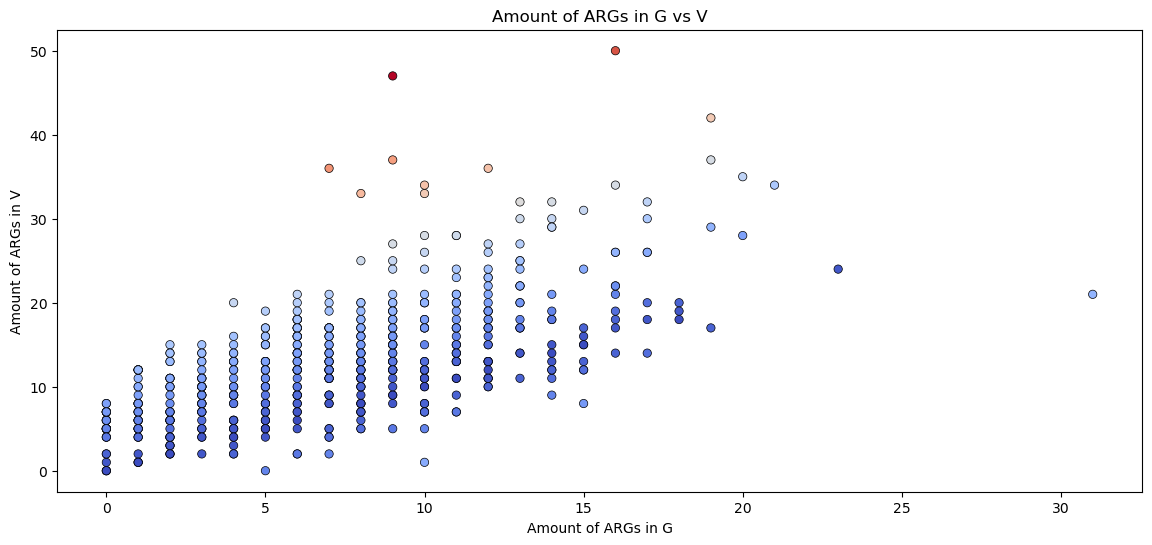

In [ ]:
# plot the distribution of difference_amount with scatter plot
plt.figure(figsize=(14, 6))
plt.scatter(df_ARG_list_GV["amount_G"],df_ARG_list_GV["amount_V"], c=df_ARG_list_GV["difference_amount"], cmap='coolwarm', edgecolor='black', linewidth=0.5)
plt.xlabel('Amount of ARGs in G')
plt.ylabel('Amount of ARGs in V')
plt.title('Amount of ARGs in G vs V')
    

In [ ]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

# **Viruses**

## 0) Overall distribution

In [45]:
plot_box_swarm_and_histogram(df, 'viruses_depth', 'Box Plot of viruses normalized by sequencing depth per sample', 'Histogram of HGT events normalized by sequencing depth per sample',dataset_colors[4], dataset_colors[5], 'N° of viruses normalized', 'N° of viruses normalized','N° of samples')

TypeError: plot_box_swarm_and_histogram() missing 1 required positional argument: 'ylabel_hist'

## 1) Distribution by country

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Tanzania v.s. Ghana: Mann-Whitney-Wilcoxon test two-sided, P_val=6.493e-05 U_stat=4.365e+04


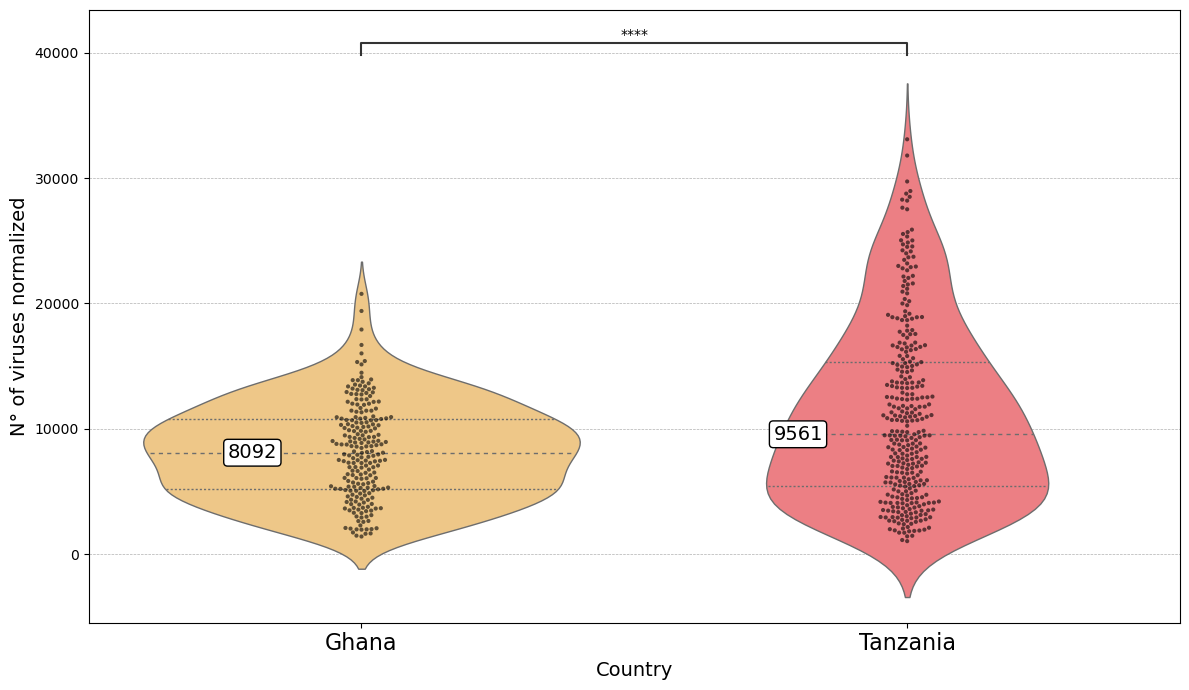

In [46]:
plot_violin_swarm_with_annotations(df, 'country', 'viruses_depth', 'Viruses distribution per country', 'Country', 'N° of viruses normalized', custom_order=["Ghana", "Tanzania"], palette=states_color, pairs=[('Ghana', 'Tanzania')])

In [ ]:
confounder_analysis(df,"viruses", "country","sex")

Null Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                viruses   No. Observations:                  550
Model:                            GLM   Df Residuals:                      548
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                      4.1163e+06
Method:                          IRLS   Log-Likelihood:                -4967.8
Date:                Wed, 07 Aug 2024   Deviance:                   2.2557e+09
Time:                        11:19:42   Pearson chi2:                 2.26e+09
No. Iterations:                     3   Pseudo R-squ. (CS):           0.003369
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept     

In [ ]:
# Count the amount of viruses per country
df_country_viruses = df.groupby('country')['viruses'].sum().reset_index()
df_country_viruses_depth = df.groupby('country')['viruses_depth'].sum().reset_index()

print(df_country_viruses)
print(df_country_viruses_depth)
print(df_ghana.shape)
print(df_tanzania.shape)

    country  viruses
0     Ghana   408867
1  Tanzania   687685
    country  viruses_depth
0     Ghana   1.810929e+06
1  Tanzania   3.668278e+06
(221, 28)
(329, 28)


## 2) Distribution of viruses per sex divided by country

### - Confounder analysis (viruses ~ country / viruses ~ country + sex)

In [ ]:
confounder_analysis(df_humans, 'viruses', 'country', 'sex')

Null Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                viruses   No. Observations:                  204
Model:                            GLM   Df Residuals:                      202
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                      1.3609e+05
Method:                          IRLS   Log-Likelihood:                -1494.2
Date:                Wed, 07 Aug 2024   Deviance:                   2.7490e+07
Time:                        11:19:42   Pearson chi2:                 2.75e+07
No. Iterations:                     3   Pseudo R-squ. (CS):           0.001572
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept     

/tmp/ipykernel_4329/1654002582.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[primary_independent_var] = df[primary_independent_var].astype('category')


### - Confounder analysis (viruses ~ sex / viruses ~ sex + country)

In [ ]:
confounder_analysis(df_humans, 'viruses', 'sex', 'richness')

Null Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                viruses   No. Observations:                  204
Model:                            GLM   Df Residuals:                      202
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                      1.3381e+05
Method:                          IRLS   Log-Likelihood:                -1492.5
Date:                Wed, 07 Aug 2024   Deviance:                   2.7030e+07
Time:                        11:19:42   Pearson chi2:                 2.70e+07
No. Iterations:                     3   Pseudo R-squ. (CS):            0.01829
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     852.9926     31.

/tmp/ipykernel_4329/1654002582.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[primary_independent_var] = df[primary_independent_var].astype('category')


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

males_GH v.s. females_GH: Mann-Whitney-Wilcoxon test two-sided, P_val=7.956e-02 U_stat=3.780e+02
males_TZ v.s. females_TZ: Mann-Whitney-Wilcoxon test two-sided, P_val=5.628e-01 U_stat=1.831e+03
males v.s. females: Mann-Whitney-Wilcoxon test two-sided, P_val=1.630e-01 U_stat=4.069e+03


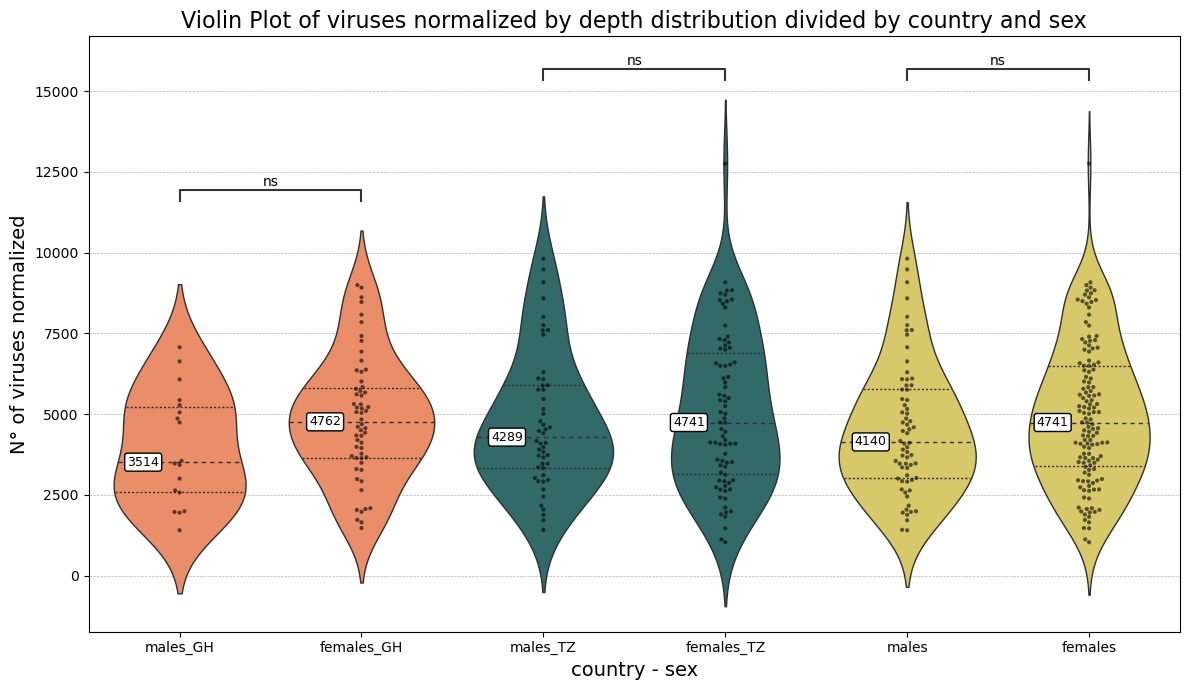

In [ ]:
plot_violin_swarm_with_annotations(df_sex_plot, x='dataset', y='viruses_depth', title='Violin Plot of viruses normalized by depth distribution divided by country and sex', x_label='country - sex', y_label='N° of viruses normalized', custom_order=['males_GH', 'females_GH', 'males_TZ', 'females_TZ', 'males', 'females'], palette=sex_nation_colors,pairs=[("males_GH", "females_GH"), ("males_TZ", "females_TZ"), ("males", "females")])

## 3) Distribution of viruses humans vs animals

## 4) Distribution of viruses per species

### - Confounder analysis (viruses ~ species / viruses ~ species + country)

In [ ]:
confounder_analysis(df_all_species, 'viruses', 'species', 'country')

Null Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                viruses   No. Observations:                  550
Model:                            GLM   Df Residuals:                      545
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                      2.9604e+06
Method:                          IRLS   Log-Likelihood:                -4875.6
Date:                Wed, 07 Aug 2024   Deviance:                   1.6134e+09
Time:                        11:19:43   Pearson chi2:                 1.61e+09
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3291
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         36

### - Confounder analysis (viruses ~ species / viruses ~ species + richness)

In [ ]:
confounder_analysis(df_all_species, 'viruses', 'species', 'richness')

Null Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                viruses   No. Observations:                  550
Model:                            GLM   Df Residuals:                      545
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                      2.9604e+06
Method:                          IRLS   Log-Likelihood:                -4875.6
Date:                Wed, 07 Aug 2024   Deviance:                   1.6134e+09
Time:                        11:19:44   Pearson chi2:                 1.61e+09
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3291
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         36

### - Plot

In [47]:
groups = [df_humans,df_dogs,df_cows,df_goats,df_sheeps]
names_list=["humans","dogs","cows","goats","sheep"]
dunn_species_depth=perform_kruskal_dunn(groups,"viruses_depth",names_list)

Kruskal-Wallis test result: H-statistic = 362.3015019402151, p-value = 3.8695407729936976e-77
Kruskal-Wallis test is significant, performing Dunn test...
Significant Dunn test results (Bonferroni corrected):
              1         2             3             4             5
1           NaN       NaN  2.253313e-72  1.250427e-32  1.219906e-12
2           NaN       NaN  4.088005e-05  3.623311e-02  3.404073e-02
3  2.253313e-72  0.000041           NaN  1.693644e-10  1.567433e-03
4  1.250427e-32  0.036233  1.693644e-10           NaN           NaN
5  1.219906e-12  0.034041  1.567433e-03           NaN           NaN
humans cows 2.253313341567542e-72
humans goats 1.2504271367726407e-32
humans sheep 1.2199063101705884e-12
dogs cows 4.088004610953293e-05
dogs goats 0.03623311455714582
dogs sheep 0.0340407347581946
cows goats 1.6936438504268163e-10
cows sheep 0.0015674332183819284


[('Cows', 'Humans'), ('Goats', 'Humans'), ('Sheep', 'Humans'), ('Cows', 'Dogs'), ('Goats', 'Dogs'), ('Sheep', 'Dogs'), ('Goats', 'Cows'), ('Sheep', 'Cows')]
[2.253313341567542e-72, 1.2504271367726407e-32, 1.2199063101705884e-12, 4.088004610953293e-05, 0.03623311455714582, 0.0340407347581946, 1.6936438504268163e-10, 0.0015674332183819284]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Dogs v.s. Cows: Custom statistical test, P_val:4.088e-05
Cows v.s. Goats: Custom statistical test, P_val:1.694e-10
Humans v.s. Cows: Custom statistical test, P_val:2.253e-72
Dogs v.s. Goats: Custom statistical test, P_val:3.623e-02
Cows v.s. Sheep: Custom statistical test, P_val:1.567e-03
Humans v.s. Goats: Custom statistical test, P_val:1.250e-32
Dogs v.s. Sheep: Custom statistical test, P_val:3.404e-02
Humans v.s. Sheep: Custom statistical test, P_val:1.220e-12


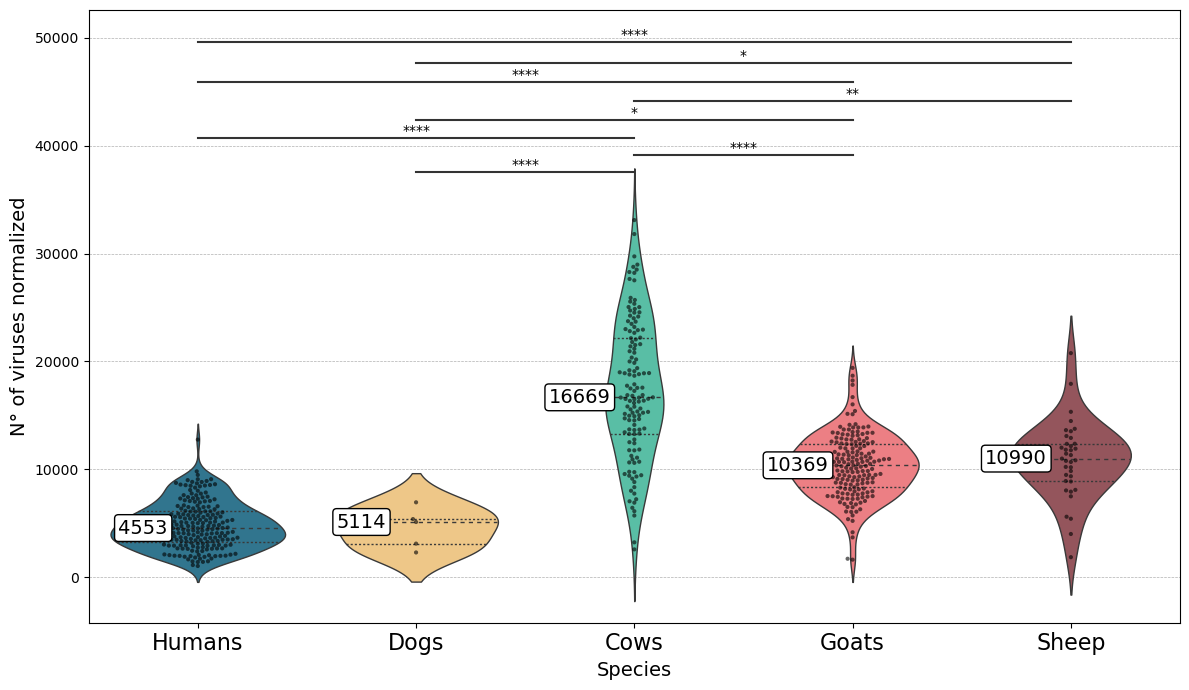

In [48]:
plot_violin_swarm_with_annotations_animals(df_all_species, x='species', y='viruses_depth', significant_results=dunn_species_depth, title='Violin Plot of viruses normalized by depth distribution divided by species', x_label='Species', y_label='N° of viruses normalized', custom_order = ["Humans", "Dogs",  "Cows","Goats", "Sheep"], palette=species_colors,names=["Humans","Dogs","Cows","Goats","Sheep"])

### - Confounder analysis (viruses ~ species / viruses ~ species + richness)

In [ ]:
confounder_analysis(df_binomial_species, 'viruses', 'species', 'richness')

Null Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                viruses   No. Observations:                  550
Model:                            GLM   Df Residuals:                      548
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                      3.3120e+06
Method:                          IRLS   Log-Likelihood:                -4908.0
Date:                Wed, 07 Aug 2024   Deviance:                   1.8150e+09
Time:                        11:19:45   Pearson chi2:                 1.81e+09
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2182
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         26

### - Plot

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

humans v.s. animals: Mann-Whitney-Wilcoxon test two-sided, P_val=1.395e-67 U_stat=4.021e+03


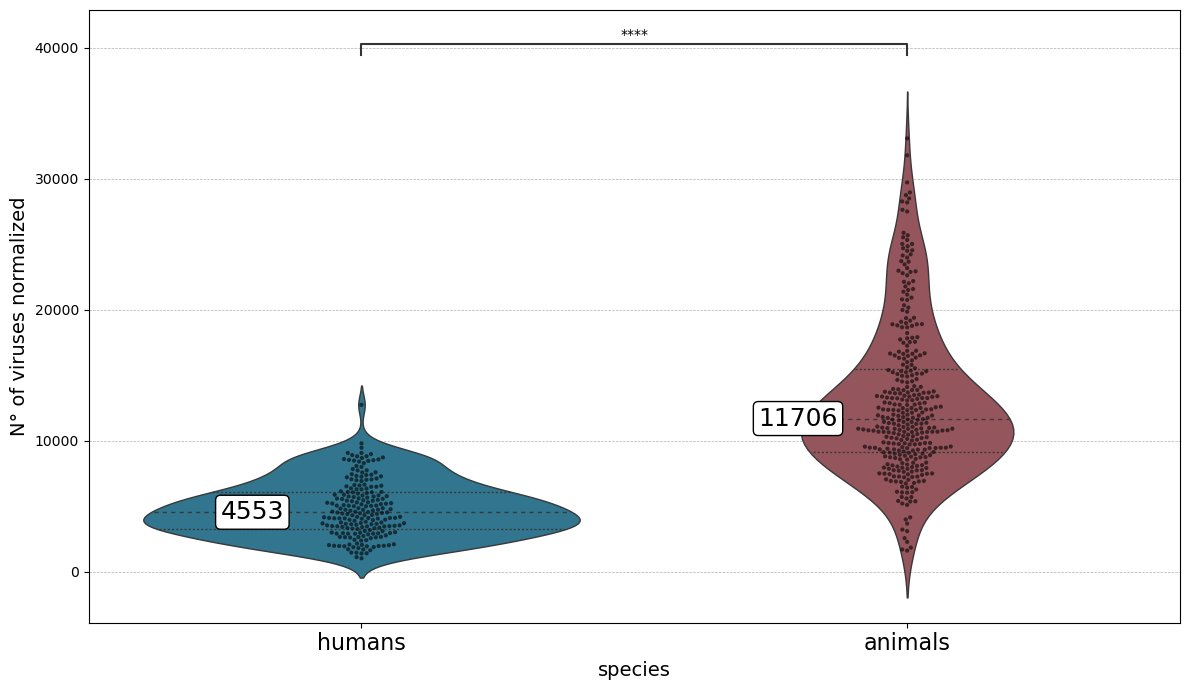

In [ ]:
plot_violin_swarm_with_annotations(df_binomial_species, x='species', y='viruses_depth', title='Violin Plot of viruses normalized by depth humans vs animals', x_label='species', y_label='N° of viruses normalized', custom_order=["humans","animals"],  palette=humans_animals_colors, pairs=[("humans", "animals")])

## 5) Distribution of viruses events per family role

In [ ]:
groups = [df_mother,df_father,df_sibling,df_grandmother,df_grandfather, df_aunt, df_uncle, df_cousin]
names_list=["mothers","fathers","siblings","grandmothers","grandfathers","aunts","uncles","cousins"]
dunn_family_depth=perform_kruskal_dunn(groups,"viruses_depth",names_list)

Kruskal-Wallis test result: H-statistic = 19.41943404807239, p-value = 0.006970141770470112
Kruskal-Wallis test is significant, performing Dunn test...
Significant Dunn test results (Bonferroni corrected):
    1   2         3         4   5   6   7   8
1 NaN NaN       NaN       NaN NaN NaN NaN NaN
2 NaN NaN       NaN       NaN NaN NaN NaN NaN
3 NaN NaN       NaN  0.004061 NaN NaN NaN NaN
4 NaN NaN  0.004061       NaN NaN NaN NaN NaN
5 NaN NaN       NaN       NaN NaN NaN NaN NaN
6 NaN NaN       NaN       NaN NaN NaN NaN NaN
7 NaN NaN       NaN       NaN NaN NaN NaN NaN
8 NaN NaN       NaN       NaN NaN NaN NaN NaN
siblings grandmothers 0.00406114671524617


[('grandmother', 'sibling')]
[0.00406114671524617]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

sibling v.s. grandmother: Custom statistical test, P_val:4.061e-03


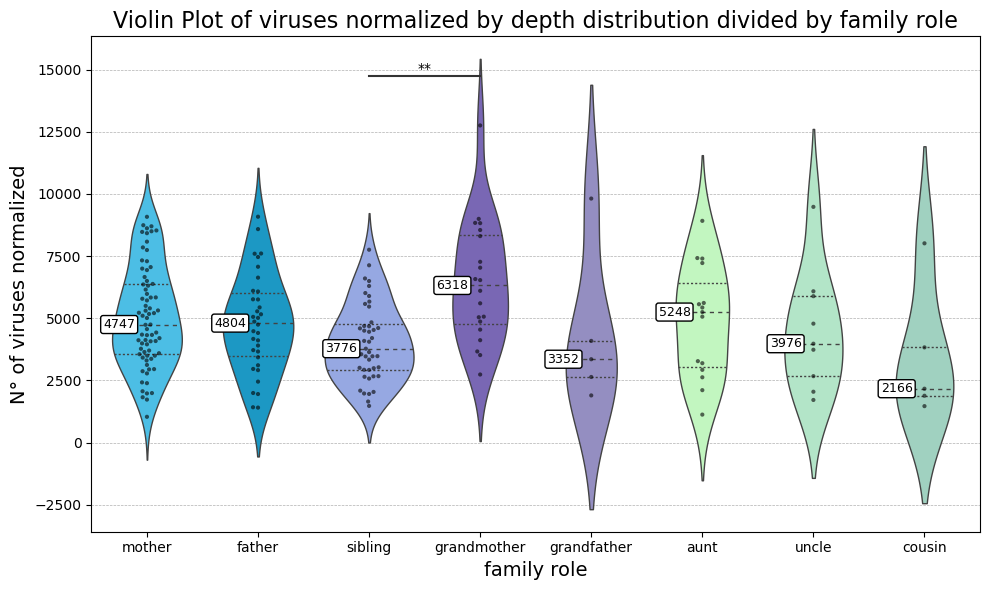

In [ ]:
plot_violin_swarm_with_annotations_animals(df_family_role, x='family_role', y='viruses_depth', significant_results=dunn_family_depth, title='Violin Plot of viruses normalized by depth distribution divided by family role', x_label='family role', y_label='N° of viruses normalized', custom_order = ["mother", "father",  "sibling","grandmother", "grandfather","aunt","uncle","cousin"], palette=family_colors, names = ["mother", "father",  "sibling","grandmother", "grandfather","aunt","uncle","cousin"])

## 6) Distribution of viruses events by age

### - Confounder analysis (viruses ~ age / viruses ~ age + richness)

In [49]:
confounder_analysis(df_all_species, 'viruses', 'country', 'age_years')

Null Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                viruses   No. Observations:                  550
Model:                            GLM   Df Residuals:                      548
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                      4.1163e+06
Method:                          IRLS   Log-Likelihood:                -4967.8
Date:                Sat, 14 Sep 2024   Deviance:                   2.2557e+09
Time:                        12:55:54   Pearson chi2:                 2.26e+09
No. Iterations:                     3   Pseudo R-squ. (CS):           0.003369
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept     

### - Plot

In [50]:
groups = [df_newborn, df_child, df_schoolage, df_adult, df_senior]
names_list=["newborns","children","schoolage","adults","seniors"]
dunn_age_depth=perform_kruskal_dunn(groups,"viruses_depth",names_list)

Kruskal-Wallis test result: H-statistic = 23.133719451141246, p-value = 0.0001190702911712668
Kruskal-Wallis test is significant, performing Dunn test...
Significant Dunn test results (Bonferroni corrected):
    1        2   3        4   5
1 NaN      NaN NaN      NaN NaN
2 NaN      NaN NaN  0.00034 NaN
3 NaN      NaN NaN      NaN NaN
4 NaN  0.00034 NaN      NaN NaN
5 NaN      NaN NaN      NaN NaN
children adults 0.0003403361580302992


[('Adult', 'Child')]
[0.0003403361580302992]
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Child v.s. Adult: Custom statistical test, P_val:3.403e-04


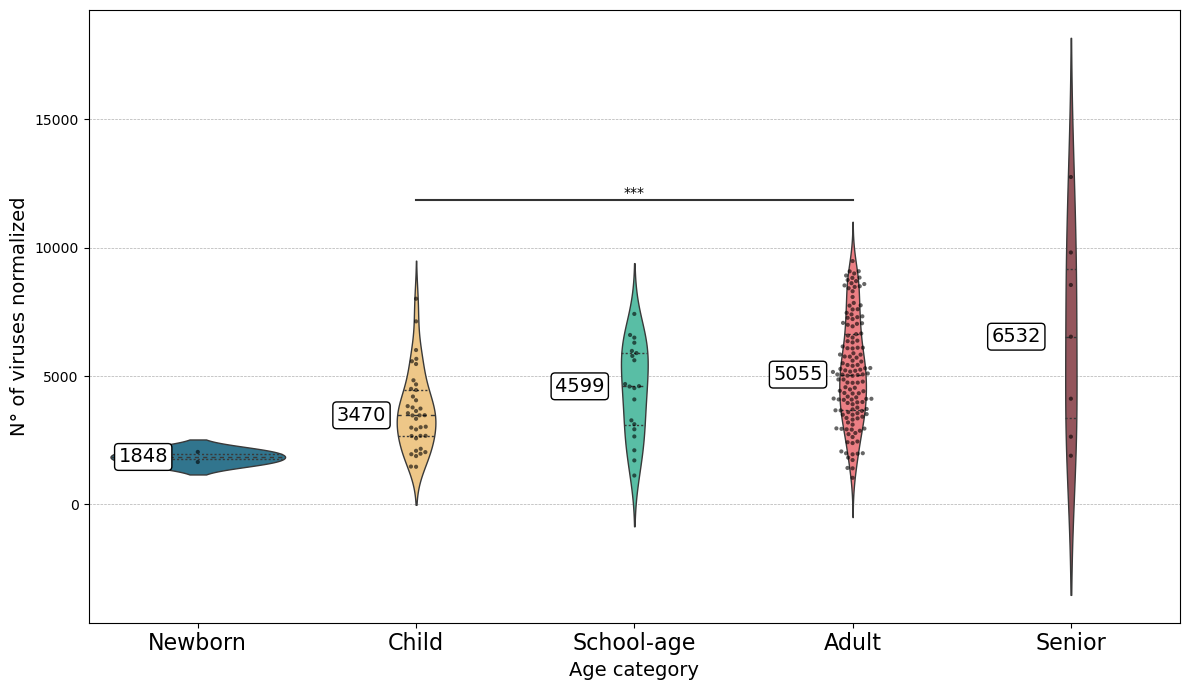

In [51]:
plot_violin_swarm_with_annotations_animals(df_age, x='dataset', y='viruses_depth', significant_results=dunn_age_depth, title='Violin Plot of viruses normalized by depth distribution divided by age', x_label='Age category', y_label='N° of viruses normalized', custom_order = ["Newborn","Child","School-age","Adult","Senior"], palette=age_colors, names = ["Newborn","Child","School-age","Adult","Senior"])

### - Age as a continuum

In [ ]:
df_humans_copy2=df_humans.copy()

#from df_humans_cop2 remove rows that have Nan values in column age_years
df_humans_copy2.dropna(subset = ["age_years"], inplace=True)

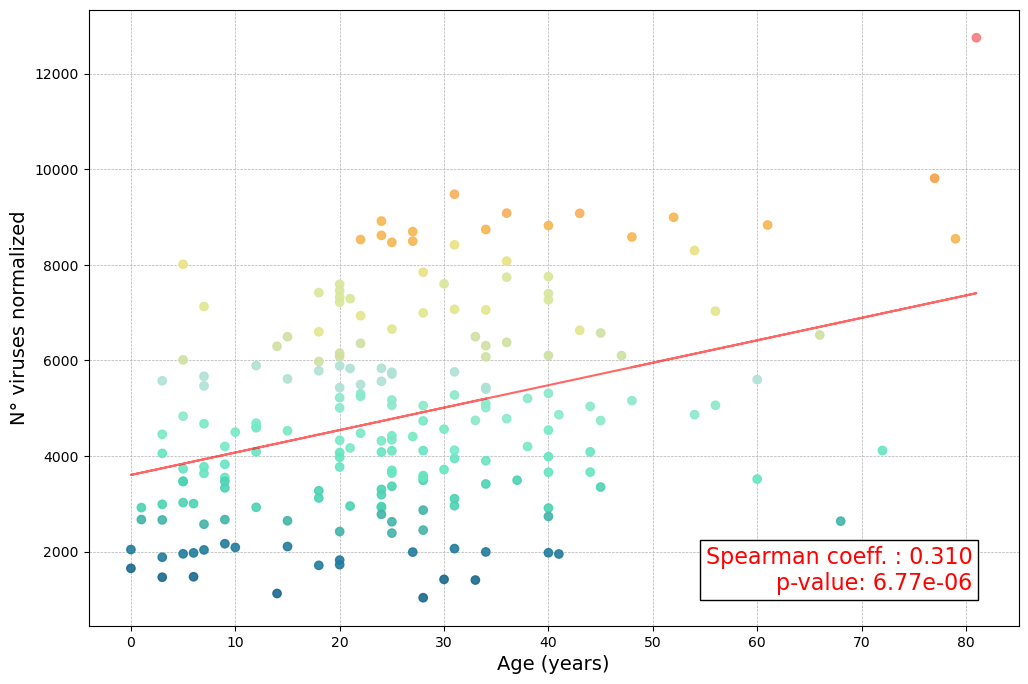

In [ ]:
spearman_correlation_scatter(df_humans_copy2, "viruses_depth", "age_years", "big","", xlab="Age (years)",ylab="N° viruses normalized", map=custom_cmap)

## 7) Virus taxonomy analysis

### - Genomad taxonomy

In [ ]:
# for all files in folder /home/giacomo/Thesis-Internship/waafle/mge_data/viruses go trough each row and extract last column
vir=0
vir_c=0
vir_o=0
vir_f=0
classes=[]
family=[]
order=[]
for file in os.listdir('/home/giacomo/Thesis-Internship/waafle/mge_data/viruses'):
    with open('/home/giacomo/Thesis-Internship/waafle/mge_data/viruses/' + file) as fn:
        #skip first row
        next(fn)
        for line in fn:
            line=line.rstrip()
            vir+=1
            tax=line.split("\t")[10].split(";")
            if len(tax)==1:
                continue
            if tax[4]!="":
                vir_c+=1
                classes.append(tax[4])
            if tax[5]!="":
                vir_o+=1
                order.append(tax[5])
            if tax[6]!="":
                vir_f+=1
                family.append(tax[6])
df_vir_c=pd.DataFrame(classes,columns=["classes"])
df_vir_c=df_vir_c.value_counts().reset_index(name='count')
df_vir_o=pd.DataFrame(order,columns=["order"])
df_vir_o=df_vir_o.value_counts().reset_index(name='count')
df_vir_f=pd.DataFrame(family,columns=["family"])
df_vir_f=df_vir_f.value_counts().reset_index(name='count')
print(f"Total number of virus detected: {vir}. Number of unclassified viruses: {vir-vir_c}. Number of viruses with class level classification: {vir_c}. Number of viruses with order level classification: {vir_o}. Number of viruses with family level classification: {vir_f}.")


Total number of virus detected: 1096592. Number of unclassified viruses: 74291. Number of viruses with class level classification: 1022301. Number of viruses with order level classification: 17084. Number of viruses with family level classification: 26129.


In [ ]:
df_vir_c.head(10)

classes    count
0      Caudoviricetes  1012014
1       Megaviricetes     5597
2  Malgrandaviricetes     1724
3      Faserviricetes      647
4       Arfiviricetes      580
5     Pokkesviricetes      352
6    Duplopiviricetes      232
7     Stelpaviricetes      191
8    Tectiliviricetes      180
9      Herviviricetes      133

In [ ]:
df_vir_o.head(10)

order  count
0    Crassvirales   6866
1   Imitervirales   2936
2     Algavirales   2369
3    Petitvirales   1724
4   Tubulavirales    647
5    Cirlivirales    575
6    Chitovirales    352
7    Durnavirales    232
8  Pimascovirales    215
9   Herpesvirales    133

In [ ]:
df_vir_f.head(10)

family  count
0       Kyanoviridae   3303
1      Straboviridae   3084
2        Mimiviridae   2936
3    Phycodnaviridae   2369
4     Herelleviridae   2283
5  Autographiviridae   1996
6       Microviridae   1724
7     Demerecviridae   1463
8   Ackermannviridae   1252
9      Schitoviridae    832

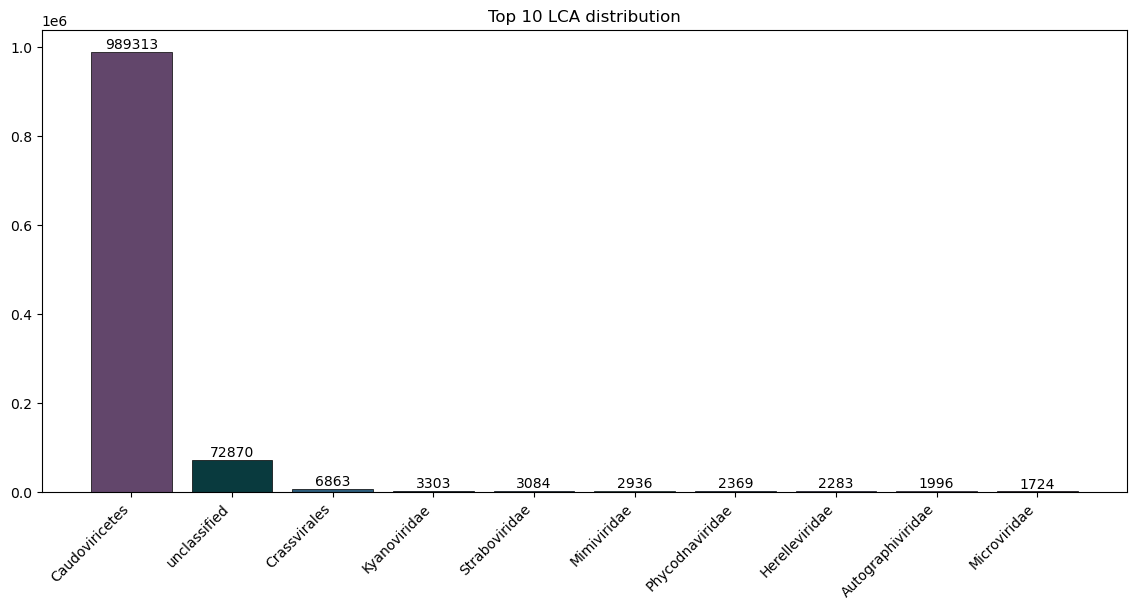

In [ ]:
#plot the distribution of viruses
df_viruses_top10=df_viruses.head(10)
plt.figure(figsize=(14, 6))
plt.bar(df_viruses_top10["taxonomy"],df_viruses_top10["count"], color=lca_colors, edgecolor='black', linewidth=0.5)
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 LCA distribution')
for i, v in enumerate(df_viruses_top10["count"]):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')

In [ ]:
# plt.figure(figsize=(14, 6))
# bax = brokenaxes(ylims=((0, 10000), (70000, 80000), (980000, 990000)), hspace=.2)

# # Plot the data
# bax.bar(df_viruses_top10["taxonomy"], df_viruses_top10["count"], color=lca_colors, edgecolor='black', linewidth=0.5)

# # Annotate the bars
# for i, v in enumerate(df_viruses_top10["count"]):
#     bax.text(i, v + 500, str(v), ha='center', va='bottom')

# for ax in bax.axs:
#     ax.set_xticks(np.arange(len(df_viruses_top10["taxonomy"])))
#     ax.set_xticklabels(df_viruses_top10["taxonomy"], rotation=45, ha='right')

# plt.suptitle('Top 10 LCA distribution')
# plt.show()

In [ ]:
df_viruses.head(15)

taxonomy   count
0      Caudoviricetes  989313
1        unclassified   72870
2        Crassvirales    6863
3        Kyanoviridae    3303
4       Straboviridae    3084
5         Mimiviridae    2936
6     Phycodnaviridae    2369
7      Herelleviridae    2283
8   Autographiviridae    1996
9        Microviridae    1724
10     Demerecviridae    1463
11   Ackermannviridae    1252
12            Viruses     846
13      Schitoviridae     832
14     Drexlerviridae     653

### - Metaphlan taxonomy

In [ ]:
# from all the files in folder /home/giacomo/Thesis-Internship/waafle/viruses_metaphlan go through each row and extract the last column
viruses=[]
for sample in os.listdir('/home/giacomo/Thesis-Internship/waafle/virus_metaphlan/'):
    with open('/home/giacomo/Thesis-Internship/waafle/virus_metaphlan/' + sample) as fn:
        #skipt the first 4 lines of the file
        for i in range(4):
            next(fn)
        for line in fn:
            if "#" and "M-Group" not in line:
                line=line.rstrip()
                tax=line.split("\t")[7]
                if tax=="-":
                    tax="unknown"
                viruses.append(tax)
            else:
                continue
df_viruses_metaphlan=pd.DataFrame(viruses,columns=["taxonomy"])
df_viruses_metaphlan=df_viruses_metaphlan.value_counts().reset_index(name='count')
df_viruses_metaphlan
#sum all the counts of the viruses

taxonomy  \
0                                                                  unknown   
1                                        NC_001895_Enterobacteria_phage_P2   
2                                          NC_028685_Shigella_phage_SsVASD   
3                                        NC_042128_Escherichia_phage_RCS47   
4                                                 NC_009514_Phage_cdtI_DNA   
5                                         NC_013594_Escherichia_phage_D108   
6                                          NC_018843_Salmonella_phage_SSU5   
7                                          NC_024711_Uncultured_crAssphage   
8                                          NC_001317_Escherichia_phage_186   
9                                        NC_031053_Klebsiella_phage_PKP126   
10                                      NC_016770_Bacteroides_phage_B12414   
11                                   NC_018285_Streptococcus_phage_YMC2011   
12                                         NC_013059_Salmonella_phage_c341   
13                                       NC_021777_Salmonella_phage_Jersey   
14                                      NC_028750_Klebsiella_phage_Matisse   
15                                NC_042041_Klebsiella_phage_vB_KpnM_KpV79   
16                                        NC_030953_Shigella_phage_SHFML11   
17                                   NC_027982_Lactobacillus_phage_phiPYB5   
18                           NC_019403_Enterobacteria_phage_vB_EcoP_ACGC91   
19                                         NC_013647_Klebsiella_phage_KP32   
20                             NC_024786_Escherichia_phage_vB_EcoP_PhAPEC5   
21                                NC_031246_Klebsiella_phage_vB_KpnP_KpV71   
22                                 NC_021325_Clostridium_phage_vB_CpeSCP51   
23                                         NC_027369_Escherichia_phage_EC6   
24                                 NC_029014_Parabacteroides_phage_YZ2015b   
25                                         NC_031092_Citrobacter_phage_SH2   
26                                    NC_005294_Streptococcus_prophage_EJ1   
27                                     NC_020079_Escherichia_phage_phAPEC8   
28                                NC_024134_Escherichia_phage_vB_EcoM_FFH2   
29                                      NC_028901_Escherichia_phage_slur05   
30                                       NC_016158_Escherichia_phage_HK639   
31                                   NC_002671_Lactococcus_prophage_bIL312   
32                                   NC_002669_Lactococcus_prophage_bIL310   
33                                         NC_003315_Haemophilus_phage_HP2   
34                                      NC_001954_Enterobacteria_phage_If1   
35                                       NC_004996_Streptococcus_phage_SM1   
36                                        NC_004746_Lactococcus_phage_4268   
37                                   NC_002670_Lactococcus_prophage_bIL311   
38                                       NC_007059_Staphylococcus_phage_71   
39                              NC_026613_Uncultured_phage_WWnAnB_strain_3   
40                                    NC_013644_Enterococcus_phage_phiFL4A   
41                                        NC_020880_Leuconostoc_phage_P793   
42                                 NC_029012_Parabacteroides_phage_YZ2015a   
43  NC_028840_Escherichia_phage_slur09_genome_assembly_slu09_chromosome__1   
44                                    NC_028826_Enterococcus_phage_IMEEFm5   
45                                NC_031920_Streptococcus_phage_phiARI0004   

    count  
0   10388  
1     254  
2     180  
3      78  
4      74  
5      36  
6      23  
7      18  
8      16  
9      13  
10     12  
11     11  
12     10  
13     10  
14      9  
15      9  
16      9  
17      8  
18      8  
19      7  
20      7  
21      6  
22      6  
23      5  
24      5  
25      4  
26      3  
27      3  
28      3  
29      3  
30      2  
31      2  
32 

In [ ]:
viruses_list = ["-",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Peduoviridae; Peduovirus; Peduovirus P2",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Sepvirinae; Oslovirus; Oslovirus VASD",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Punavirus; Punavirus RCS47",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; unclassified Caudoviricetes",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Muvirus; Muvirus mu",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; unclassified Caudoviricetes",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Crassvirales; unclassified Crassvirales",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Peduoviridae; Eganvirus; Eganvirus ev186",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Drexlerviridae; Webervirus; Webervirus PKP126",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; unclassified Caudoviricetes",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Aliceevansviridae; unclassified Aliceevansviridae",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Lederbergvirus; unclassified Lederbergvirus",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Guernseyvirinae; Jerseyvirus; Jerseyvirus jersey",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Straboviridae; Slopekvirus; Slopekvirus matisse",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Jedunavirus; Jedunavirus KpV52",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Straboviridae; Tevenvirinae; Tequatrovirus; Tequatrovirus shfml11",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; unclassified Caudoviricetes",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Autographiviridae; Molineuxvirinae; Vectrevirus; Vectrevirus ACGC91",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Autographiviridae; Studiervirinae; Przondovirus; Przondovirus KP32",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Schitoviridae; Enquatrovirinae; Gamaleyavirus; Gamaleyavirus APEC5",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Autographiviridae; Slopekvirinae; Drulisvirus; Drulisvirus KpV71",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; unclassified Caudoviricetes",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Ounavirinae; Felixounavirus; Felixounavirus EC6",
    "Viruses; Monodnaviria; Sangervirae; Phixviricota; Malgrandaviricetes; Petitvirales; Microviridae; unclassified Microviridae",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Autographiviridae; Studiervirinae; Teetrevirus; Teetrevirus SH2",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; unclassified Caudoviricetes",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Stephanstirmvirinae; Phapecoctavirus; Escherichia virus phAPEC8",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Vequintavirinae; Vequintavirus; Vequintavirus FFH2",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Dhillonvirus; unclassified Dhillonvirus",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; unclassified Caudoviricetes",
    "Viruses; unclassified bacterial viruses",
    "Viruses; unclassified bacterial viruses",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Peduoviridae; Hpunavirus; Hpunavirus HP2",
    "Viruses; Monodnaviria; Loebvirae; Hofneiviricota; Faserviricetes; Tubulavirales; Inoviridae; Infulavirus; Infulavirus If1",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; unclassified Caudoviricetes",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Sandinevirus; unclassified Sandinevirus",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Sandinevirus; unclassified Sandinevirus",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Azeredovirinae; Phietavirus; Phietavirus pv71",
    "Viruses; Monodnaviria; Loebvirae; Hofneiviricota; Faserviricetes; Tubulavirales; Inoviridae; environmental samples",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; unclassified Caudoviricetes",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Mccleskeyvirinae; Limdunavirus; Limdunavirus P793",
    "Viruses; Monodnaviria; Sangervirae; Phixviricota; Malgrandaviricetes; Petitvirales; Microviridae; unclassified Microviridae",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; Demerecviridae; Markadamsvirinae; Tequintavirus; Tequintavirus slur09",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; unclassified Caudoviricetes",
    "Viruses; Duplodnaviria; Heunggongvirae; Uroviricota; Caudoviricetes; unclassified Caudoviricetes"
]
classes = ["-",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Malgrandaviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "unclassified bacterial viruses",
    "unclassified bacterial viruses",
    "Caudoviricetes",
    "Faserviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Faserviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Malgrandaviricetes",
    "Caudoviricetes",
    "Caudoviricetes",
    "Caudoviricetes"
]
families = ["-",
    "Peduoviridae",
    "Sepvirinae",
    "Punavirus",
    "unclassified Caudoviricetes",
    "Muvirus",
    "unclassified Caudoviricetes",
    "Crassvirales",
    "Peduoviridae",
    "Drexlerviridae",
    "unclassified Caudoviricetes",
    "Aliceevansviridae",
    "Lederbergvirus",
    "Guernseyvirinae",
    "Straboviridae",
    "Jedunavirus",
    "Straboviridae",
    "unclassified Caudoviricetes",
    "Autographiviridae",
    "Autographiviridae",
    "Schitoviridae",
    "Autographiviridae",
    "unclassified Caudoviricetes",
    "Ounavirinae",
    "Microviridae",
    "Autographiviridae",
    "unclassified Caudoviricetes",
    "Stephanstirmvirinae",
    "Vequintavirinae",
    "Dhillonvirus",
    "unclassified Caudoviricetes",
    "unclassified bacterial viruses",
    "unclassified bacterial viruses",
    "Peduoviridae",
    "Inoviridae",
    "unclassified Caudoviricetes",
    "Sandinevirus",
    "Sandinevirus",
    "Azeredovirinae",
    "Inoviridae",
    "unclassified Caudoviricetes",
    "Mccleskeyvirinae",
    "Microviridae",
    "Demerecviridae",
    "unclassified Caudoviricetes",
    "unclassified Caudoviricetes"
]



In [ ]:
df_viruses_metaphlan["full taxonomy"]=viruses_list
df_viruses_metaphlan["class"]=classes
df_viruses_metaphlan["family"]=families
#order

#df_viruses_metaphlan=df_viruses_metaphlan.value_counts().reset_index(name='count')
df_viruses_metaphlan_class=df_viruses_metaphlan[["class","count"]]
#sum the count of viruses that belong to the same class
df_viruses_metaphlan_class=df_viruses_metaphlan_class.groupby("class").sum().reset_index()
df_viruses_metaphlan_class.sort_values(by="count",ascending=False).reset_index(drop=True)
#do the same with family
df_viruses_metaphlan_family=df_viruses_metaphlan[["family","count"]]
df_viruses_metaphlan_family=df_viruses_metaphlan_family.groupby("family").sum().reset_index()
df_viruses_metaphlan_family.sort_values(by="count",ascending=False).reset_index(drop=True)


family  count
0                                -  10388
1                     Peduoviridae    272
2                       Sepvirinae    180
3      unclassified Caudoviricetes    132
4                        Punavirus     78
5                          Muvirus     36
6                Autographiviridae     25
7                     Crassvirales     18
8                    Straboviridae     18
9                   Drexlerviridae     13
10               Aliceevansviridae     11
11                 Guernseyvirinae     10
12                  Lederbergvirus     10
13                     Jedunavirus      9
14                   Schitoviridae      7
15                    Microviridae      6
16                     Ounavirinae      5
17  unclassified bacterial viruses      4
18                 Vequintavirinae      3
19             Stephanstirmvirinae      3
20                    Dhillonvirus      3
21                      Inoviridae      2
22                    Sandinevirus      2
23                  Demerecviridae      1
24                  Azeredovirinae      1
25                Mccleskeyvirinae      1

In [ ]:
count_genomad=df_viruses["count"].sum()
count_metaphlan=df_viruses_metaphlan["count"].sum()
print(count_genomad)
print(count_metaphlan)

1096592
11238
